In [35]:
import pypsa
import xarray as xr
import linopy as lp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import beta

In [36]:

# create a new shell-network
m = pypsa.Network()

# take the base network 2045
n = pypsa.Network('base_s_1__none_2045_lt.nc')

# fix the capacities and create the model
n.optimize.fix_optimal_capacities()
n.optimize.create_model()
# fix m to the size of n
m.set_snapshots(n.snapshots)



# Stores filtern - get all stores that contain battery
battery_stores = n.stores[n.stores.carrier.str.contains("battery", case=False, na=False)]
battery_buses = battery_stores.bus.unique()

# Links filtern - get all links that contain battery (e.g. battery charger / discharger)
link_mask = (
    n.links.carrier.str.contains("battery", case=False, na=False)
)
battery_links = n.links[link_mask]

# Get all buses
store_buses = battery_stores.bus.tolist()
link_buses = pd.concat([
    battery_links.bus0, battery_links.bus1,
    battery_links.bus2, battery_links.bus3
]).dropna().tolist()

needed_buses = list(set(store_buses + link_buses))
needed_buses = [b for b in needed_buses if isinstance(b, str) and b.strip()]


# Copy all buses, links and stores that refere to battery from model n to model m
m.import_components_from_dataframe(n.buses.loc[needed_buses], "Bus")
m.import_components_from_dataframe(battery_stores, "Store")
m.import_components_from_dataframe(battery_links, "Link")

# Add a free Generator so the battery storage can consume power
m.add("Generator", "source", bus="DE0 0", p_nom=10000000000000, marginal_cost=0)

# Add a constant load so the battery storage can discharge power
m.add("Load",
      "fixed_load",
      bus="DE0 0", 
      p_set=5000000000)   

# create the model
m.optimize.create_model()

INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'EU', 'DE'}


Linopy LP model

Variables:
----------
 * Generator-p (snapshot, Generator)
 * Link-p (snapshot, Link)
 * Store-e (snapshot, Store)
 * Store-p (snapshot, Store)

Constraints:
------------
 * Generator-fix-p-lower (snapshot, Generator-fix)
 * Generator-fix-p-upper (snapshot, Generator-fix)
 * Link-fix-p-lower (snapshot, Link-fix)
 * Link-fix-p-upper (snapshot, Link-fix)
 * Store-fix-e-lower (snapshot, Store-fix)
 * Store-fix-e-upper (snapshot, Store-fix)
 * Bus-nodal_balance (Bus, snapshot)
 * Store-energy_balance (snapshot, Store)

Status:
-------
initialized

# Profitoptimierung:
- Links halten nur 10 Jahre, die von vor 40 existieren nicht mehr
- Stores sind alle über die constraints miteinander verbunden

--> Link von 40 und 45 müssen optimiert werden, rest egal.

In [37]:
### Extra Functionality for the Optimization

# get the prices from the different szenarios
def change_obj(price_list):

    def helper(k,sns):
        # get battery charger, discharger and the efficiency
        battery_charger_2045 = k.model.variables["Link-p"].sel({"Link":"DE0 0 battery charger-2045"})
        battery_discharger_2045 = k.model.variables["Link-p"].sel({"Link":"DE0 0 battery discharger-2045"})

        battery_charger_2040 = k.model.variables["Link-p"].sel({"Link":"DE0 0 battery charger-2040"})
        battery_discharger_2040 = k.model.variables["Link-p"].sel({"Link":"DE0 0 battery discharger-2040"})
        efficiency_2045 = k.links.efficiency["DE0 0 battery charger-2045"]
        efficiency_2040 = k.links.efficiency["DE0 0 battery charger-2040"]

        # Stochastic Profit Optimization:
        # for each price sum the expected profits and then maximize the resulting function.
        expected_profit = 0
        for price in price_list:
            # Umwandlung in xarray.DataArray mit passender snapshot-Koord.
            price_xr = xr.DataArray(price.values, coords={"snapshot": price.index}, dims="snapshot")
               
            #
            expected_profit = (battery_discharger_2040 *price_xr 
                               + battery_discharger_2045 * price_xr 
                               - battery_charger_2040 * price_xr / efficiency_2040 
                               - battery_charger_2045 * price_xr / efficiency_2045
                               ).sum() / len(price_list)
        
        k.model.objective = expected_profit
        k.model.sense = 'max'

    return helper

normales Netzwerk lösen für Strompreise

In [38]:
#n = pypsa.Network('base_s_1__none_2045_lt.nc')
#n.optimize.fix_optimal_capacities()
n.optimize.optimize_with_rolling_horizon(
    solver_name = "gurobi",
    horizon = 48,
    overlap = 8
)

INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 241.68it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-btu1g30d.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-btu1g30d.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x8083ffd0


INFO:gurobipy:Model fingerprint: 0x8083ffd0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4432 columns


INFO:gurobipy:Presolve removed 22641 rows and 4432 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7280 columns, 14540 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7280 columns, 14540 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.03322770e+11 -1.47194971e+13  1.53e+06 6.86e+01  4.30e+09     0s


INFO:gurobipy:   0   2.03322770e+11 -1.47194971e+13  1.53e+06 6.86e+01  4.30e+09     0s


   1   2.79444133e+10 -1.01894653e+12  1.29e+05 5.09e-11  3.32e+08     0s


INFO:gurobipy:   1   2.79444133e+10 -1.01894653e+12  1.29e+05 5.09e-11  3.32e+08     0s


   2   7.76176096e+09 -2.31670314e+11  8.87e+03 2.04e-09  3.17e+07     0s


INFO:gurobipy:   2   7.76176096e+09 -2.31670314e+11  8.87e+03 2.04e-09  3.17e+07     0s


   3   2.20085353e+09 -5.03944067e+10  6.58e+02 3.31e-10  4.40e+06     0s


INFO:gurobipy:   3   2.20085353e+09 -5.03944067e+10  6.58e+02 3.31e-10  4.40e+06     0s


   4   1.12149426e+09 -8.61275076e+09  7.74e+01 6.76e-10  7.20e+05     0s


INFO:gurobipy:   4   1.12149426e+09 -8.61275076e+09  7.74e+01 6.76e-10  7.20e+05     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1736    2.5764985e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1736    2.5764985e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1736 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1736 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.576498545e+08


INFO:gurobipy:Optimal objective  2.576498545e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.58e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-06 00:00:00:2019-01-11 21:00:00] (2/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 227.47it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s0lc2q4h.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-s0lc2q4h.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xb29b87e6


INFO:gurobipy:Model fingerprint: 0xb29b87e6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4434 columns


INFO:gurobipy:Presolve removed 22641 rows and 4434 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7278 columns, 14541 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7278 columns, 14541 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.86404841e+11 -1.47416341e+13  2.20e+06 6.81e+01  5.73e+09     0s


INFO:gurobipy:   0   2.86404841e+11 -1.47416341e+13  2.20e+06 6.81e+01  5.73e+09     0s


   1   3.63135850e+10 -1.22981880e+12  1.87e+05 5.14e-11  4.68e+08     0s


INFO:gurobipy:   1   3.63135850e+10 -1.22981880e+12  1.87e+05 5.14e-11  4.68e+08     0s


   2   8.68848326e+09 -2.93971380e+11  1.09e+04 1.99e-09  4.03e+07     0s


INFO:gurobipy:   2   8.68848326e+09 -2.93971380e+11  1.09e+04 1.99e-09  4.03e+07     0s


   3   5.64536086e+09 -6.42747488e+10  1.53e+03 6.43e-10  6.87e+06     0s


INFO:gurobipy:   3   5.64536086e+09 -6.42747488e+10  1.53e+03 6.43e-10  6.87e+06     0s


   4   2.36027693e+09 -2.18151166e+10  4.52e+02 1.34e-10  2.08e+06     0s


INFO:gurobipy:   4   2.36027693e+09 -2.18151166e+10  4.52e+02 1.34e-10  2.08e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1731    3.5771474e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1731    3.5771474e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1731 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1731 iterations and 0.10 seconds (0.06 work units)


Optimal objective  3.577147403e+08


INFO:gurobipy:Optimal objective  3.577147403e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.58e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-11 00:00:00:2019-01-16 21:00:00] (3/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 249.16it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e61f66v3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e61f66v3.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x29478ae7


INFO:gurobipy:Model fingerprint: 0x29478ae7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4434 columns


INFO:gurobipy:Presolve removed 22641 rows and 4434 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7278 columns, 14541 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7278 columns, 14541 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.69096309e+11 -1.47704695e+13  2.87e+06 7.31e+01  7.16e+09     0s


INFO:gurobipy:   0   3.69096309e+11 -1.47704695e+13  2.87e+06 7.31e+01  7.16e+09     0s


   1   4.45096527e+10 -1.30919740e+12  2.42e+05 4.70e-11  5.89e+08     0s


INFO:gurobipy:   1   4.45096527e+10 -1.30919740e+12  2.42e+05 4.70e-11  5.89e+08     0s


   2   7.81853905e+09 -3.51375846e+11  1.13e+04 2.51e-09  4.51e+07     0s


INFO:gurobipy:   2   7.81853905e+09 -3.51375846e+11  1.13e+04 2.51e-09  4.51e+07     0s


   3   2.29355964e+09 -8.03815421e+10  1.58e+03 4.91e-10  7.69e+06     0s


INFO:gurobipy:   3   2.29355964e+09 -8.03815421e+10  1.58e+03 4.91e-10  7.69e+06     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1850    2.1503336e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1850    2.1503336e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1850 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1850 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.150333602e+08


INFO:gurobipy:Optimal objective  2.150333602e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-16 00:00:00:2019-01-21 21:00:00] (4/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 242.51it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dbeizoas.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dbeizoas.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5636a5ab


INFO:gurobipy:Model fingerprint: 0x5636a5ab


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4521 columns


INFO:gurobipy:Presolve removed 22641 rows and 4521 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7191 columns, 14371 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7191 columns, 14371 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 3 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.34918442e+11 -1.47932348e+13  3.44e+06 6.76e+01  8.40e+09     0s


INFO:gurobipy:   0   4.34918442e+11 -1.47932348e+13  3.44e+06 6.76e+01  8.40e+09     0s


   1   5.25581529e+10 -1.42877849e+12  2.96e+05 4.73e-11  7.12e+08     0s


INFO:gurobipy:   1   5.25581529e+10 -1.42877849e+12  2.96e+05 4.73e-11  7.12e+08     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Extra simplex iterations after uncrush: 17


INFO:gurobipy:Extra simplex iterations after uncrush: 17


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1656    3.2716728e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1656    3.2716728e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1656 iterations and 0.19 seconds (0.05 work units)


INFO:gurobipy:Solved in 1656 iterations and 0.19 seconds (0.05 work units)


Optimal objective  3.271672790e+09


INFO:gurobipy:Optimal objective  3.271672790e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.27e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-21 00:00:00:2019-01-26 21:00:00] (5/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 239.80it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-04yw62zw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-04yw62zw.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x62921dc3


INFO:gurobipy:Model fingerprint: 0x62921dc3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4639 columns


INFO:gurobipy:Presolve removed 22642 rows and 4639 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7073 columns, 14180 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7073 columns, 14180 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 3 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.37493963e+11 -1.47884953e+13  4.30e+06 1.31e+02  1.03e+10     0s


INFO:gurobipy:   0   5.37493963e+11 -1.47884953e+13  4.30e+06 1.31e+02  1.03e+10     0s


   1   6.33988105e+10 -1.59781826e+12  3.67e+05 5.40e-11  8.74e+08     0s


INFO:gurobipy:   1   6.33988105e+10 -1.59781826e+12  3.67e+05 5.40e-11  8.74e+08     0s


   2   1.24742426e+10 -4.05875469e+11  2.07e+04 2.00e-09  6.87e+07     0s


INFO:gurobipy:   2   1.24742426e+10 -4.05875469e+11  2.07e+04 2.00e-09  6.87e+07     0s


   3   1.60523184e+10 -1.55773014e+11  5.67e+03 1.42e-09  2.19e+07     0s


INFO:gurobipy:   3   1.60523184e+10 -1.55773014e+11  5.67e+03 1.42e-09  2.19e+07     0s


   4   1.85587635e+10 -4.71763920e+10  2.12e+03 5.77e-10  7.75e+06     0s


INFO:gurobipy:   4   1.85587635e+10 -4.71763920e+10  2.12e+03 5.77e-10  7.75e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1768    1.6251161e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1768    1.6251161e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1768 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1768 iterations and 0.11 seconds (0.06 work units)


Optimal objective  1.625116141e+10


INFO:gurobipy:Optimal objective  1.625116141e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.63e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-26 00:00:00:2019-01-31 21:00:00] (6/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 223.59it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-54666piw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-54666piw.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x868aae70


INFO:gurobipy:Model fingerprint: 0x868aae70


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4424 columns


INFO:gurobipy:Presolve removed 22641 rows and 4424 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7288 columns, 14536 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7288 columns, 14536 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.54785174e+11 -1.47925390e+13  5.19e+06 6.86e+01  1.21e+10     0s


INFO:gurobipy:   0   6.54785174e+11 -1.47925390e+13  5.19e+06 6.86e+01  1.21e+10     0s


   1   7.46699898e+10 -1.76185396e+12  4.42e+05 5.09e-11  1.04e+09     0s


INFO:gurobipy:   1   7.46699898e+10 -1.76185396e+12  4.42e+05 5.09e-11  1.04e+09     0s


   2   1.02237751e+10 -4.69864357e+11  1.64e+04 2.80e-09  6.42e+07     0s


INFO:gurobipy:   2   1.02237751e+10 -4.69864357e+11  1.64e+04 2.80e-09  6.42e+07     0s


   3   7.17171928e+09 -8.71968330e+10  2.35e+03 1.12e-09  9.94e+06     0s


INFO:gurobipy:   3   7.17171928e+09 -8.71968330e+10  2.35e+03 1.12e-09  9.94e+06     0s


   4   2.56946182e+09 -3.21851080e+10  8.40e+02 2.94e-10  3.29e+06     0s


INFO:gurobipy:   4   2.56946182e+09 -3.21851080e+10  8.40e+02 2.94e-10  3.29e+06     0s


   5   1.71927172e+09 -1.23695027e+10  6.32e+02 8.65e-10  1.47e+06     0s


INFO:gurobipy:   5   1.71927172e+09 -1.23695027e+10  6.32e+02 8.65e-10  1.47e+06     0s


   6   8.49581045e+08 -6.07215983e+09  1.51e+02 4.27e-10  5.76e+05     0s


INFO:gurobipy:   6   8.49581045e+08 -6.07215983e+09  1.51e+02 4.27e-10  5.76e+05     0s


   7   6.86477833e+08 -1.79344460e+09  2.68e+01 2.46e-10  1.85e+05     0s


INFO:gurobipy:   7   6.86477833e+08 -1.79344460e+09  2.68e+01 2.46e-10  1.85e+05     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.08 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.08 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2013    4.3302757e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2013    4.3302757e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2013 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 2013 iterations and 0.10 seconds (0.06 work units)


Optimal objective  4.330275657e+08


INFO:gurobipy:Optimal objective  4.330275657e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.33e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (7/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 244.59it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1ffm94eh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1ffm94eh.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x584baf3a


INFO:gurobipy:Model fingerprint: 0x584baf3a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4412 columns


INFO:gurobipy:Presolve removed 22641 rows and 4412 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7300 columns, 14554 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7300 columns, 14554 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.77101049e+11 -1.48067642e+13  6.18e+06 6.50e+01  1.43e+10     0s


INFO:gurobipy:   0   7.77101049e+11 -1.48067642e+13  6.18e+06 6.50e+01  1.43e+10     0s


   1   8.75853173e+10 -1.92705335e+12  5.34e+05 4.59e-11  1.25e+09     0s


INFO:gurobipy:   1   8.75853173e+10 -1.92705335e+12  5.34e+05 4.59e-11  1.25e+09     0s


   2   1.11383271e+10 -5.02591400e+11  1.92e+04 2.08e-09  7.23e+07     0s


INFO:gurobipy:   2   1.11383271e+10 -5.02591400e+11  1.92e+04 2.08e-09  7.23e+07     0s


   3   1.10825533e+10 -1.25109559e+11  2.85e+03 1.01e-09  1.39e+07     0s


INFO:gurobipy:   3   1.10825533e+10 -1.25109559e+11  2.85e+03 1.01e-09  1.39e+07     0s


   4   7.18826947e+09 -2.67000786e+10  3.25e+02 1.72e-09  2.71e+06     0s


INFO:gurobipy:   4   7.18826947e+09 -2.67000786e+10  3.25e+02 1.72e-09  2.71e+06     0s


   5   3.63141299e+09 -7.38727978e+09  8.48e+01 7.00e-10  8.33e+05     0s


INFO:gurobipy:   5   3.63141299e+09 -7.38727978e+09  8.48e+01 7.00e-10  8.33e+05     0s


   6   2.62529703e+09 -2.30843074e+09  4.09e+01 4.09e-10  3.73e+05     0s


INFO:gurobipy:   6   2.62529703e+09 -2.30843074e+09  4.09e+01 4.09e-10  3.73e+05     0s


   7   1.81867139e+09 -1.08916340e+08  1.23e+01 2.06e-10  1.42e+05     0s


INFO:gurobipy:   7   1.81867139e+09 -1.08916340e+08  1.23e+01 2.06e-10  1.42e+05     0s


   8   1.50051164e+09  6.03235334e+08  3.61e+00 1.18e-10  6.45e+04     0s


INFO:gurobipy:   8   1.50051164e+09  6.03235334e+08  3.61e+00 1.18e-10  6.45e+04     0s


   9   1.41859245e+09  8.85915098e+08  1.85e+00 1.18e-10  3.81e+04     0s


INFO:gurobipy:   9   1.41859245e+09  8.85915098e+08  1.85e+00 1.18e-10  3.81e+04     0s


  10   1.36074625e+09  1.18979283e+09  7.39e-01 1.41e-10  1.24e+04     0s


INFO:gurobipy:  10   1.36074625e+09  1.18979283e+09  7.39e-01 1.41e-10  1.24e+04     0s


  11   1.32377334e+09  1.28057805e+09  1.70e-01 2.35e-10  3.13e+03     0s


INFO:gurobipy:  11   1.32377334e+09  1.28057805e+09  1.70e-01 2.35e-10  3.13e+03     0s


  12   1.31534401e+09  1.29702127e+09  4.39e-02 1.18e-10  1.30e+03     0s


INFO:gurobipy:  12   1.31534401e+09  1.29702127e+09  4.39e-02 1.18e-10  1.30e+03     0s


INFO:gurobipy:


Barrier performed 12 iterations in 0.09 seconds (0.05 work units)


INFO:gurobipy:Barrier performed 12 iterations in 0.09 seconds (0.05 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2343    1.3117868e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2343    1.3117868e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2343 iterations and 0.11 seconds (0.08 work units)


INFO:gurobipy:Solved in 2343 iterations and 0.11 seconds (0.08 work units)


Optimal objective  1.311786767e+09


INFO:gurobipy:Optimal objective  1.311786767e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.31e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-05 00:00:00:2019-02-10 21:00:00] (8/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 244.18it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-imapa6ah.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-imapa6ah.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x1cd5c139


INFO:gurobipy:Model fingerprint: 0x1cd5c139


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4391 columns


INFO:gurobipy:Presolve removed 22641 rows and 4391 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7321 columns, 14584 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7321 columns, 14584 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.97031533e+11 -1.48378623e+13  7.12e+06 6.38e+01  1.63e+10     0s


INFO:gurobipy:   0   8.97031533e+11 -1.48378623e+13  7.12e+06 6.38e+01  1.63e+10     0s


   1   1.00834267e+11 -2.09038972e+12  6.14e+05 5.09e-11  1.43e+09     0s


INFO:gurobipy:   1   1.00834267e+11 -2.09038972e+12  6.14e+05 5.09e-11  1.43e+09     0s


   2   1.02819825e+10 -5.43792034e+11  2.03e+04 1.39e-09  7.71e+07     0s


INFO:gurobipy:   2   1.02819825e+10 -5.43792034e+11  2.03e+04 1.39e-09  7.71e+07     0s


   3   4.60365778e+09 -1.15996581e+11  2.67e+03 8.03e-10  1.20e+07     0s


INFO:gurobipy:   3   4.60365778e+09 -1.15996581e+11  2.67e+03 8.03e-10  1.20e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1814    2.1674226e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1814    2.1674226e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1814 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1814 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.167422594e+08


INFO:gurobipy:Optimal objective  2.167422594e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.17e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-10 00:00:00:2019-02-15 21:00:00] (9/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 235.02it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e3wtdxpo.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e3wtdxpo.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2bb5ace7


INFO:gurobipy:Model fingerprint: 0x2bb5ace7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4383 columns


INFO:gurobipy:Presolve removed 22641 rows and 4383 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7329 columns, 14592 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7329 columns, 14592 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.28758160e+12 -1.60822172e+13  3.44e+07 6.31e+01  7.48e+10     0s


INFO:gurobipy:   0   4.28758160e+12 -1.60822172e+13  3.44e+07 6.31e+01  7.48e+10     0s


   1   1.01275042e+12 -5.52356054e+12  7.60e+06 6.70e-11  1.66e+10     0s


INFO:gurobipy:   1   1.01275042e+12 -5.52356054e+12  7.60e+06 6.70e-11  1.66e+10     0s


   2   7.40145018e+10 -2.40539772e+12  4.93e+05 5.22e-11  1.21e+09     0s


INFO:gurobipy:   2   7.40145018e+10 -2.40539772e+12  4.93e+05 5.22e-11  1.21e+09     0s


   3   1.25472992e+10 -6.93031071e+11  4.50e+04 3.45e-09  1.37e+08     0s


INFO:gurobipy:   3   1.25472992e+10 -6.93031071e+11  4.50e+04 3.45e-09  1.37e+08     0s


   4   4.77191467e+09 -1.65199699e+11  3.66e+03 1.14e-10  1.75e+07     0s


INFO:gurobipy:   4   4.77191467e+09 -1.65199699e+11  3.66e+03 1.14e-10  1.75e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1744    2.1549581e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1744    2.1549581e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1744 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1744 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.154958090e+08


INFO:gurobipy:Optimal objective  2.154958090e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-15 00:00:00:2019-02-20 21:00:00] (10/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 246.75it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tx406w_m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tx406w_m.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4670d196


INFO:gurobipy:Model fingerprint: 0x4670d196


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4370 columns


INFO:gurobipy:Presolve removed 22641 rows and 4370 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7342 columns, 14605 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7342 columns, 14605 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24594437e+12 -1.83286413e+13  3.41e+07 6.28e+01  7.41e+10     0s


INFO:gurobipy:   0   4.24594437e+12 -1.83286413e+13  3.41e+07 6.28e+01  7.41e+10     0s


   1   8.34519502e+11 -5.23369413e+12  6.03e+06 2.69e+02  1.31e+10     0s


INFO:gurobipy:   1   8.34519502e+11 -5.23369413e+12  6.03e+06 2.69e+02  1.31e+10     0s


   2   8.15816554e+10 -1.74593541e+12  5.28e+05 2.60e-09  1.23e+09     0s


INFO:gurobipy:   2   8.15816554e+10 -1.74593541e+12  5.28e+05 2.60e-09  1.23e+09     0s


   3   1.05144481e+10 -4.49084738e+11  2.00e+04 4.74e-10  6.98e+07     0s


INFO:gurobipy:   3   1.05144481e+10 -4.49084738e+11  2.00e+04 4.74e-10  6.98e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1868    2.1456439e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1868    2.1456439e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1868 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1868 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.145643916e+08


INFO:gurobipy:Optimal objective  2.145643916e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-20 00:00:00:2019-02-25 21:00:00] (11/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 249.12it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xk007ibd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xk007ibd.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xff645d26


INFO:gurobipy:Model fingerprint: 0xff645d26


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4375 columns


INFO:gurobipy:Presolve removed 22641 rows and 4375 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7337 columns, 14600 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7337 columns, 14600 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27270620e+12 -1.83200887e+13  3.43e+07 6.96e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27270620e+12 -1.83200887e+13  3.43e+07 6.96e+01  7.46e+10     0s


   1   8.02191599e+11 -5.32012622e+12  5.76e+06 4.57e+02  1.26e+10     0s


INFO:gurobipy:   1   8.02191599e+11 -5.32012622e+12  5.76e+06 4.57e+02  1.26e+10     0s


   2   7.95650738e+10 -1.73900901e+12  5.09e+05 6.85e-11  1.18e+09     0s


INFO:gurobipy:   2   7.95650738e+10 -1.73900901e+12  5.09e+05 6.85e-11  1.18e+09     0s


   3   1.06782756e+10 -4.30252159e+11  1.65e+04 6.78e-10  6.17e+07     0s


INFO:gurobipy:   3   1.06782756e+10 -4.30252159e+11  1.65e+04 6.78e-10  6.17e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1805    3.5478617e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1805    3.5478617e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1805 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1805 iterations and 0.11 seconds (0.05 work units)


Optimal objective  3.547861724e+08


INFO:gurobipy:Optimal objective  3.547861724e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.55e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-25 00:00:00:2019-03-02 21:00:00] (12/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.51it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7e8l932v.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7e8l932v.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x56ccfa8d


INFO:gurobipy:Model fingerprint: 0x56ccfa8d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4384 columns


INFO:gurobipy:Presolve removed 22642 rows and 4384 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7328 columns, 14590 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7328 columns, 14590 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27470928e+12 -1.82625324e+13  3.43e+07 8.05e+01  7.47e+10     0s


INFO:gurobipy:   0   4.27470928e+12 -1.82625324e+13  3.43e+07 8.05e+01  7.47e+10     0s


   1   8.02479955e+11 -5.26754460e+12  5.74e+06 3.69e+02  1.25e+10     0s


INFO:gurobipy:   1   8.02479955e+11 -5.26754460e+12  5.74e+06 3.69e+02  1.25e+10     0s


   2   7.88461000e+10 -1.73821864e+12  5.02e+05 1.54e-10  1.17e+09     0s


INFO:gurobipy:   2   7.88461000e+10 -1.73821864e+12  5.02e+05 1.54e-10  1.17e+09     0s


   3   1.00945016e+10 -4.21810837e+11  1.28e+04 5.98e-10  5.41e+07     0s


INFO:gurobipy:   3   1.00945016e+10 -4.21810837e+11  1.28e+04 5.98e-10  5.41e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1625    3.6216174e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1625    3.6216174e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1625 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1625 iterations and 0.10 seconds (0.06 work units)


Optimal objective  3.621617386e+08


INFO:gurobipy:Optimal objective  3.621617386e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.62e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (13/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.39it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3rznhc0a.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3rznhc0a.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe88ab53f


INFO:gurobipy:Model fingerprint: 0xe88ab53f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4374 columns


INFO:gurobipy:Presolve removed 22641 rows and 4374 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7338 columns, 14601 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7338 columns, 14601 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.02081328e+12 -1.86684661e+13  3.23e+07 6.61e+01  7.03e+10     0s


INFO:gurobipy:   0   4.02081328e+12 -1.86684661e+13  3.23e+07 6.61e+01  7.03e+10     0s


   1   6.90189736e+11 -5.26170681e+12  4.92e+06 7.05e+02  1.08e+10     0s


INFO:gurobipy:   1   6.90189736e+11 -5.26170681e+12  4.92e+06 7.05e+02  1.08e+10     0s


   2   6.54877292e+10 -1.71857957e+12  4.13e+05 7.94e-10  9.77e+08     0s


INFO:gurobipy:   2   6.54877292e+10 -1.71857957e+12  4.13e+05 7.94e-10  9.77e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1814    2.1425328e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1814    2.1425328e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1814 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1814 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.142532844e+08


INFO:gurobipy:Optimal objective  2.142532844e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-07 00:00:00:2019-03-12 21:00:00] (14/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.91it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_kwzfr_r.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_kwzfr_r.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd1425615


INFO:gurobipy:Model fingerprint: 0xd1425615


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 4e+02]


INFO:gurobipy:  Bounds range     [4e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4371 columns


INFO:gurobipy:Presolve removed 22641 rows and 4371 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7341 columns, 14604 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7341 columns, 14604 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.01395139e+12 -1.80245087e+13  3.22e+07 6.31e+01  7.01e+10     0s


INFO:gurobipy:   0   4.01395139e+12 -1.80245087e+13  3.22e+07 6.31e+01  7.01e+10     0s


   1   6.92580055e+11 -5.11612581e+12  4.94e+06 5.90e+02  1.08e+10     0s


INFO:gurobipy:   1   6.92580055e+11 -5.11612581e+12  4.94e+06 5.90e+02  1.08e+10     0s


   2   5.86844247e+10 -1.77721379e+12  3.64e+05 7.09e-11  8.79e+08     0s


INFO:gurobipy:   2   5.86844247e+10 -1.77721379e+12  3.64e+05 7.09e-11  8.79e+08     0s


   3   8.13618504e+09 -3.94149392e+11  1.36e+04 1.40e-10  5.26e+07     0s


INFO:gurobipy:   3   8.13618504e+09 -3.94149392e+11  1.36e+04 1.40e-10  5.26e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1871    2.1436412e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1871    2.1436412e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1871 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1871 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.143641214e+08


INFO:gurobipy:Optimal objective  2.143641214e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-12 00:00:00:2019-03-17 21:00:00] (15/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 234.50it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4l1n1xr2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4l1n1xr2.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x36a004c9


INFO:gurobipy:Model fingerprint: 0x36a004c9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 6e+02]


INFO:gurobipy:  Bounds range     [4e+02, 6e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4372 columns


INFO:gurobipy:Presolve removed 22641 rows and 4372 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7340 columns, 14603 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7340 columns, 14603 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27327950e+12 -1.80336055e+13  3.43e+07 6.34e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27327950e+12 -1.80336055e+13  3.43e+07 6.34e+01  7.46e+10     0s


   1   4.86394629e+11 -5.59731410e+12  3.19e+06 1.52e+03  7.13e+09     0s


INFO:gurobipy:   1   4.86394629e+11 -5.59731410e+12  3.19e+06 1.52e+03  7.13e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2042    2.1450415e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2042    2.1450415e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2042 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 2042 iterations and 0.14 seconds (0.06 work units)


Optimal objective  2.145041501e+08


INFO:gurobipy:Optimal objective  2.145041501e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-17 00:00:00:2019-03-22 21:00:00] (16/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 252.73it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hav225m0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hav225m0.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xb55b1a81


INFO:gurobipy:Model fingerprint: 0xb55b1a81


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [6e+02, 7e+02]


INFO:gurobipy:  Bounds range     [6e+02, 7e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4382 columns


INFO:gurobipy:Presolve removed 22641 rows and 4382 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7330 columns, 14593 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7330 columns, 14593 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.00969111e+12 -1.85967332e+13  3.22e+07 6.73e+01  7.01e+10     0s


INFO:gurobipy:   0   4.00969111e+12 -1.85967332e+13  3.22e+07 6.73e+01  7.01e+10     0s


   1   6.81735336e+11 -5.19387975e+12  4.86e+06 5.43e+02  1.06e+10     0s


INFO:gurobipy:   1   6.81735336e+11 -5.19387975e+12  4.86e+06 5.43e+02  1.06e+10     0s


   2   5.67535317e+10 -1.72625768e+12  3.47e+05 3.22e-09  8.40e+08     0s


INFO:gurobipy:   2   5.67535317e+10 -1.72625768e+12  3.47e+05 3.22e-09  8.40e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1754    2.1513413e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1754    2.1513413e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1754 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1754 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.151341319e+08


INFO:gurobipy:Optimal objective  2.151341319e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-22 00:00:00:2019-03-27 21:00:00] (17/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 254.10it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ts06js06.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ts06js06.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4317f624


INFO:gurobipy:Model fingerprint: 0x4317f624


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 7e+02]


INFO:gurobipy:  Bounds range     [5e+02, 7e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4386 columns


INFO:gurobipy:Presolve removed 22641 rows and 4386 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7326 columns, 14589 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7326 columns, 14589 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24638393e+12 -1.83285922e+13  3.41e+07 8.56e+01  7.42e+10     0s


INFO:gurobipy:   0   4.24638393e+12 -1.83285922e+13  3.41e+07 8.56e+01  7.42e+10     0s


   1   6.97624136e+11 -5.22936160e+12  4.91e+06 2.67e+02  1.07e+10     0s


INFO:gurobipy:   1   6.97624136e+11 -5.22936160e+12  4.91e+06 2.67e+02  1.07e+10     0s


   2   5.34689418e+10 -1.73024820e+12  3.19e+05 4.88e-09  7.81e+08     0s


INFO:gurobipy:   2   5.34689418e+10 -1.73024820e+12  3.19e+05 4.88e-09  7.81e+08     0s


   3   9.36742169e+09 -3.46011883e+11  1.38e+04 4.09e-10  4.98e+07     0s


INFO:gurobipy:   3   9.36742169e+09 -3.46011883e+11  1.38e+04 4.09e-10  4.98e+07     0s


   4   4.67796289e+09 -9.22862829e+10  1.06e+03 1.12e-09  8.11e+06     0s


INFO:gurobipy:   4   4.67796289e+09 -9.22862829e+10  1.06e+03 1.12e-09  8.11e+06     0s


   5   1.25201568e+09 -1.86062019e+10  4.46e+02 1.85e-10  1.71e+06     0s


INFO:gurobipy:   5   1.25201568e+09 -1.86062019e+10  4.46e+02 1.85e-10  1.71e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1800    2.1437927e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1800    2.1437927e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1800 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1800 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.143792730e+08


INFO:gurobipy:Optimal objective  2.143792730e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-27 00:00:00:2019-04-01 21:00:00] (18/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.84it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mgxrr8yx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mgxrr8yx.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x06d9fc43


INFO:gurobipy:Model fingerprint: 0x06d9fc43


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22639 rows and 4373 columns


INFO:gurobipy:Presolve removed 22639 rows and 4373 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1074 rows, 7339 columns, 14604 nonzeros


INFO:gurobipy:Presolved: 1074 rows, 7339 columns, 14604 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.801e+03


INFO:gurobipy: AA' NZ     : 2.801e+03


 Factor NZ  : 2.104e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.104e+04 (roughly 4 MB of memory)


 Factor Ops : 5.867e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.867e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24723350e+12 -1.83208207e+13  3.41e+07 6.75e+01  7.41e+10     0s


INFO:gurobipy:   0   4.24723350e+12 -1.83208207e+13  3.41e+07 6.75e+01  7.41e+10     0s


   1   6.75107331e+11 -5.20637972e+12  4.72e+06 2.03e+02  1.03e+10     0s


INFO:gurobipy:   1   6.75107331e+11 -5.20637972e+12  4.72e+06 2.03e+02  1.03e+10     0s


   2   5.02616802e+10 -1.69436458e+12  2.94e+05 1.10e-10  7.27e+08     0s


INFO:gurobipy:   2   5.02616802e+10 -1.69436458e+12  2.94e+05 1.10e-10  7.27e+08     0s


   3   9.27878210e+09 -3.25775402e+11  1.37e+04 1.61e-10  4.81e+07     0s


INFO:gurobipy:   3   9.27878210e+09 -3.25775402e+11  1.37e+04 1.61e-10  4.81e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1624    2.1474797e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1624    2.1474797e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1624 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1624 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.147479700e+08


INFO:gurobipy:Optimal objective  2.147479700e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (19/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 242.51it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-phw1oyde.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-phw1oyde.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5cf448a3


INFO:gurobipy:Model fingerprint: 0x5cf448a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4363 columns


INFO:gurobipy:Presolve removed 22638 rows and 4363 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1075 rows, 7349 columns, 14615 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7349 columns, 14615 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27558272e+12 -1.83450733e+13  3.43e+07 6.59e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27558272e+12 -1.83450733e+13  3.43e+07 6.59e+01  7.46e+10     0s


   1   6.56410771e+11 -5.30956569e+12  4.53e+06 3.87e+02  9.93e+09     0s


INFO:gurobipy:   1   6.56410771e+11 -5.30956569e+12  4.53e+06 3.87e+02  9.93e+09     0s


   2   4.75729966e+10 -1.66868175e+12  2.72e+05 9.03e-11  6.79e+08     0s


INFO:gurobipy:   2   4.75729966e+10 -1.66868175e+12  2.72e+05 9.03e-11  6.79e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1391    3.0830487e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1391    3.0830487e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1391 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1391 iterations and 0.09 seconds (0.05 work units)


Optimal objective  3.083048680e+08


INFO:gurobipy:Optimal objective  3.083048680e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.08e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-06 00:00:00:2019-04-11 21:00:00] (20/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 249.60it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8shcuk6r.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8shcuk6r.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xeaecb0c2


INFO:gurobipy:Model fingerprint: 0xeaecb0c2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4349 columns


INFO:gurobipy:Presolve removed 22636 rows and 4349 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7363 columns, 14631 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7363 columns, 14631 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27350467e+12 -1.81297539e+13  3.43e+07 6.30e+01  7.45e+10     0s


INFO:gurobipy:   0   4.27350467e+12 -1.81297539e+13  3.43e+07 6.30e+01  7.45e+10     0s


   1   4.53728588e+11 -5.26608461e+12  2.96e+06 3.77e+02  6.61e+09     0s


INFO:gurobipy:   1   4.53728588e+11 -5.26608461e+12  2.96e+06 3.77e+02  6.61e+09     0s


   2   3.28900374e+10 -1.44766740e+12  1.66e+05 2.07e+00  4.41e+08     0s


INFO:gurobipy:   2   3.28900374e+10 -1.44766740e+12  1.66e+05 2.07e+00  4.41e+08     0s


   3   7.84363981e+09 -2.49795619e+11  8.73e+03 8.67e-10  3.30e+07     0s


INFO:gurobipy:   3   7.84363981e+09 -2.49795619e+11  8.73e+03 8.67e-10  3.30e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1563    2.1421955e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1563    2.1421955e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1563 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1563 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.142195461e+08


INFO:gurobipy:Optimal objective  2.142195461e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-11 00:00:00:2019-04-16 21:00:00] (21/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 248.49it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rdz8v3rx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rdz8v3rx.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x45f39162


INFO:gurobipy:Model fingerprint: 0x45f39162


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4345 columns


INFO:gurobipy:Presolve removed 22637 rows and 4345 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7367 columns, 14634 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7367 columns, 14634 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24318954e+12 -1.84135528e+13  3.41e+07 6.21e+01  7.41e+10     0s


INFO:gurobipy:   0   4.24318954e+12 -1.84135528e+13  3.41e+07 6.21e+01  7.41e+10     0s


   1   5.02408085e+11 -5.24151807e+12  3.38e+06 2.14e+02  7.50e+09     0s


INFO:gurobipy:   1   5.02408085e+11 -5.24151807e+12  3.38e+06 2.14e+02  7.50e+09     0s


   2   3.10543151e+10 -1.52009205e+12  1.56e+05 1.92e-10  4.27e+08     0s


INFO:gurobipy:   2   3.10543151e+10 -1.52009205e+12  1.56e+05 1.92e-10  4.27e+08     0s


   3   7.73045004e+09 -2.47495617e+11  8.15e+03 3.30e-09  3.17e+07     0s


INFO:gurobipy:   3   7.73045004e+09 -2.47495617e+11  8.15e+03 3.30e-09  3.17e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1548    2.2856262e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1548    2.2856262e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1548 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1548 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.285626232e+08


INFO:gurobipy:Optimal objective  2.285626232e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.29e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-16 00:00:00:2019-04-21 21:00:00] (22/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 244.73it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nwefo6um.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nwefo6um.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xefd58a99


INFO:gurobipy:Model fingerprint: 0xefd58a99


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 4e+02]


INFO:gurobipy:  Bounds range     [4e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4447 columns


INFO:gurobipy:Presolve removed 22637 rows and 4447 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7265 columns, 14435 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7265 columns, 14435 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24866273e+12 -1.86565362e+13  3.41e+07 3.49e+02  7.37e+10     0s


INFO:gurobipy:   0   4.24866273e+12 -1.86565362e+13  3.41e+07 3.49e+02  7.37e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1720    2.1402834e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1720    2.1402834e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1720 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1720 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.140283407e+08


INFO:gurobipy:Optimal objective  2.140283407e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-21 00:00:00:2019-04-26 21:00:00] (23/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 241.01it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rrpd020u.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rrpd020u.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfdbb793d


INFO:gurobipy:Model fingerprint: 0xfdbb793d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4535 columns


INFO:gurobipy:Presolve removed 22636 rows and 4535 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7177 columns, 14257 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7177 columns, 14257 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.29063568e+12 -1.83826673e+13  3.45e+07 3.36e+02  7.42e+10     0s


INFO:gurobipy:   0   4.29063568e+12 -1.83826673e+13  3.45e+07 3.36e+02  7.42e+10     0s


   1   5.26450930e+11 -5.30000017e+12  3.31e+06 2.94e+02  7.30e+09     0s


INFO:gurobipy:   1   5.26450930e+11 -5.30000017e+12  3.31e+06 2.94e+02  7.30e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1667    2.1446153e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1667    2.1446153e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1667 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1667 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.144615260e+08


INFO:gurobipy:Optimal objective  2.144615260e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-26 00:00:00:2019-05-01 21:00:00] (24/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 227.12it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ert7bw_j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ert7bw_j.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xff4b11b9


INFO:gurobipy:Model fingerprint: 0xff4b11b9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4356 columns


INFO:gurobipy:Presolve removed 22637 rows and 4356 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7356 columns, 14623 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7356 columns, 14623 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.17886929e+12 -1.82485574e+13  3.36e+07 6.60e+01  7.29e+10     0s


INFO:gurobipy:   0   4.17886929e+12 -1.82485574e+13  3.36e+07 6.60e+01  7.29e+10     0s


   1   4.43833746e+11 -5.15678707e+12  2.89e+06 3.14e+02  6.45e+09     0s


INFO:gurobipy:   1   4.43833746e+11 -5.15678707e+12  2.89e+06 3.14e+02  6.45e+09     0s


   2   2.30594020e+10 -1.33372553e+12  1.01e+05 1.22e+00  2.99e+08     0s


INFO:gurobipy:   2   2.30594020e+10 -1.33372553e+12  1.01e+05 1.22e+00  2.99e+08     0s


   3   7.29329974e+09 -2.44411532e+11  6.29e+03 8.74e-10  2.81e+07     0s


INFO:gurobipy:   3   7.29329974e+09 -2.44411532e+11  6.29e+03 8.74e-10  2.81e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1539    2.1401772e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1539    2.1401772e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1539 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1539 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.140177175e+08


INFO:gurobipy:Optimal objective  2.140177175e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (25/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 227.29it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-855cykgn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-855cykgn.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2b690af6


INFO:gurobipy:Model fingerprint: 0x2b690af6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4327 columns


INFO:gurobipy:Presolve removed 22637 rows and 4327 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7385 columns, 14652 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7385 columns, 14652 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27319248e+12 -1.81263964e+13  3.43e+07 6.25e+01  7.45e+10     0s


INFO:gurobipy:   0   4.27319248e+12 -1.81263964e+13  3.43e+07 6.25e+01  7.45e+10     0s


   1   4.59899381e+11 -5.26089847e+12  2.97e+06 3.77e+02  6.63e+09     0s


INFO:gurobipy:   1   4.59899381e+11 -5.26089847e+12  2.97e+06 3.77e+02  6.63e+09     0s


   2   2.06458472e+10 -1.31275360e+12  8.71e+04 2.22e+00  2.68e+08     0s


INFO:gurobipy:   2   2.06458472e+10 -1.31275360e+12  8.71e+04 2.22e+00  2.68e+08     0s


   3   6.13836919e+09 -2.37369704e+11  5.14e+03 4.69e-10  2.52e+07     0s


INFO:gurobipy:   3   6.13836919e+09 -2.37369704e+11  5.14e+03 4.69e-10  2.52e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1586    2.1417831e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1586    2.1417831e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1586 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1586 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.141783150e+08


INFO:gurobipy:Optimal objective  2.141783150e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-06 00:00:00:2019-05-11 21:00:00] (26/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 221.62it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-muq_cnyq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-muq_cnyq.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe2e2e205


INFO:gurobipy:Model fingerprint: 0xe2e2e205


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4324 columns


INFO:gurobipy:Presolve removed 22638 rows and 4324 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7388 columns, 14654 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7388 columns, 14654 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27473961e+12 -1.83727267e+13  3.43e+07 6.80e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27473961e+12 -1.83727267e+13  3.43e+07 6.80e+01  7.46e+10     0s


   1   4.49488644e+11 -5.32985062e+12  2.92e+06 4.75e+02  6.53e+09     0s


INFO:gurobipy:   1   4.49488644e+11 -5.32985062e+12  2.92e+06 4.75e+02  6.53e+09     0s


   2   1.80774145e+10 -1.29373537e+12  7.07e+04 6.85e+00  2.33e+08     0s


INFO:gurobipy:   2   1.80774145e+10 -1.29373537e+12  7.07e+04 6.85e+00  2.33e+08     0s


   3   6.84521575e+09 -2.47440583e+11  5.32e+03 1.94e-09  2.62e+07     0s


INFO:gurobipy:   3   6.84521575e+09 -2.47440583e+11  5.32e+03 1.94e-09  2.62e+07     0s


   4   2.01480446e+09 -9.63004812e+10  6.98e+02 5.76e-10  7.56e+06     0s


INFO:gurobipy:   4   2.01480446e+09 -9.63004812e+10  6.98e+02 5.76e-10  7.56e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1785    2.1839699e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1785    2.1839699e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1785 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1785 iterations and 0.14 seconds (0.06 work units)


Optimal objective  2.183969941e+08


INFO:gurobipy:Optimal objective  2.183969941e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.18e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-11 00:00:00:2019-05-16 21:00:00] (27/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 215.77it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qk6yxd3h.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qk6yxd3h.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x448fddab


INFO:gurobipy:Model fingerprint: 0x448fddab


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4309 columns


INFO:gurobipy:Presolve removed 22636 rows and 4309 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7403 columns, 14671 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7403 columns, 14671 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27355292e+12 -1.81339799e+13  3.43e+07 5.97e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27355292e+12 -1.81339799e+13  3.43e+07 5.97e+01  7.46e+10     0s


   1   4.52500686e+11 -5.27746016e+12  2.96e+06 4.40e+02  6.62e+09     0s


INFO:gurobipy:   1   4.52500686e+11 -5.27746016e+12  2.96e+06 4.40e+02  6.62e+09     0s


   2   1.65403288e+10 -1.25105057e+12  5.89e+04 3.99e+00  2.06e+08     0s


INFO:gurobipy:   2   1.65403288e+10 -1.25105057e+12  5.89e+04 3.99e+00  2.06e+08     0s


   3   6.26372117e+09 -1.94439325e+11  3.83e+03 8.34e-10  1.98e+07     0s


INFO:gurobipy:   3   6.26372117e+09 -1.94439325e+11  3.83e+03 8.34e-10  1.98e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1639    2.1429759e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1639    2.1429759e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1639 iterations and 0.13 seconds (0.06 work units)


INFO:gurobipy:Solved in 1639 iterations and 0.13 seconds (0.06 work units)


Optimal objective  2.142975915e+08


INFO:gurobipy:Optimal objective  2.142975915e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-16 00:00:00:2019-05-21 21:00:00] (28/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 213.05it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f2ap94iv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f2ap94iv.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2b7be508


INFO:gurobipy:Model fingerprint: 0x2b7be508


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 5e+02]


INFO:gurobipy:  Bounds range     [2e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4445 columns


INFO:gurobipy:Presolve removed 22637 rows and 4445 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7267 columns, 14395 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7267 columns, 14395 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24550395e+12 -1.83288744e+13  3.41e+07 2.87e+02  7.36e+10     0s


INFO:gurobipy:   0   4.24550395e+12 -1.83288744e+13  3.41e+07 2.87e+02  7.36e+10     0s


   1   5.20773138e+11 -5.22531608e+12  3.35e+06 2.62e+02  7.40e+09     0s


INFO:gurobipy:   1   5.20773138e+11 -5.22531608e+12  3.35e+06 2.62e+02  7.40e+09     0s


   2   2.11966020e+10 -1.30455191e+12  8.44e+04 2.44e-10  2.63e+08     0s


INFO:gurobipy:   2   2.11966020e+10 -1.30455191e+12  8.44e+04 2.44e-10  2.63e+08     0s


   3   6.72933908e+09 -2.75714942e+11  6.36e+03 1.07e-09  3.04e+07     0s


INFO:gurobipy:   3   6.72933908e+09 -2.75714942e+11  6.36e+03 1.07e-09  3.04e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1735    2.1378972e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1735    2.1378972e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1735 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1735 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.137897190e+08


INFO:gurobipy:Optimal objective  2.137897190e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-21 00:00:00:2019-05-26 21:00:00] (29/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 217.41it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k893g344.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k893g344.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5279d255


INFO:gurobipy:Model fingerprint: 0x5279d255


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4467 columns


INFO:gurobipy:Presolve removed 22637 rows and 4467 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7245 columns, 14348 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7245 columns, 14348 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.26029239e+12 -1.85040298e+13  3.42e+07 2.86e+02  7.37e+10     0s


INFO:gurobipy:   0   4.26029239e+12 -1.85040298e+13  3.42e+07 2.86e+02  7.37e+10     0s


   1   4.94464695e+11 -5.26734094e+12  3.12e+06 2.72e+02  6.91e+09     0s


INFO:gurobipy:   1   4.94464695e+11 -5.26734094e+12  3.12e+06 2.72e+02  6.91e+09     0s


   2   2.35899424e+10 -1.23442246e+12  9.73e+04 1.66e+00  2.84e+08     0s


INFO:gurobipy:   2   2.35899424e+10 -1.23442246e+12  9.73e+04 1.66e+00  2.84e+08     0s


   3   6.09577229e+09 -2.80344546e+11  6.27e+03 3.52e-10  3.06e+07     0s


INFO:gurobipy:   3   6.09577229e+09 -2.80344546e+11  6.27e+03 3.52e-10  3.06e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1778    2.1410418e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1778    2.1410418e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1778 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1778 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.141041843e+08


INFO:gurobipy:Optimal objective  2.141041843e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-26 00:00:00:2019-05-31 21:00:00] (30/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 211.00it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tlp4p8b4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tlp4p8b4.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3f3e43ce


INFO:gurobipy:Model fingerprint: 0x3f3e43ce


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 5e+02]


INFO:gurobipy:  Bounds range     [3e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4481 columns


INFO:gurobipy:Presolve removed 22636 rows and 4481 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7231 columns, 14319 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7231 columns, 14319 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.42483967e+12 -1.82416303e+13  3.55e+07 3.01e+02  7.66e+10     0s


INFO:gurobipy:   0   4.42483967e+12 -1.82416303e+13  3.55e+07 3.01e+02  7.66e+10     0s


   1   5.15140792e+11 -5.33027654e+12  3.22e+06 2.18e+02  7.12e+09     0s


INFO:gurobipy:   1   5.15140792e+11 -5.33027654e+12  3.22e+06 2.18e+02  7.12e+09     0s


   2   1.85799798e+10 -1.20149393e+12  6.58e+04 8.47e-10  2.18e+08     0s


INFO:gurobipy:   2   1.85799798e+10 -1.20149393e+12  6.58e+04 8.47e-10  2.18e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1720    2.1399788e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1720    2.1399788e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1720 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1720 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.139978841e+08


INFO:gurobipy:Optimal objective  2.139978841e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (31/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 156.23it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ue02r8ju.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ue02r8ju.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5925c963


INFO:gurobipy:Model fingerprint: 0x5925c963


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4597 columns


INFO:gurobipy:Presolve removed 22637 rows and 4597 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7115 columns, 14094 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7115 columns, 14094 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.29318664e+12 -1.82237889e+13  3.45e+07 3.86e+02  7.41e+10     0s


INFO:gurobipy:   0   4.29318664e+12 -1.82237889e+13  3.45e+07 3.86e+02  7.41e+10     0s


   1   4.90158817e+11 -5.24746087e+12  3.05e+06 2.97e+02  6.75e+09     0s


INFO:gurobipy:   1   4.90158817e+11 -5.24746087e+12  3.05e+06 2.97e+02  6.75e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1621    2.1402279e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1621    2.1402279e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1621 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1621 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.140227911e+08


INFO:gurobipy:Optimal objective  2.140227911e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-05 00:00:00:2019-06-10 21:00:00] (32/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 215.41it/s]
INFO:linopy.io: Writing time: 0.26s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6zfligog.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6zfligog.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x38a100ee


INFO:gurobipy:Model fingerprint: 0x38a100ee


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4595 columns


INFO:gurobipy:Presolve removed 22637 rows and 4595 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7117 columns, 14096 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7117 columns, 14096 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27314543e+12 -1.80986159e+13  3.43e+07 3.86e+02  7.37e+10     0s


INFO:gurobipy:   0   4.27314543e+12 -1.80986159e+13  3.43e+07 3.86e+02  7.37e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1539    2.1434197e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1539    2.1434197e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1539 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1539 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.143419659e+08


INFO:gurobipy:Optimal objective  2.143419659e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-10 00:00:00:2019-06-15 21:00:00] (33/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 206.90it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f2v282xg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f2v282xg.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x462312fe


INFO:gurobipy:Model fingerprint: 0x462312fe


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4587 columns


INFO:gurobipy:Presolve removed 22638 rows and 4587 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7125 columns, 14103 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7125 columns, 14103 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27856046e+12 -1.83482071e+13  3.44e+07 3.62e+02  7.38e+10     0s


INFO:gurobipy:   0   4.27856046e+12 -1.83482071e+13  3.44e+07 3.62e+02  7.38e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1604    2.1480112e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1604    2.1480112e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1604 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1604 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.148011216e+08


INFO:gurobipy:Optimal objective  2.148011216e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-15 00:00:00:2019-06-20 21:00:00] (34/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 202.99it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4e9pfjcy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4e9pfjcy.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x274d3759


INFO:gurobipy:Model fingerprint: 0x274d3759


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4592 columns


INFO:gurobipy:Presolve removed 22636 rows and 4592 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7120 columns, 14100 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7120 columns, 14100 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.34282855e+12 -1.80985925e+13  3.49e+07 3.80e+02  7.47e+10     0s


INFO:gurobipy:   0   4.34282855e+12 -1.80985925e+13  3.49e+07 3.80e+02  7.47e+10     0s


   1   6.66626208e+11 -5.31070623e+12  4.55e+06 4.34e+02  9.85e+09     0s


INFO:gurobipy:   1   6.66626208e+11 -5.31070623e+12  4.55e+06 4.34e+02  9.85e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1679    2.1439568e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1679    2.1439568e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1679 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1679 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.143956767e+08


INFO:gurobipy:Optimal objective  2.143956767e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-20 00:00:00:2019-06-25 21:00:00] (35/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 209.55it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uf347tkp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uf347tkp.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa53c81e0


INFO:gurobipy:Model fingerprint: 0xa53c81e0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4589 columns


INFO:gurobipy:Presolve removed 22637 rows and 4589 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1076 rows, 7123 columns, 14102 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7123 columns, 14102 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24316698e+12 -1.82492621e+13  3.41e+07 3.88e+02  7.30e+10     0s


INFO:gurobipy:   0   4.24316698e+12 -1.82492621e+13  3.41e+07 3.88e+02  7.30e+10     0s


   1   4.77288135e+11 -5.23701030e+12  3.01e+06 3.48e+02  6.64e+09     0s


INFO:gurobipy:   1   4.77288135e+11 -5.23701030e+12  3.01e+06 3.48e+02  6.64e+09     0s


   2   1.69102489e+10 -1.32336200e+12  5.65e+04 1.08e+01  2.08e+08     0s


INFO:gurobipy:   2   1.69102489e+10 -1.32336200e+12  5.65e+04 1.08e+01  2.08e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1694    2.1398815e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1694    2.1398815e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1694 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1694 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.139881483e+08


INFO:gurobipy:Optimal objective  2.139881483e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-25 00:00:00:2019-06-30 21:00:00] (36/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 204.72it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-07lcmct2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-07lcmct2.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x18e88d04


INFO:gurobipy:Model fingerprint: 0x18e88d04


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4585 columns


INFO:gurobipy:Presolve removed 22637 rows and 4585 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7127 columns, 14106 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7127 columns, 14106 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.45597060e+12 -1.86532845e+13  3.58e+07 3.62e+02  7.67e+10     0s


INFO:gurobipy:   0   4.45597060e+12 -1.86532845e+13  3.58e+07 3.62e+02  7.67e+10     0s


   1   7.32586029e+11 -5.36809208e+12  5.11e+06 5.40e-11  1.10e+10     0s


INFO:gurobipy:   1   7.32586029e+11 -5.36809208e+12  5.11e+06 5.40e-11  1.10e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1746    2.1445182e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1746    2.1445182e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1746 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1746 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.144518224e+08


INFO:gurobipy:Optimal objective  2.144518224e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (37/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 212.49it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kfbhoxjh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kfbhoxjh.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfb384147


INFO:gurobipy:Model fingerprint: 0xfb384147


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4578 columns


INFO:gurobipy:Presolve removed 22636 rows and 4578 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7134 columns, 14114 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7134 columns, 14114 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52117110e+12 -1.83660548e+13  3.63e+07 3.57e+02  7.77e+10     0s


INFO:gurobipy:   0   4.52117110e+12 -1.83660548e+13  3.63e+07 3.57e+02  7.77e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1634    2.1418791e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1634    2.1418791e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1634 iterations and 0.12 seconds (0.04 work units)


INFO:gurobipy:Solved in 1634 iterations and 0.12 seconds (0.04 work units)


Optimal objective  2.141879064e+08


INFO:gurobipy:Optimal objective  2.141879064e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-05 00:00:00:2019-07-10 21:00:00] (38/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 198.42it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-b2bjvbgb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-b2bjvbgb.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xef35b9cc


INFO:gurobipy:Model fingerprint: 0xef35b9cc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4538 columns


INFO:gurobipy:Presolve removed 22637 rows and 4538 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7174 columns, 14197 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7174 columns, 14197 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.40189706e+12 -1.82349421e+13  3.54e+07 3.34e+02  7.58e+10     0s


INFO:gurobipy:   0   4.40189706e+12 -1.82349421e+13  3.54e+07 3.34e+02  7.58e+10     0s


   1   4.95721589e+11 -5.53041486e+12  3.10e+06 9.02e+02  6.86e+09     0s


INFO:gurobipy:   1   4.95721589e+11 -5.53041486e+12  3.10e+06 9.02e+02  6.86e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1760    2.1360399e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1760    2.1360399e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1760 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1760 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.136039931e+08


INFO:gurobipy:Optimal objective  2.136039931e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-10 00:00:00:2019-07-15 21:00:00] (39/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 200.80it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lch6zeje.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lch6zeje.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4c3e1754


INFO:gurobipy:Model fingerprint: 0x4c3e1754


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4607 columns


INFO:gurobipy:Presolve removed 22637 rows and 4607 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7105 columns, 14084 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7105 columns, 14084 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.36445437e+12 -1.79604931e+13  4.31e+07 2.86e+02  9.20e+10     0s


INFO:gurobipy:   0   5.36445437e+12 -1.79604931e+13  4.31e+07 2.86e+02  9.20e+10     0s


   1   6.04135055e+11 -5.91223511e+12  3.77e+06 5.30e-11  8.28e+09     0s


INFO:gurobipy:   1   6.04135055e+11 -5.91223511e+12  3.77e+06 5.30e-11  8.28e+09     0s


   2   2.09573651e+10 -1.47846895e+12  8.27e+04 1.72e-09  2.73e+08     0s


INFO:gurobipy:   2   2.09573651e+10 -1.47846895e+12  8.27e+04 1.72e-09  2.73e+08     0s


   3   7.48933727e+09 -2.14018421e+11  8.13e+03 2.27e-10  2.94e+07     0s


INFO:gurobipy:   3   7.48933727e+09 -2.14018421e+11  8.13e+03 2.27e-10  2.94e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1558    2.5010978e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1558    2.5010978e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1558 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1558 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.501097820e+08


INFO:gurobipy:Optimal objective  2.501097820e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.50e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-15 00:00:00:2019-07-20 21:00:00] (40/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 199.39it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a_e49gnm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-a_e49gnm.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9210145e


INFO:gurobipy:Model fingerprint: 0x9210145e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4643 columns


INFO:gurobipy:Presolve removed 22638 rows and 4643 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 1075 rows, 7069 columns, 14047 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7069 columns, 14047 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.70048524e+12 -1.82328912e+13  3.78e+07 3.85e+02  8.08e+10     0s


INFO:gurobipy:   0   4.70048524e+12 -1.82328912e+13  3.78e+07 3.85e+02  8.08e+10     0s


   1   5.24062123e+11 -5.65761827e+12  3.30e+06 5.96e+02  7.28e+09     0s


INFO:gurobipy:   1   5.24062123e+11 -5.65761827e+12  3.30e+06 5.96e+02  7.28e+09     0s


   2   2.71144082e+10 -1.48700985e+12  1.21e+05 2.20e+01  3.52e+08     0s


INFO:gurobipy:   2   2.71144082e+10 -1.48700985e+12  1.21e+05 2.20e+01  3.52e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1774    2.1440713e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1774    2.1440713e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1774 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1774 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.144071270e+08


INFO:gurobipy:Optimal objective  2.144071270e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-20 00:00:00:2019-07-25 21:00:00] (41/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 203.76it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y_oo7mlw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y_oo7mlw.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5c9413fd


INFO:gurobipy:Model fingerprint: 0x5c9413fd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4598 columns


INFO:gurobipy:Presolve removed 22636 rows and 4598 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7114 columns, 14094 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7114 columns, 14094 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.66104957e+12 -1.79640437e+13  4.55e+07 3.86e+02  9.70e+10     0s


INFO:gurobipy:   0   5.66104957e+12 -1.79640437e+13  4.55e+07 3.86e+02  9.70e+10     0s


   1   6.27089925e+11 -6.14252591e+12  3.98e+06 4.66e-11  8.72e+09     0s


INFO:gurobipy:   1   6.27089925e+11 -6.14252591e+12  3.98e+06 4.66e-11  8.72e+09     0s


   2   2.69595787e+10 -1.57466499e+12  1.22e+05 1.20e-09  3.61e+08     0s


INFO:gurobipy:   2   2.69595787e+10 -1.57466499e+12  1.22e+05 1.20e-09  3.61e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1647    2.1435666e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1647    2.1435666e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1647 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1647 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.143566557e+08


INFO:gurobipy:Optimal objective  2.143566557e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-25 00:00:00:2019-07-30 21:00:00] (42/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 205.97it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-aisf3c1f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-aisf3c1f.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfc787689


INFO:gurobipy:Model fingerprint: 0xfc787689


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4593 columns


INFO:gurobipy:Presolve removed 22637 rows and 4593 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7119 columns, 14098 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7119 columns, 14098 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.64972229e+12 -1.82239792e+13  3.74e+07 3.63e+02  7.99e+10     0s


INFO:gurobipy:   0   4.64972229e+12 -1.82239792e+13  3.74e+07 3.63e+02  7.99e+10     0s


   1   5.35310046e+11 -5.41430657e+12  3.41e+06 5.40e-11  7.49e+09     0s


INFO:gurobipy:   1   5.35310046e+11 -5.41430657e+12  3.41e+06 5.40e-11  7.49e+09     0s


   2   3.08246057e+10 -1.60890804e+12  1.49e+05 4.83e-10  4.18e+08     0s


INFO:gurobipy:   2   3.08246057e+10 -1.60890804e+12  1.49e+05 4.83e-10  4.18e+08     0s


   3   6.36337609e+09 -2.23852843e+11  1.01e+04 3.23e-10  3.38e+07     0s


INFO:gurobipy:   3   6.36337609e+09 -2.23852843e+11  1.01e+04 3.23e-10  3.38e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1823    2.1441950e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1823    2.1441950e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1823 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1823 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.144194963e+08


INFO:gurobipy:Optimal objective  2.144194963e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (43/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 209.34it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kbuafat9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kbuafat9.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xb12c7669


INFO:gurobipy:Model fingerprint: 0xb12c7669


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4641 columns


INFO:gurobipy:Presolve removed 22637 rows and 4641 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7071 columns, 14050 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7071 columns, 14050 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.76060445e+12 -1.84961215e+13  3.83e+07 3.63e+02  8.19e+10     0s


INFO:gurobipy:   0   4.76060445e+12 -1.84961215e+13  3.83e+07 3.63e+02  8.19e+10     0s


   1   5.94843582e+11 -5.92689288e+12  3.91e+06 1.09e+03  8.58e+09     0s


INFO:gurobipy:   1   5.94843582e+11 -5.92689288e+12  3.91e+06 1.09e+03  8.58e+09     0s


   2   4.25185177e+10 -1.66398526e+12  2.29e+05 5.09e+01  5.87e+08     0s


INFO:gurobipy:   2   4.25185177e+10 -1.66398526e+12  2.29e+05 5.09e+01  5.87e+08     0s


   3   8.79706487e+09 -2.95933350e+11  1.21e+04 2.07e-10  4.36e+07     0s


INFO:gurobipy:   3   8.79706487e+09 -2.95933350e+11  1.21e+04 2.07e-10  4.36e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1629    2.3943373e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1629    2.3943373e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1629 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1629 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.394337288e+08


INFO:gurobipy:Optimal objective  2.394337288e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.39e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-04 00:00:00:2019-08-09 21:00:00] (44/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 197.98it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4qtio92d.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4qtio92d.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe4574725


INFO:gurobipy:Model fingerprint: 0xe4574725


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4626 columns


INFO:gurobipy:Presolve removed 22636 rows and 4626 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7086 columns, 14066 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7086 columns, 14066 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.99074131e+12 -1.81938151e+13  4.01e+07 3.62e+02  8.57e+10     0s


INFO:gurobipy:   0   4.99074131e+12 -1.81938151e+13  4.01e+07 3.62e+02  8.57e+10     0s


   1   5.96893657e+11 -5.64848493e+12  3.81e+06 5.95e-11  8.32e+09     0s


INFO:gurobipy:   1   5.96893657e+11 -5.64848493e+12  3.81e+06 5.95e-11  8.32e+09     0s


   2   3.65820510e+10 -1.58538861e+12  1.86e+05 3.81e-10  4.92e+08     0s


INFO:gurobipy:   2   3.65820510e+10 -1.58538861e+12  1.86e+05 3.81e-10  4.92e+08     0s


   3   7.30686304e+09 -2.26764131e+11  9.96e+03 2.10e-10  3.42e+07     0s


INFO:gurobipy:   3   7.30686304e+09 -2.26764131e+11  9.96e+03 2.10e-10  3.42e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1810    2.1442176e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1810    2.1442176e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1810 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1810 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.144217561e+08


INFO:gurobipy:Optimal objective  2.144217561e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-09 00:00:00:2019-08-14 21:00:00] (45/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 199.44it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1m2yimqf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-1m2yimqf.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x92f2806c


INFO:gurobipy:Model fingerprint: 0x92f2806c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4627 columns


INFO:gurobipy:Presolve removed 22637 rows and 4627 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7085 columns, 14064 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7085 columns, 14064 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.91405036e+12 -1.81967798e+13  3.95e+07 3.63e+02  8.44e+10     0s


INFO:gurobipy:   0   4.91405036e+12 -1.81967798e+13  3.95e+07 3.63e+02  8.44e+10     0s


   1   6.63668125e+11 -5.93879298e+12  4.45e+06 1.00e+03  9.69e+09     0s


INFO:gurobipy:   1   6.63668125e+11 -5.93879298e+12  4.45e+06 1.00e+03  9.69e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1698    2.1388513e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1698    2.1388513e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1698 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1698 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.138851279e+08


INFO:gurobipy:Optimal objective  2.138851279e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-14 00:00:00:2019-08-19 21:00:00] (46/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 207.81it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8xsn4a8y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8xsn4a8y.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa8a6d8db


INFO:gurobipy:Model fingerprint: 0xa8a6d8db


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4633 columns


INFO:gurobipy:Presolve removed 22637 rows and 4633 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7079 columns, 14058 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7079 columns, 14058 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.38775781e+12 -1.79227359e+13  5.14e+07 3.31e+02  1.09e+11     0s


INFO:gurobipy:   0   6.38775781e+12 -1.79227359e+13  5.14e+07 3.31e+02  1.09e+11     0s


   1   7.70810539e+11 -6.63335788e+12  4.98e+06 4.73e-11  1.08e+10     0s


INFO:gurobipy:   1   7.70810539e+11 -6.63335788e+12  4.98e+06 4.73e-11  1.08e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1595    2.1380953e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1595    2.1380953e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1595 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1595 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.138095272e+08


INFO:gurobipy:Optimal objective  2.138095272e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-19 00:00:00:2019-08-24 21:00:00] (47/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 200.78it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-sckwgskv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-sckwgskv.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x009ad50f


INFO:gurobipy:Model fingerprint: 0x009ad50f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4640 columns


INFO:gurobipy:Presolve removed 22638 rows and 4640 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7072 columns, 14050 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7072 columns, 14050 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.14865036e+12 -1.82022792e+13  4.14e+07 3.72e+02  8.83e+10     0s


INFO:gurobipy:   0   5.14865036e+12 -1.82022792e+13  4.14e+07 3.72e+02  8.83e+10     0s


   1   7.54145142e+11 -6.04542909e+12  5.00e+06 7.83e+02  1.08e+10     0s


INFO:gurobipy:   1   7.54145142e+11 -6.04542909e+12  5.00e+06 7.83e+02  1.08e+10     0s


   2   5.64527042e+10 -1.82361105e+12  3.28e+05 4.69e+01  8.00e+08     0s


INFO:gurobipy:   2   5.64527042e+10 -1.82361105e+12  3.28e+05 4.69e+01  8.00e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1709    2.1457428e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1709    2.1457428e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1709 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1709 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.145742846e+08


INFO:gurobipy:Optimal objective  2.145742846e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-24 00:00:00:2019-08-29 21:00:00] (48/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 201.36it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4u_ak9zs.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4u_ak9zs.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4a31baee


INFO:gurobipy:Model fingerprint: 0x4a31baee


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4635 columns


INFO:gurobipy:Presolve removed 22636 rows and 4635 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7077 columns, 14057 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7077 columns, 14057 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.67945528e+12 -1.79841532e+13  5.37e+07 3.79e+02  1.14e+11     0s


INFO:gurobipy:   0   6.67945528e+12 -1.79841532e+13  5.37e+07 3.79e+02  1.14e+11     0s


   1   8.01864159e+11 -6.86160013e+12  5.25e+06 5.22e-11  1.14e+10     0s


INFO:gurobipy:   1   8.01864159e+11 -6.86160013e+12  5.25e+06 5.22e-11  1.14e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1802    2.1430630e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1802    2.1430630e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1802 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1802 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.143062955e+08


INFO:gurobipy:Optimal objective  2.143062955e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (49/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 205.90it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p2kghg60.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p2kghg60.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xb0ee8a97


INFO:gurobipy:Model fingerprint: 0xb0ee8a97


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4658 columns


INFO:gurobipy:Presolve removed 22637 rows and 4658 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7054 columns, 14037 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7054 columns, 14037 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.59941672e+12 -1.82368045e+13  3.70e+07 3.65e+02  7.91e+10     0s


INFO:gurobipy:   0   4.59941672e+12 -1.82368045e+13  3.70e+07 3.65e+02  7.91e+10     0s


   1   6.00404613e+11 -6.79911340e+12  3.99e+06 6.39e+02  8.76e+09     0s


INFO:gurobipy:   1   6.00404613e+11 -6.79911340e+12  3.99e+06 6.39e+02  8.76e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1716    2.1404272e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1716    2.1404272e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1716 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1716 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.140427231e+08


INFO:gurobipy:Optimal objective  2.140427231e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-03 00:00:00:2019-09-08 21:00:00] (50/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 205.27it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yfy__vu2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-yfy__vu2.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc1cf125c


INFO:gurobipy:Model fingerprint: 0xc1cf125c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4571 columns


INFO:gurobipy:Presolve removed 22637 rows and 4571 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7141 columns, 14233 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7141 columns, 14233 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.71875599e+12 -1.84931971e+13  3.79e+07 3.18e+02  8.14e+10     0s


INFO:gurobipy:   0   4.71875599e+12 -1.84931971e+13  3.79e+07 3.18e+02  8.14e+10     0s


   1   6.92186170e+11 -6.32966249e+12  4.61e+06 2.47e+03  1.01e+10     0s


INFO:gurobipy:   1   6.92186170e+11 -6.32966249e+12  4.61e+06 2.47e+03  1.01e+10     0s


   2   8.22776801e+10 -1.97008852e+12  5.08e+05 2.19e+02  1.20e+09     0s


INFO:gurobipy:   2   8.22776801e+10 -1.97008852e+12  5.08e+05 2.19e+02  1.20e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1774    2.1382469e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1774    2.1382469e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1774 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1774 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.138246861e+08


INFO:gurobipy:Optimal objective  2.138246861e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-08 00:00:00:2019-09-13 21:00:00] (51/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 182.46it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4prg37d1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4prg37d1.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x157c7178


INFO:gurobipy:Model fingerprint: 0x157c7178


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4554 columns


INFO:gurobipy:Presolve removed 22636 rows and 4554 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7158 columns, 14259 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7158 columns, 14259 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.72434903e+12 -1.82357030e+13  4.60e+07 2.89e+02  9.85e+10     0s


INFO:gurobipy:   0   5.72434903e+12 -1.82357030e+13  4.60e+07 2.89e+02  9.85e+10     0s


   1   7.67075810e+11 -6.21379046e+12  5.09e+06 5.40e-11  1.11e+10     0s


INFO:gurobipy:   1   7.67075810e+11 -6.21379046e+12  5.09e+06 5.40e-11  1.11e+10     0s


   2   7.17405912e+10 -1.86220609e+12  4.33e+05 1.77e-10  1.03e+09     0s


INFO:gurobipy:   2   7.17405912e+10 -1.86220609e+12  4.33e+05 1.77e-10  1.03e+09     0s


   3   8.93111864e+09 -3.83561417e+11  1.33e+04 1.05e-10  5.25e+07     0s


INFO:gurobipy:   3   8.93111864e+09 -3.83561417e+11  1.33e+04 1.05e-10  5.25e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1645    2.3378959e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1645    2.3378959e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1645 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1645 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.337895907e+08


INFO:gurobipy:Optimal objective  2.337895907e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.34e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-13 00:00:00:2019-09-18 21:00:00] (52/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 204.77it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-to915w7h.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-to915w7h.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11709 columns, 45164 nonzeros


INFO:gurobipy:obj: 23713 rows, 11709 columns, 45164 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11709 columns and 45164 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11709 columns and 45164 nonzeros


Model fingerprint: 0x418c6a63


INFO:gurobipy:Model fingerprint: 0x418c6a63


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 1e+02]


INFO:gurobipy:  Bounds range     [2e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22639 rows and 4526 columns


INFO:gurobipy:Presolve removed 22639 rows and 4526 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1074 rows, 7183 columns, 14290 nonzeros


INFO:gurobipy:Presolved: 1074 rows, 7183 columns, 14290 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.801e+03


INFO:gurobipy: AA' NZ     : 2.801e+03


 Factor NZ  : 2.135e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.135e+04 (roughly 3 MB of memory)


 Factor Ops : 6.266e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.266e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.76286874e+12 -1.83842862e+13  6.24e+07 3.13e+02  1.33e+11     0s


INFO:gurobipy:   0   7.76286874e+12 -1.83842862e+13  6.24e+07 3.13e+02  1.33e+11     0s


   1   9.23623683e+11 -7.70620122e+12  6.03e+06 5.40e-11  1.32e+10     0s


INFO:gurobipy:   1   9.23623683e+11 -7.70620122e+12  6.03e+06 5.40e-11  1.32e+10     0s


   2   8.50078562e+10 -2.02967913e+12  5.15e+05 2.36e-10  1.21e+09     0s


INFO:gurobipy:   2   8.50078562e+10 -2.02967913e+12  5.15e+05 2.36e-10  1.21e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1691    2.1370921e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1691    2.1370921e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1691 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1691 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.137092126e+08


INFO:gurobipy:Optimal objective  2.137092126e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11709 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-18 00:00:00:2019-09-23 21:00:00] (53/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 197.33it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o25o16vu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-o25o16vu.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11702 columns, 45157 nonzeros


INFO:gurobipy:obj: 23713 rows, 11702 columns, 45157 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11702 columns and 45157 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11702 columns and 45157 nonzeros


Model fingerprint: 0x572946d3


INFO:gurobipy:Model fingerprint: 0x572946d3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 8e+01]


INFO:gurobipy:  Bounds range     [2e+01, 8e+01]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22646 rows and 4498 columns


INFO:gurobipy:Presolve removed 22646 rows and 4498 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1067 rows, 7204 columns, 14351 nonzeros


INFO:gurobipy:Presolved: 1067 rows, 7204 columns, 14351 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.794e+03


INFO:gurobipy: AA' NZ     : 2.794e+03


 Factor NZ  : 2.128e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.128e+04 (roughly 3 MB of memory)


 Factor Ops : 6.278e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.278e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.80930127e+12 -1.84033574e+13  6.28e+07 3.08e+02  1.35e+11     0s


INFO:gurobipy:   0   7.80930127e+12 -1.84033574e+13  6.28e+07 3.08e+02  1.35e+11     0s


   1   9.18969980e+11 -7.76247368e+12  6.05e+06 5.28e-11  1.33e+10     0s


INFO:gurobipy:   1   9.18969980e+11 -7.76247368e+12  6.05e+06 5.28e-11  1.33e+10     0s


   2   9.98003991e+10 -2.08800877e+12  6.16e+05 2.50e-10  1.43e+09     0s


INFO:gurobipy:   2   9.98003991e+10 -2.08800877e+12  6.16e+05 2.50e-10  1.43e+09     0s


   3   1.06446509e+10 -4.71682522e+11  2.01e+04 2.07e-10  7.21e+07     0s


INFO:gurobipy:   3   1.06446509e+10 -4.71682522e+11  2.01e+04 2.07e-10  7.21e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1877    2.1396934e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1877    2.1396934e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1877 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1877 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.139693402e+08


INFO:gurobipy:Optimal objective  2.139693402e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11702 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-23 00:00:00:2019-09-28 21:00:00] (54/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 197.09it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cpmtaq_5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-cpmtaq_5.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe6017628


INFO:gurobipy:Model fingerprint: 0xe6017628


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [7e+01, 1e+02]


INFO:gurobipy:  Bounds range     [7e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4616 columns


INFO:gurobipy:Presolve removed 22638 rows and 4616 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7096 columns, 14121 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7096 columns, 14121 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.82086307e+12 -1.82149112e+13  3.87e+07 2.78e+02  8.28e+10     0s


INFO:gurobipy:   0   4.82086307e+12 -1.82149112e+13  3.87e+07 2.78e+02  8.28e+10     0s


   1   8.31016026e+11 -6.36090634e+12  5.68e+06 2.56e+03  1.23e+10     0s


INFO:gurobipy:   1   8.31016026e+11 -6.36090634e+12  5.68e+06 2.56e+03  1.23e+10     0s


   2   1.14065128e+11 -2.19535457e+12  7.39e+05 2.31e+02  1.69e+09     0s


INFO:gurobipy:   2   1.14065128e+11 -2.19535457e+12  7.39e+05 2.31e+02  1.69e+09     0s


   3   1.17560500e+10 -5.00807678e+11  2.94e+04 9.02e-11  9.34e+07     0s


INFO:gurobipy:   3   1.17560500e+10 -5.00807678e+11  2.94e+04 9.02e-11  9.34e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1902    2.1433601e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1902    2.1433601e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1902 iterations and 0.13 seconds (0.06 work units)


INFO:gurobipy:Solved in 1902 iterations and 0.13 seconds (0.06 work units)


Optimal objective  2.143360077e+08


INFO:gurobipy:Optimal objective  2.143360077e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (55/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 200.49it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qtafzpbt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qtafzpbt.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x44902b7e


INFO:gurobipy:Model fingerprint: 0x44902b7e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4510 columns


INFO:gurobipy:Presolve removed 22636 rows and 4510 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7202 columns, 14329 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7202 columns, 14329 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.91263479e+12 -1.81234719e+13  6.37e+07 2.73e+02  1.36e+11     0s


INFO:gurobipy:   0   7.91263479e+12 -1.81234719e+13  6.37e+07 2.73e+02  1.36e+11     0s


   1   9.34662246e+11 -7.72159470e+12  6.12e+06 5.40e-11  1.34e+10     0s


INFO:gurobipy:   1   9.34662246e+11 -7.72159470e+12  6.12e+06 5.40e-11  1.34e+10     0s


   2   9.42486408e+10 -1.99591701e+12  5.80e+05 2.50e-10  1.34e+09     0s


INFO:gurobipy:   2   9.42486408e+10 -1.99591701e+12  5.80e+05 2.50e-10  1.34e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1856    2.1388843e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1856    2.1388843e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1856 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1856 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.138884282e+08


INFO:gurobipy:Optimal objective  2.138884282e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-03 00:00:00:2019-10-08 21:00:00] (56/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 204.37it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m6993v89.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m6993v89.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3c39cc39


INFO:gurobipy:Model fingerprint: 0x3c39cc39


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4377 columns


INFO:gurobipy:Presolve removed 22637 rows and 4377 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7335 columns, 14601 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7335 columns, 14601 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.42287899e+12 -1.82623208e+13  5.17e+07 1.40e+02  1.12e+11     0s


INFO:gurobipy:   0   6.42287899e+12 -1.82623208e+13  5.17e+07 1.40e+02  1.12e+11     0s


   1   1.04652480e+12 -6.73331872e+12  7.38e+06 5.24e-11  1.61e+10     0s


INFO:gurobipy:   1   1.04652480e+12 -6.73331872e+12  7.38e+06 5.24e-11  1.61e+10     0s


   2   1.15489829e+11 -2.16104321e+12  7.71e+05 7.88e-11  1.77e+09     0s


INFO:gurobipy:   2   1.15489829e+11 -2.16104321e+12  7.71e+05 7.88e-11  1.77e+09     0s


   3   1.18770658e+10 -5.29051401e+11  2.83e+04 9.03e-11  9.24e+07     0s


INFO:gurobipy:   3   1.18770658e+10 -5.29051401e+11  2.83e+04 9.03e-11  9.24e+07     0s


   4   6.51663131e+09 -1.41608746e+11  2.78e+03 1.22e-10  1.44e+07     0s


INFO:gurobipy:   4   6.51663131e+09 -1.41608746e+11  2.78e+03 1.22e-10  1.44e+07     0s


   5   2.18241098e+09 -6.97226718e+10  5.56e+02 1.15e-10  5.58e+06     0s


INFO:gurobipy:   5   2.18241098e+09 -6.97226718e+10  5.56e+02 1.15e-10  5.58e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.11 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.11 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1879    2.4460254e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1879    2.4460254e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1879 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1879 iterations and 0.14 seconds (0.06 work units)


Optimal objective  2.446025405e+08


INFO:gurobipy:Optimal objective  2.446025405e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.45e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-08 00:00:00:2019-10-13 21:00:00] (57/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 200.90it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oste6rm2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oste6rm2.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x6ebbd6f9


INFO:gurobipy:Model fingerprint: 0x6ebbd6f9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4466 columns


INFO:gurobipy:Presolve removed 22637 rows and 4466 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7246 columns, 14418 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7246 columns, 14418 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.20876005e+12 -1.85262472e+13  4.19e+07 2.95e+02  9.02e+10     0s


INFO:gurobipy:   0   5.20876005e+12 -1.85262472e+13  4.19e+07 2.95e+02  9.02e+10     0s


   1   9.10253295e+11 -7.19094507e+12  6.42e+06 2.11e+03  1.40e+10     0s


INFO:gurobipy:   1   9.10253295e+11 -7.19094507e+12  6.42e+06 2.11e+03  1.40e+10     0s


   2   1.34029099e+11 -2.47583714e+12  9.09e+05 2.14e+02  2.09e+09     0s


INFO:gurobipy:   2   1.34029099e+11 -2.47583714e+12  9.09e+05 2.14e+02  2.09e+09     0s


   3   1.24673302e+10 -5.89709795e+11  3.93e+04 6.34e-11  1.19e+08     0s


INFO:gurobipy:   3   1.24673302e+10 -5.89709795e+11  3.93e+04 6.34e-11  1.19e+08     0s


   4   3.52705279e+09 -1.28393653e+11  2.88e+03 1.42e-09  1.35e+07     0s


INFO:gurobipy:   4   3.52705279e+09 -1.28393653e+11  2.88e+03 1.42e-09  1.35e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1963    2.1414245e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1963    2.1414245e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1963 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1963 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.141424541e+08


INFO:gurobipy:Optimal objective  2.141424541e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-13 00:00:00:2019-10-18 21:00:00] (58/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 205.38it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0ndqo0dw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0ndqo0dw.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc4b9fc93


INFO:gurobipy:Model fingerprint: 0xc4b9fc93


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4558 columns


INFO:gurobipy:Presolve removed 22636 rows and 4558 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7154 columns, 14240 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7154 columns, 14240 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.43607855e+12 -1.82249739e+13  5.18e+07 2.96e+02  1.11e+11     0s


INFO:gurobipy:   0   6.43607855e+12 -1.82249739e+13  5.18e+07 2.96e+02  1.11e+11     0s


   1   1.06050764e+12 -6.70084988e+12  7.32e+06 5.09e-11  1.58e+10     0s


INFO:gurobipy:   1   1.06050764e+12 -6.70084988e+12  7.32e+06 5.09e-11  1.58e+10     0s


   2   1.19891553e+11 -2.19127133e+12  7.86e+05 7.58e-11  1.79e+09     0s


INFO:gurobipy:   2   1.19891553e+11 -2.19127133e+12  7.86e+05 7.58e-11  1.79e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1694    2.1417899e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1694    2.1417899e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1694 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1694 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.141789914e+08


INFO:gurobipy:Optimal objective  2.141789914e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-18 00:00:00:2019-10-23 21:00:00] (59/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 190.27it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ovkjmnyu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ovkjmnyu.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x45b2b10f


INFO:gurobipy:Model fingerprint: 0x45b2b10f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4438 columns


INFO:gurobipy:Presolve removed 22637 rows and 4438 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1076 rows, 7274 columns, 14483 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7274 columns, 14483 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.19175759e+12 -1.82291107e+13  5.78e+07 2.62e+02  1.24e+11     0s


INFO:gurobipy:   0   7.19175759e+12 -1.82291107e+13  5.78e+07 2.62e+02  1.24e+11     0s


   1   1.19180460e+12 -7.20683387e+12  8.17e+06 4.73e-11  1.77e+10     0s


INFO:gurobipy:   1   1.19180460e+12 -7.20683387e+12  8.17e+06 4.73e-11  1.77e+10     0s


   2   1.31631434e+11 -2.36483640e+12  8.61e+05 7.43e-11  1.96e+09     0s


INFO:gurobipy:   2   1.31631434e+11 -2.36483640e+12  8.61e+05 7.43e-11  1.96e+09     0s


   3   1.12255758e+10 -5.54039349e+11  2.32e+04 1.05e-10  8.43e+07     0s


INFO:gurobipy:   3   1.12255758e+10 -5.54039349e+11  2.32e+04 1.05e-10  8.43e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.12 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.12 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1610    2.7996788e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1610    2.7996788e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1610 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1610 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.799678750e+08


INFO:gurobipy:Optimal objective  2.799678750e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.80e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-23 00:00:00:2019-10-28 21:00:00] (60/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 201.03it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ah4kk2xi.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ah4kk2xi.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x06bc016a


INFO:gurobipy:Model fingerprint: 0x06bc016a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22639 rows and 4447 columns


INFO:gurobipy:Presolve removed 22639 rows and 4447 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1074 rows, 7265 columns, 14471 nonzeros


INFO:gurobipy:Presolved: 1074 rows, 7265 columns, 14471 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.801e+03


INFO:gurobipy: AA' NZ     : 2.801e+03


 Factor NZ  : 2.105e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.105e+04 (roughly 4 MB of memory)


 Factor Ops : 6.058e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.058e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.42731875e+12 -1.79768651e+13  6.78e+07 2.50e+02  1.45e+11     0s


INFO:gurobipy:   0   8.42731875e+12 -1.79768651e+13  6.78e+07 2.50e+02  1.45e+11     0s


   1   9.96962293e+11 -7.93153982e+12  6.56e+06 5.38e-11  1.44e+10     0s


INFO:gurobipy:   1   9.96962293e+11 -7.93153982e+12  6.56e+06 5.38e-11  1.44e+10     0s


   2   1.23680719e+11 -2.26266012e+12  7.81e+05 1.72e-10  1.80e+09     0s


INFO:gurobipy:   2   1.23680719e+11 -2.26266012e+12  7.81e+05 1.72e-10  1.80e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1668    2.1457956e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1668    2.1457956e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1668 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1668 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.145795635e+08


INFO:gurobipy:Optimal objective  2.145795635e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (61/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 204.52it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bqwycktn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bqwycktn.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x18d8780a


INFO:gurobipy:Model fingerprint: 0x18d8780a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4418 columns


INFO:gurobipy:Presolve removed 22642 rows and 4418 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7294 columns, 14556 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7294 columns, 14556 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.34462423e+12 -1.82479930e+13  5.91e+07 6.71e+01  1.27e+11     0s


INFO:gurobipy:   0   7.34462423e+12 -1.82479930e+13  5.91e+07 6.71e+01  1.27e+11     0s


   1   1.23139323e+12 -7.32470734e+12  8.76e+06 4.66e-11  1.90e+10     0s


INFO:gurobipy:   1   1.23139323e+12 -7.32470734e+12  8.76e+06 4.66e-11  1.90e+10     0s


   2   1.54485858e+11 -2.48190053e+12  1.06e+06 8.29e-11  2.39e+09     0s


INFO:gurobipy:   2   1.54485858e+11 -2.48190053e+12  1.06e+06 8.29e-11  2.39e+09     0s


   3   1.10204266e+10 -6.10620496e+11  2.92e+04 7.16e-11  1.01e+08     0s


INFO:gurobipy:   3   1.10204266e+10 -6.10620496e+11  2.92e+04 7.16e-11  1.01e+08     0s


   4   8.29521064e+09 -1.55518154e+11  3.68e+03 7.56e-11  1.72e+07     0s


INFO:gurobipy:   4   8.29521064e+09 -1.55518154e+11  3.68e+03 7.56e-11  1.72e+07     0s


   5   5.07780006e+09 -6.70505142e+10  5.75e+02 2.50e-10  5.67e+06     0s


INFO:gurobipy:   5   5.07780006e+09 -6.70505142e+10  5.75e+02 2.50e-10  5.67e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.11 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.11 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1733    4.7985712e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1733    4.7985712e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1733 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1733 iterations and 0.14 seconds (0.06 work units)


Optimal objective  4.798571206e+08


INFO:gurobipy:Optimal objective  4.798571206e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.80e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-02 00:00:00:2019-11-07 21:00:00] (62/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 204.03it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x1h4rigu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x1h4rigu.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf1542927


INFO:gurobipy:Model fingerprint: 0xf1542927


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4437 columns


INFO:gurobipy:Presolve removed 22641 rows and 4437 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7275 columns, 14538 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7275 columns, 14538 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.02840331e+12 -1.85047221e+13  4.85e+07 6.82e+01  1.05e+11     0s


INFO:gurobipy:   0   6.02840331e+12 -1.85047221e+13  4.85e+07 6.82e+01  1.05e+11     0s


   1   1.05408426e+12 -6.47990908e+12  7.54e+06 4.66e-11  1.64e+10     0s


INFO:gurobipy:   1   1.05408426e+12 -6.47990908e+12  7.54e+06 4.66e-11  1.64e+10     0s


   2   1.41586467e+11 -2.42307279e+12  9.71e+05 6.97e-11  2.22e+09     0s


INFO:gurobipy:   2   1.41586467e+11 -2.42307279e+12  9.71e+05 6.97e-11  2.22e+09     0s


   3   1.32740741e+10 -5.67913696e+11  4.05e+04 6.12e-11  1.21e+08     0s


INFO:gurobipy:   3   1.32740741e+10 -5.67913696e+11  4.05e+04 6.12e-11  1.21e+08     0s


   4   7.76543777e+09 -1.28124573e+11  4.28e+03 8.89e-10  1.63e+07     0s


INFO:gurobipy:   4   7.76543777e+09 -1.28124573e+11  4.28e+03 8.89e-10  1.63e+07     0s


   5   5.02847204e+09 -4.96774030e+10  4.95e+02 3.98e-10  4.38e+06     0s


INFO:gurobipy:   5   5.02847204e+09 -4.96774030e+10  4.95e+02 3.98e-10  4.38e+06     0s


   6   2.72093974e+09 -1.97758874e+10  1.73e+02 2.00e-10  1.71e+06     0s


INFO:gurobipy:   6   2.72093974e+09 -1.97758874e+10  1.73e+02 2.00e-10  1.71e+06     0s


   7   1.89460811e+09 -7.88582456e+09  9.13e+01 1.35e-10  7.42e+05     0s


INFO:gurobipy:   7   1.89460811e+09 -7.88582456e+09  9.13e+01 1.35e-10  7.42e+05     0s


INFO:gurobipy:


Barrier performed 7 iterations in 0.12 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 7 iterations in 0.12 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1825    5.1693416e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1825    5.1693416e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1825 iterations and 0.15 seconds (0.07 work units)


INFO:gurobipy:Solved in 1825 iterations and 0.15 seconds (0.07 work units)


Optimal objective  5.169341593e+08


INFO:gurobipy:Optimal objective  5.169341593e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 5.17e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-07 00:00:00:2019-11-12 21:00:00] (63/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 200.17it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-myauygch.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-myauygch.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe0344232


INFO:gurobipy:Model fingerprint: 0xe0344232


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4430 columns


INFO:gurobipy:Presolve removed 22641 rows and 4430 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7282 columns, 14545 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7282 columns, 14545 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.31594926e+12 -1.79780909e+13  5.08e+07 6.98e+01  1.10e+11     0s


INFO:gurobipy:   0   6.31594926e+12 -1.79780909e+13  5.08e+07 6.98e+01  1.10e+11     0s


   1   1.09593482e+12 -7.59199171e+12  7.90e+06 5.55e+02  1.73e+10     0s


INFO:gurobipy:   1   1.09593482e+12 -7.59199171e+12  7.90e+06 5.55e+02  1.73e+10     0s


   2   1.64458470e+11 -2.68593057e+12  1.14e+06 5.20e+01  2.61e+09     0s


INFO:gurobipy:   2   1.64458470e+11 -2.68593057e+12  1.14e+06 5.20e+01  2.61e+09     0s


   3   1.12604457e+10 -6.60391316e+11  2.78e+04 6.12e-11  1.02e+08     0s


INFO:gurobipy:   3   1.12604457e+10 -6.60391316e+11  2.78e+04 6.12e-11  1.02e+08     0s


   4   9.22316542e+09 -1.67639920e+11  3.60e+03 1.25e-10  1.81e+07     0s


INFO:gurobipy:   4   9.22316542e+09 -1.67639920e+11  3.60e+03 1.25e-10  1.81e+07     0s


   5   6.55723206e+09 -5.77913693e+10  4.54e+02 1.44e-10  4.99e+06     0s


INFO:gurobipy:   5   6.55723206e+09 -5.77913693e+10  4.54e+02 1.44e-10  4.99e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.12 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.12 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Extra simplex iterations after uncrush: 66


INFO:gurobipy:Extra simplex iterations after uncrush: 66


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1844    5.7746085e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1844    5.7746085e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1844 iterations and 0.15 seconds (0.07 work units)


INFO:gurobipy:Solved in 1844 iterations and 0.15 seconds (0.07 work units)


Optimal objective  5.774608540e+08


INFO:gurobipy:Optimal objective  5.774608540e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 5.77e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-12 00:00:00:2019-11-17 21:00:00] (64/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 205.79it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9s2so8bm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9s2so8bm.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0b05ee0d


INFO:gurobipy:Model fingerprint: 0x0b05ee0d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4427 columns


INFO:gurobipy:Presolve removed 22641 rows and 4427 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7285 columns, 14548 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7285 columns, 14548 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.37034568e+12 -1.81061716e+13  6.73e+07 7.05e+01  1.45e+11     0s


INFO:gurobipy:   0   8.37034568e+12 -1.81061716e+13  6.73e+07 7.05e+01  1.45e+11     0s


   1   1.01272179e+12 -7.94490737e+12  6.92e+06 5.38e-11  1.52e+10     0s


INFO:gurobipy:   1   1.01272179e+12 -7.94490737e+12  6.92e+06 5.38e-11  1.52e+10     0s


   2   1.52495416e+11 -2.48287908e+12  1.01e+06 1.34e-10  2.31e+09     0s


INFO:gurobipy:   2   1.52495416e+11 -2.48287908e+12  1.01e+06 1.34e-10  2.31e+09     0s


   3   1.09504318e+10 -6.76544245e+11  2.77e+04 1.19e-10  1.03e+08     0s


INFO:gurobipy:   3   1.09504318e+10 -6.76544245e+11  2.77e+04 1.19e-10  1.03e+08     0s


   4   7.56835997e+09 -1.61230953e+11  3.25e+03 1.52e-10  1.68e+07     0s


INFO:gurobipy:   4   7.56835997e+09 -1.61230953e+11  3.25e+03 1.52e-10  1.68e+07     0s


   5   3.22379764e+09 -5.56809270e+10  3.82e+02 1.14e-10  4.49e+06     0s


INFO:gurobipy:   5   3.22379764e+09 -5.56809270e+10  3.82e+02 1.14e-10  4.49e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.12 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.12 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1830    3.9846777e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1830    3.9846777e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1830 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1830 iterations and 0.14 seconds (0.06 work units)


Optimal objective  3.984677650e+08


INFO:gurobipy:Optimal objective  3.984677650e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.98e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-17 00:00:00:2019-11-22 21:00:00] (65/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 200.20it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r2iqladf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r2iqladf.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc1e9a922


INFO:gurobipy:Model fingerprint: 0xc1e9a922


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4456 columns


INFO:gurobipy:Presolve removed 22641 rows and 4456 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7256 columns, 14519 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7256 columns, 14519 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.87778960e+12 -1.85060013e+13  6.34e+07 6.84e+01  1.37e+11     0s


INFO:gurobipy:   0   7.87778960e+12 -1.85060013e+13  6.34e+07 6.84e+01  1.37e+11     0s


   1   1.36778407e+12 -7.74356905e+12  9.91e+06 5.95e-11  2.16e+10     0s


INFO:gurobipy:   1   1.36778407e+12 -7.74356905e+12  9.91e+06 5.95e-11  2.16e+10     0s


   2   1.85148250e+11 -2.73626845e+12  1.30e+06 6.11e-11  2.92e+09     0s


INFO:gurobipy:   2   1.85148250e+11 -2.73626845e+12  1.30e+06 6.11e-11  2.92e+09     0s


   3   1.41095183e+10 -7.90723705e+11  3.58e+04 6.83e-11  1.28e+08     0s


INFO:gurobipy:   3   1.41095183e+10 -7.90723705e+11  3.58e+04 6.83e-11  1.28e+08     0s


   4   1.10874099e+10 -1.94392028e+11  6.07e+03 1.98e-10  2.44e+07     0s


INFO:gurobipy:   4   1.10874099e+10 -1.94392028e+11  6.07e+03 1.98e-10  2.44e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.12 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.12 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1687    5.1233561e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1687    5.1233561e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1687 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1687 iterations and 0.14 seconds (0.05 work units)


Optimal objective  5.123356101e+09


INFO:gurobipy:Optimal objective  5.123356101e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 5.12e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-22 00:00:00:2019-11-27 21:00:00] (66/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 201.39it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4jo6bhru.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4jo6bhru.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xdd98594b


INFO:gurobipy:Model fingerprint: 0xdd98594b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4443 columns


INFO:gurobipy:Presolve removed 22641 rows and 4443 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7269 columns, 14532 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7269 columns, 14532 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.99552260e+12 -1.82180642e+13  6.43e+07 8.81e+01  1.39e+11     0s


INFO:gurobipy:   0   7.99552260e+12 -1.82180642e+13  6.43e+07 8.81e+01  1.39e+11     0s


   1   1.46262409e+12 -7.71223849e+12  1.06e+07 5.36e-11  2.30e+10     0s


INFO:gurobipy:   1   1.46262409e+12 -7.71223849e+12  1.06e+07 5.36e-11  2.30e+10     0s


   2   1.89956731e+11 -2.69879260e+12  1.33e+06 5.70e-11  3.00e+09     0s


INFO:gurobipy:   2   1.89956731e+11 -2.69879260e+12  1.33e+06 5.70e-11  3.00e+09     0s


   3   1.35854384e+10 -7.87491599e+11  3.57e+04 7.16e-11  1.28e+08     0s


INFO:gurobipy:   3   1.35854384e+10 -7.87491599e+11  3.57e+04 7.16e-11  1.28e+08     0s


   4   8.99250783e+09 -1.69437202e+11  5.27e+03 6.43e-11  2.09e+07     0s


INFO:gurobipy:   4   8.99250783e+09 -1.69437202e+11  5.27e+03 6.43e-11  2.09e+07     0s


   5   5.88346052e+09 -7.88921029e+10  6.18e+02 1.85e-10  6.64e+06     0s


INFO:gurobipy:   5   5.88346052e+09 -7.88921029e+10  6.18e+02 1.85e-10  6.64e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.10 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.10 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1729    5.7641302e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1729    5.7641302e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1729 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1729 iterations and 0.14 seconds (0.06 work units)


Optimal objective  5.764130200e+08


INFO:gurobipy:Optimal objective  5.764130200e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 5.76e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (67/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 204.63it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ttq2epdk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ttq2epdk.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x92fb7bab


INFO:gurobipy:Model fingerprint: 0x92fb7bab


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4434 columns


INFO:gurobipy:Presolve removed 22641 rows and 4434 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7278 columns, 14541 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7278 columns, 14541 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.16020785e+12 -1.82488832e+13  5.76e+07 8.13e+01  1.24e+11     0s


INFO:gurobipy:   0   7.16020785e+12 -1.82488832e+13  5.76e+07 8.13e+01  1.24e+11     0s


   1   9.39027906e+11 -8.16410385e+12  6.57e+06 5.37e-11  1.45e+10     0s


INFO:gurobipy:   1   9.39027906e+11 -8.16410385e+12  6.57e+06 5.37e-11  1.45e+10     0s


   2   1.74063019e+11 -2.63402087e+12  1.19e+06 1.34e-10  2.73e+09     0s


INFO:gurobipy:   2   1.74063019e+11 -2.63402087e+12  1.19e+06 1.34e-10  2.73e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1714    3.9431982e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1714    3.9431982e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1714 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1714 iterations and 0.14 seconds (0.05 work units)


Optimal objective  3.943198178e+08


INFO:gurobipy:Optimal objective  3.943198178e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.94e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-02 00:00:00:2019-12-07 21:00:00] (68/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 203.84it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5fefma3e.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5fefma3e.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xb0001471


INFO:gurobipy:Model fingerprint: 0xb0001471


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4426 columns


INFO:gurobipy:Presolve removed 22642 rows and 4426 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7286 columns, 14548 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7286 columns, 14548 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.52226828e+12 -1.82516432e+13  6.86e+07 6.84e+01  1.48e+11     0s


INFO:gurobipy:   0   8.52226828e+12 -1.82516432e+13  6.86e+07 6.84e+01  1.48e+11     0s


   1   1.51932053e+12 -8.05580238e+12  1.09e+07 5.35e-11  2.38e+10     0s


INFO:gurobipy:   1   1.51932053e+12 -8.05580238e+12  1.09e+07 5.35e-11  2.38e+10     0s


   2   2.20592524e+11 -2.96120963e+12  1.55e+06 6.12e-11  3.48e+09     0s


INFO:gurobipy:   2   2.20592524e+11 -2.96120963e+12  1.55e+06 6.12e-11  3.48e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1643    3.0992530e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1643    3.0992530e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1643 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1643 iterations and 0.13 seconds (0.05 work units)


Optimal objective  3.099253011e+08


INFO:gurobipy:Optimal objective  3.099253011e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.10e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-07 00:00:00:2019-12-12 21:00:00] (69/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 199.30it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bk0azs9k.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bk0azs9k.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0d15b35c


INFO:gurobipy:Model fingerprint: 0x0d15b35c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4428 columns


INFO:gurobipy:Presolve removed 22641 rows and 4428 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7284 columns, 14547 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7284 columns, 14547 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.51887296e+12 -1.85064978e+13  6.85e+07 6.82e+01  1.48e+11     0s


INFO:gurobipy:   0   8.51887296e+12 -1.85064978e+13  6.85e+07 6.82e+01  1.48e+11     0s


   1   1.62905257e+12 -8.12698581e+12  1.19e+07 5.27e-11  2.57e+10     0s


INFO:gurobipy:   1   1.62905257e+12 -8.12698581e+12  1.19e+07 5.27e-11  2.57e+10     0s


   2   2.26106781e+11 -2.99009323e+12  1.61e+06 5.70e-11  3.62e+09     0s


INFO:gurobipy:   2   2.26106781e+11 -2.99009323e+12  1.61e+06 5.70e-11  3.62e+09     0s


   3   2.37227901e+10 -9.56754274e+11  1.17e+05 7.88e-11  3.09e+08     0s


INFO:gurobipy:   3   2.37227901e+10 -9.56754274e+11  1.17e+05 7.88e-11  3.09e+08     0s


   4   6.66189709e+09 -2.43611919e+11  7.88e+03 7.58e-11  3.11e+07     0s


INFO:gurobipy:   4   6.66189709e+09 -2.43611919e+11  7.88e+03 7.58e-11  3.11e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1973    2.1628187e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1973    2.1628187e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1973 iterations and 0.15 seconds (0.06 work units)


INFO:gurobipy:Solved in 1973 iterations and 0.15 seconds (0.06 work units)


Optimal objective  2.162818704e+08


INFO:gurobipy:Optimal objective  2.162818704e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.16e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-12 00:00:00:2019-12-17 21:00:00] (70/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 203.75it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7kf8n6q5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7kf8n6q5.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4e5fdd34


INFO:gurobipy:Model fingerprint: 0x4e5fdd34


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4426 columns


INFO:gurobipy:Presolve removed 22641 rows and 4426 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7286 columns, 14549 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7286 columns, 14549 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.64171972e+12 -1.79763606e+13  6.15e+07 6.81e+01  1.33e+11     0s


INFO:gurobipy:   0   7.64171972e+12 -1.79763606e+13  6.15e+07 6.81e+01  1.33e+11     0s


   1   1.36674150e+12 -7.42843908e+12  9.92e+06 5.16e-11  2.15e+10     0s


INFO:gurobipy:   1   1.36674150e+12 -7.42843908e+12  9.92e+06 5.16e-11  2.15e+10     0s


   2   2.01397795e+11 -2.80907384e+12  1.43e+06 5.98e-11  3.23e+09     0s


INFO:gurobipy:   2   2.01397795e+11 -2.80907384e+12  1.43e+06 5.98e-11  3.23e+09     0s


   3   2.76084307e+10 -8.17074873e+11  1.47e+05 7.88e-11  3.59e+08     0s


INFO:gurobipy:   3   2.76084307e+10 -8.17074873e+11  1.47e+05 7.88e-11  3.59e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.12 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.12 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1791    2.1490967e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1791    2.1490967e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1791 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1791 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.149096664e+08


INFO:gurobipy:Optimal objective  2.149096664e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-17 00:00:00:2019-12-22 21:00:00] (71/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 197.67it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wblulqqz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wblulqqz.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x15de1768


INFO:gurobipy:Model fingerprint: 0x15de1768


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4425 columns


INFO:gurobipy:Presolve removed 22641 rows and 4425 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7287 columns, 14550 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7287 columns, 14550 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.01178689e+13 -1.79619596e+13  8.14e+07 6.85e+01  1.75e+11     0s


INFO:gurobipy:   0   1.01178689e+13 -1.79619596e+13  8.14e+07 6.85e+01  1.75e+11     0s


   1   1.12398751e+12 -8.82041334e+12  7.46e+06 4.63e-11  1.64e+10     0s


INFO:gurobipy:   1   1.12398751e+12 -8.82041334e+12  7.46e+06 4.63e-11  1.64e+10     0s


   2   1.93911424e+11 -2.67287799e+12  1.26e+06 8.32e-10  2.88e+09     0s


INFO:gurobipy:   2   1.93911424e+11 -2.67287799e+12  1.26e+06 8.32e-10  2.88e+09     0s


   3   1.99336637e+10 -8.20369734e+11  8.12e+04 2.36e-10  2.24e+08     0s


INFO:gurobipy:   3   1.99336637e+10 -8.20369734e+11  8.12e+04 2.36e-10  2.24e+08     0s


   4   6.58327415e+09 -1.87495578e+11  5.47e+03 1.92e-10  2.25e+07     0s


INFO:gurobipy:   4   6.58327415e+09 -1.87495578e+11  5.47e+03 1.92e-10  2.25e+07     0s


   5   1.24543853e+09 -1.21369727e+11  5.91e+02 1.56e-10  9.27e+06     0s


INFO:gurobipy:   5   1.24543853e+09 -1.21369727e+11  5.91e+02 1.56e-10  9.27e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.12 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.12 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2052    2.1481117e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2052    2.1481117e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2052 iterations and 0.15 seconds (0.07 work units)


INFO:gurobipy:Solved in 2052 iterations and 0.15 seconds (0.07 work units)


Optimal objective  2.148111690e+08


INFO:gurobipy:Optimal objective  2.148111690e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-22 00:00:00:2019-12-27 21:00:00] (72/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 148.82it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gyaug03j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gyaug03j.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf588830e


INFO:gurobipy:Model fingerprint: 0xf588830e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4438 columns


INFO:gurobipy:Presolve removed 22641 rows and 4438 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7274 columns, 14537 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7274 columns, 14537 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.33800466e+12 -1.84849523e+13  5.90e+07 6.80e+01  1.27e+11     0s


INFO:gurobipy:   0   7.33800466e+12 -1.84849523e+13  5.90e+07 6.80e+01  1.27e+11     0s


   1   1.18629785e+12 -8.40882193e+12  8.56e+06 8.69e+00  1.87e+10     0s


INFO:gurobipy:   1   1.18629785e+12 -8.40882193e+12  8.56e+06 8.69e+00  1.87e+10     0s


   2   2.37242847e+11 -2.93145011e+12  1.68e+06 2.79e+00  3.82e+09     0s


INFO:gurobipy:   2   2.37242847e+11 -2.93145011e+12  1.68e+06 2.79e+00  3.82e+09     0s


   3   3.01955470e+10 -9.49549214e+11  1.57e+05 6.43e-11  3.95e+08     0s


INFO:gurobipy:   3   3.01955470e+10 -9.49549214e+11  1.57e+05 6.43e-11  3.95e+08     0s


   4   8.83258767e+09 -2.23871971e+11  9.04e+03 6.24e-11  3.24e+07     0s


INFO:gurobipy:   4   8.83258767e+09 -2.23871971e+11  9.04e+03 6.24e-11  3.24e+07     0s


   5   7.90466613e+09 -8.32206216e+10  1.17e+03 9.68e-10  7.99e+06     0s


INFO:gurobipy:   5   7.90466613e+09 -8.32206216e+10  1.17e+03 9.68e-10  7.99e+06     0s


   6   4.62120015e+09 -2.81390245e+10  4.88e+02 3.23e-10  2.77e+06     0s


INFO:gurobipy:   6   4.62120015e+09 -2.81390245e+10  4.88e+02 3.23e-10  2.77e+06     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.15 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.15 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2023    5.2343356e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2023    5.2343356e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2023 iterations and 0.18 seconds (0.07 work units)


INFO:gurobipy:Solved in 2023 iterations and 0.18 seconds (0.07 work units)


Optimal objective  5.234335623e+08


INFO:gurobipy:Optimal objective  5.234335623e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 5.23e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (73/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.63s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jg7j2__p.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jg7j2__p.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 19761 rows, 9760 columns, 37639 nonzeros


INFO:gurobipy:obj: 19761 rows, 9760 columns, 37639 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


INFO:gurobipy:Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


Model fingerprint: 0xb2833a42


INFO:gurobipy:Model fingerprint: 0xb2833a42


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 18866 rows and 3693 columns


INFO:gurobipy:Presolve removed 18866 rows and 3693 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 895 rows, 6067 columns, 12118 nonzeros


INFO:gurobipy:Presolved: 895 rows, 6067 columns, 12118 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.334e+03


INFO:gurobipy: AA' NZ     : 2.334e+03


 Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


 Factor Ops : 5.187e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.187e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.79299328e+12 -1.49971493e+13  6.57e+07 6.84e+01  1.42e+11     0s


INFO:gurobipy:   0   6.79299328e+12 -1.49971493e+13  6.57e+07 6.84e+01  1.42e+11     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.15 seconds (0.02 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.15 seconds (0.02 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Extra simplex iterations after uncrush: 11


INFO:gurobipy:Extra simplex iterations after uncrush: 11


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1415    4.8406474e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1415    4.8406474e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1415 iterations and 0.20 seconds (0.05 work units)


INFO:gurobipy:Solved in 1415 iterations and 0.20 seconds (0.05 work units)


Optimal objective  4.840647368e+08


INFO:gurobipy:Optimal objective  4.840647368e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 9760 primals, 19761 duals
Objective: 4.84e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


In [39]:
print("Strompreis im deterministischen Modell mit Kapazitäten fix")
n.buses_t.marginal_price["DE0 0"].mean()

Strompreis im deterministischen Modell mit Kapazitäten fix


114.77998598784602

rolling windows + profitoptimierung mit den Strompreisen fix

In [40]:
m.optimize.optimize_with_rolling_horizon(
    solver_name = "gurobi",
    extra_functionality = change_obj([n.buses_t.marginal_price["DE0 0"]]),
    horizon = 48,
    overlap = 8
)

INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.09s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-21uyv1i5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-21uyv1i5.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x370e4cc6


INFO:gurobipy:Model fingerprint: 0x370e4cc6


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 5e+01]


INFO:gurobipy:  Objective range  [2e+01, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.1508159e+08   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.1508159e+08   7.504650e+06   0.000000e+00      0s


       7    2.2622780e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    2.2622780e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.04 seconds (0.00 work units)


Optimal objective  2.262278009e+07


INFO:gurobipy:Optimal objective  2.262278009e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.26e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-06 00:00:00:2019-01-11 21:00:00] (2/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lp4petbu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lp4petbu.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8e510d10


INFO:gurobipy:Model fingerprint: 0x8e510d10


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 6e+01]


INFO:gurobipy:  Objective range  [7e-02, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.1078891e+08   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.1078891e+08   7.504650e+06   0.000000e+00      0s


      11    5.7378792e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    5.7378792e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.04 seconds (0.00 work units)


Optimal objective  5.737879225e+07


INFO:gurobipy:Optimal objective  5.737879225e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.74e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-11 00:00:00:2019-01-16 21:00:00] (3/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.21s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tju635je.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tju635je.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xda32d984


INFO:gurobipy:Model fingerprint: 0xda32d984


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 5e+02]


INFO:gurobipy:  Objective range  [5e-02, 5e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.5397346e+08   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.5397346e+08   7.504650e+06   0.000000e+00      0s


      16    1.5375474e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      16    1.5375474e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 16 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 16 iterations and 0.03 seconds (0.00 work units)


Optimal objective  1.537547392e+08


INFO:gurobipy:Optimal objective  1.537547392e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.54e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-16 00:00:00:2019-01-21 21:00:00] (4/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.15s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8091a8sw.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8091a8sw.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8c08b6b8


INFO:gurobipy:Model fingerprint: 0x8c08b6b8


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e+01, 2e+03]


INFO:gurobipy:  Objective range  [7e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    4.6599577e+09   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    4.6599577e+09   7.504650e+06   0.000000e+00      0s


       9    1.3351216e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    1.3351216e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.04 seconds (0.00 work units)


Optimal objective  1.335121618e+09


INFO:gurobipy:Optimal objective  1.335121618e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.34e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-21 00:00:00:2019-01-26 21:00:00] (5/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6m523g2b.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-6m523g2b.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x635b4ed7


INFO:gurobipy:Model fingerprint: 0x635b4ed7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 5e+03]


INFO:gurobipy:  Objective range  [3e+01, 5e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    9.1565563e+09   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    9.1565563e+09   7.504650e+06   0.000000e+00      0s


       8    2.9450257e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    2.9450257e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.03 seconds (0.00 work units)


Optimal objective  2.945025666e+09


INFO:gurobipy:Optimal objective  2.945025666e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.95e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-26 00:00:00:2019-01-31 21:00:00] (6/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-orregq2t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-orregq2t.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x67a43225


INFO:gurobipy:Model fingerprint: 0x67a43225


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 2e+03]


INFO:gurobipy:  Objective range  [3e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.3462562e+09   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.3462562e+09   7.504650e+06   0.000000e+00      0s


       5    1.2206987e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    1.2206987e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.220698663e+09


INFO:gurobipy:Optimal objective  1.220698663e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.22e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (7/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ew1hbftz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ew1hbftz.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x87298c54


INFO:gurobipy:Model fingerprint: 0x87298c54


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 2e+03]


INFO:gurobipy:  Objective range  [7e-02, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.6912232e+09   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    5.6912232e+09   7.504650e+06   0.000000e+00      0s


      10    1.2526050e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    1.2526050e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.252604964e+09


INFO:gurobipy:Optimal objective  1.252604964e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.25e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-05 00:00:00:2019-02-10 21:00:00] (8/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ddyey_b6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ddyey_b6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8dd80364


INFO:gurobipy:Model fingerprint: 0x8dd80364


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 5e+00]


INFO:gurobipy:  Objective range  [6e-02, 5e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.2743534e+06   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    7.2743534e+06   7.504650e+06   0.000000e+00      0s


      10    3.4608623e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    3.4608623e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.460862257e+06


INFO:gurobipy:Optimal objective  3.460862257e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.46e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-10 00:00:00:2019-02-15 21:00:00] (9/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nwpy59g4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nwpy59g4.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4528e0b1


INFO:gurobipy:Model fingerprint: 0x4528e0b1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 5e-01]


INFO:gurobipy:  Objective range  [6e-02, 5e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.7391387e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    3.7391387e+05   7.504650e+06   0.000000e+00      0s


       7    1.2344368e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    1.2344368e+05   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.234436785e+05


INFO:gurobipy:Optimal objective  1.234436785e+05
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.23e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-15 00:00:00:2019-02-20 21:00:00] (10/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hzs8sxb1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hzs8sxb1.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x57d087a3


INFO:gurobipy:Model fingerprint: 0x57d087a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 3e+01]


INFO:gurobipy:  Objective range  [6e-02, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.0313795e+07   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.0313795e+07   7.504650e+06   0.000000e+00      0s


       7    2.0057305e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    2.0057305e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.005730528e+07


INFO:gurobipy:Optimal objective  2.005730528e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.01e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-20 00:00:00:2019-02-25 21:00:00] (11/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mgng8o_k.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mgng8o_k.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x1be92810


INFO:gurobipy:Model fingerprint: 0x1be92810


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 6e+01]


INFO:gurobipy:  Objective range  [2e+01, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.14s


INFO:gurobipy:Presolve time: 0.14s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.3532408e+08   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.3532408e+08   7.504650e+06   0.000000e+00      0s


       5    1.5502647e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    1.5502647e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.16 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.16 seconds (0.00 work units)


Optimal objective  1.550264654e+07


INFO:gurobipy:Optimal objective  1.550264654e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.55e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-25 00:00:00:2019-03-02 21:00:00] (12/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r7u6insy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-r7u6insy.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xfa14edff


INFO:gurobipy:Model fingerprint: 0xfa14edff


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 6e+01]


INFO:gurobipy:  Objective range  [5e-02, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.3728912e+08   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.3728912e+08   7.504650e+06   0.000000e+00      0s


       4    6.8129781e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    6.8129781e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.812978133e+07


INFO:gurobipy:Optimal objective  6.812978133e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.81e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (13/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ke29g4rn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ke29g4rn.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x29f4838a


INFO:gurobipy:Model fingerprint: 0x29f4838a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.8963773e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.8963773e+05   7.504650e+06   0.000000e+00      0s


       5    1.5895084e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    1.5895084e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.589508396e+04


INFO:gurobipy:Optimal objective  1.589508396e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.59e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-07 00:00:00:2019-03-12 21:00:00] (14/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.09s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-55lf1o4i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-55lf1o4i.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x71fc32c9


INFO:gurobipy:Model fingerprint: 0x71fc32c9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.8649857e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.8649857e+05   7.504650e+06   0.000000e+00      0s


      16    7.5325149e+03   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      16    7.5325149e+03   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 16 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 16 iterations and 0.03 seconds (0.00 work units)


Optimal objective  7.532514945e+03


INFO:gurobipy:Optimal objective  7.532514945e+03
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 7.53e+03
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-12 00:00:00:2019-03-17 21:00:00] (15/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x3pld2dy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x3pld2dy.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xdb22ddfc


INFO:gurobipy:Model fingerprint: 0xdb22ddfc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.7992682e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.7992682e+05   7.504650e+06   0.000000e+00      0s


       5    6.1260846e+03   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    6.1260846e+03   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.126084550e+03


INFO:gurobipy:Optimal objective  6.126084550e+03
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.13e+03
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-17 00:00:00:2019-03-22 21:00:00] (16/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zdn37g9n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zdn37g9n.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb4247803


INFO:gurobipy:Model fingerprint: 0xb4247803


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 4e-01]


INFO:gurobipy:  Objective range  [5e-02, 4e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.2473481e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    3.2473481e+05   7.504650e+06   0.000000e+00      0s


       9    9.8138003e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    9.8138003e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  9.813800279e+04


INFO:gurobipy:Optimal objective  9.813800279e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 9.81e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-22 00:00:00:2019-03-27 21:00:00] (17/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kfx52hc7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kfx52hc7.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x77734853


INFO:gurobipy:Model fingerprint: 0x77734853


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 1e-01]


INFO:gurobipy:  Objective range  [7e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.3849577e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    3.3849577e+05   7.504650e+06   0.000000e+00      0s


       8    4.7620754e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    4.7620754e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.762075382e+04


INFO:gurobipy:Optimal objective  4.762075382e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.76e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-27 00:00:00:2019-04-01 21:00:00] (18/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ds0d22jz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ds0d22jz.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x3f28d09c


INFO:gurobipy:Model fingerprint: 0x3f28d09c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 2e+01]


INFO:gurobipy:  Objective range  [6e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.1890711e+06   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    5.1890711e+06   7.504650e+06   0.000000e+00      0s


      12    4.8893895e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    4.8893895e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.889389484e+06


INFO:gurobipy:Optimal objective  4.889389484e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.89e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (19/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ty33_o4r.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ty33_o4r.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6bdb4074


INFO:gurobipy:Model fingerprint: 0x6bdb4074


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 9e+01]


INFO:gurobipy:  Objective range  [6e-02, 9e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.4517702e+08   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.4517702e+08   7.504650e+06   0.000000e+00      0s


      10    6.2139544e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    6.2139544e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.213954443e+07


INFO:gurobipy:Optimal objective  6.213954443e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.21e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-06 00:00:00:2019-04-11 21:00:00] (20/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-97lviqmt.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-97lviqmt.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x022a1f64


INFO:gurobipy:Model fingerprint: 0x022a1f64


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 3e+01]


INFO:gurobipy:  Objective range  [6e-02, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.1495468e+07   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.1495468e+07   7.504650e+06   0.000000e+00      0s


       5    1.1242966e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    1.1242966e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.124296614e+07


INFO:gurobipy:Optimal objective  1.124296614e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.12e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-11 00:00:00:2019-04-16 21:00:00] (21/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.2s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bp2nwqiq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bp2nwqiq.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x81178941


INFO:gurobipy:Model fingerprint: 0x81178941


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 3e+01]


INFO:gurobipy:  Objective range  [4e-02, 3e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    4.7942151e+07   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    4.7942151e+07   7.504650e+06   0.000000e+00      0s


       7    2.2806612e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    2.2806612e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.04 seconds (0.00 work units)


Optimal objective  2.280661164e+07


INFO:gurobipy:Optimal objective  2.280661164e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.28e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-16 00:00:00:2019-04-21 21:00:00] (22/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-51dql678.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-51dql678.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x5c501a4e


INFO:gurobipy:Model fingerprint: 0x5c501a4e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.8024662e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.8024662e+05   7.504650e+06   0.000000e+00      0s


       3    2.1076962e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    2.1076962e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.107696163e+04


INFO:gurobipy:Optimal objective  2.107696163e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.11e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-21 00:00:00:2019-04-26 21:00:00] (23/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4wn8j3eb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4wn8j3eb.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x813ee5e4


INFO:gurobipy:Model fingerprint: 0x813ee5e4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 9e-02]


INFO:gurobipy:  Objective range  [4e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.9670542e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.9670542e+05   7.504650e+06   0.000000e+00      0s


      10    3.6203526e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    3.6203526e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.07 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.07 seconds (0.00 work units)


Optimal objective  3.620352621e+04


INFO:gurobipy:Optimal objective  3.620352621e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.62e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-26 00:00:00:2019-05-01 21:00:00] (24/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-d3pg5hxp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-d3pg5hxp.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd92bcff3


INFO:gurobipy:Model fingerprint: 0xd92bcff3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.3537334e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    3.3537334e+05   7.504650e+06   0.000000e+00      0s


      10    5.1156167e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    5.1156167e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.115616686e+04


INFO:gurobipy:Optimal objective  5.115616686e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.12e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (25/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-91thxc19.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-91thxc19.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x0fd3e043


INFO:gurobipy:Model fingerprint: 0x0fd3e043


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 2e+01]


INFO:gurobipy:  Objective range  [5e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    9.4461587e+06   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    9.4461587e+06   7.504650e+06   0.000000e+00      0s


       8    9.2288482e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    9.2288482e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  9.228848231e+06


INFO:gurobipy:Optimal objective  9.228848231e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 9.23e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-06 00:00:00:2019-05-11 21:00:00] (26/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.09s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ou33pp_f.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ou33pp_f.lp


Reading time = 0.01 seconds


INFO:gurobipy:Reading time = 0.01 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc3988782


INFO:gurobipy:Model fingerprint: 0xc3988782


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 5e+01]


INFO:gurobipy:  Objective range  [6e-02, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.4137689e+07   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    5.4137689e+07   7.504650e+06   0.000000e+00      0s


       3    1.7088997e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    1.7088997e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.04 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.04 seconds (0.00 work units)


Optimal objective  1.708899722e+07


INFO:gurobipy:Optimal objective  1.708899722e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.71e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-11 00:00:00:2019-05-16 21:00:00] (27/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-on91evew.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-on91evew.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x3c6ade64


INFO:gurobipy:Model fingerprint: 0x3c6ade64


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5631325e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.5631325e+05   7.504650e+06   0.000000e+00      0s


       3    3.0101297e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    3.0101297e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.010129730e+04


INFO:gurobipy:Optimal objective  3.010129730e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.01e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-16 00:00:00:2019-05-21 21:00:00] (28/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xzjraqk7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xzjraqk7.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xabd37751


INFO:gurobipy:Model fingerprint: 0xabd37751


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4355084e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.4355084e+05   7.504650e+06   0.000000e+00      0s


       3    2.4579141e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    2.4579141e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.457914099e+04


INFO:gurobipy:Optimal objective  2.457914099e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.46e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-21 00:00:00:2019-05-26 21:00:00] (29/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9hnqplqd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9hnqplqd.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf9d4895d


INFO:gurobipy:Model fingerprint: 0xf9d4895d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.0986378e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.0986378e+05   7.504650e+06   0.000000e+00      0s


       3    2.1207906e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    2.1207906e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.120790581e+04


INFO:gurobipy:Optimal objective  2.120790581e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.12e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-26 00:00:00:2019-05-31 21:00:00] (30/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ijyztwzx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ijyztwzx.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x5477c309


INFO:gurobipy:Model fingerprint: 0x5477c309


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2652029e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.2652029e+05   7.504650e+06   0.000000e+00      0s


       5    2.7270034e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    2.7270034e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.727003386e+04


INFO:gurobipy:Optimal objective  2.727003386e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.73e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (31/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g3rym6wn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-g3rym6wn.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x47aa16f3


INFO:gurobipy:Model fingerprint: 0x47aa16f3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.0360772e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.0360772e+05   7.504650e+06   0.000000e+00      0s


       5    2.2667068e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    2.2667068e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.266706772e+04


INFO:gurobipy:Optimal objective  2.266706772e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.27e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-05 00:00:00:2019-06-10 21:00:00] (32/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-88t3_4w7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-88t3_4w7.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xeb360437


INFO:gurobipy:Model fingerprint: 0xeb360437


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.9202443e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.9202443e+05   7.504650e+06   0.000000e+00      0s


       5    2.1666798e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    2.1666798e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.166679775e+04


INFO:gurobipy:Optimal objective  2.166679775e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.17e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-10 00:00:00:2019-06-15 21:00:00] (33/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ixe_wq4e.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ixe_wq4e.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xab800c92


INFO:gurobipy:Model fingerprint: 0xab800c92


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2785965e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.2785965e+05   7.504650e+06   0.000000e+00      0s


       3    2.1849486e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    2.1849486e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.184948589e+04


INFO:gurobipy:Optimal objective  2.184948589e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.18e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-15 00:00:00:2019-06-20 21:00:00] (34/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c8uvb7x5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c8uvb7x5.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe228cd60


INFO:gurobipy:Model fingerprint: 0xe228cd60


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4333772e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.4333772e+05   7.504650e+06   0.000000e+00      0s


       3    3.0394047e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    3.0394047e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.039404749e+04


INFO:gurobipy:Optimal objective  3.039404749e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.04e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-20 00:00:00:2019-06-25 21:00:00] (35/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-an33rgh6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-an33rgh6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf83b3b8f


INFO:gurobipy:Model fingerprint: 0xf83b3b8f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 8e-02]


INFO:gurobipy:  Objective range  [4e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1967264e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.1967264e+05   7.504650e+06   0.000000e+00      0s


      11    3.1431660e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    3.1431660e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.143166045e+04


INFO:gurobipy:Optimal objective  3.143166045e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.14e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-25 00:00:00:2019-06-30 21:00:00] (36/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mq787_l3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mq787_l3.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x65bd2e9d


INFO:gurobipy:Model fingerprint: 0x65bd2e9d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 6e-02]


INFO:gurobipy:  Objective range  [4e-02, 6e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.8376532e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.8376532e+05   7.504650e+06   0.000000e+00      0s


       3    2.5784871e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    2.5784871e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.578487142e+04


INFO:gurobipy:Optimal objective  2.578487142e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.58e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (37/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dfs3ldqn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-dfs3ldqn.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xbf752b18


INFO:gurobipy:Model fingerprint: 0xbf752b18


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [4e-02, 7e-02]


INFO:gurobipy:  Objective range  [4e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.8684040e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.8684040e+05   7.504650e+06   0.000000e+00      0s


       2    2.6252558e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       2    2.6252558e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 2 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.625255826e+04


INFO:gurobipy:Optimal objective  2.625255826e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.63e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-05 00:00:00:2019-07-10 21:00:00] (38/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vkogmwja.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vkogmwja.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x8dde3dca


INFO:gurobipy:Model fingerprint: 0x8dde3dca


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e+01]


INFO:gurobipy:  Objective range  [5e-02, 7e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1739056e+07   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.1739056e+07   7.504650e+06   0.000000e+00      0s


      10    2.1538879e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    2.1538879e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.153887910e+07


INFO:gurobipy:Optimal objective  2.153887910e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.15e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-10 00:00:00:2019-07-15 21:00:00] (39/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5qypdlow.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5qypdlow.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xcc91b002


INFO:gurobipy:Model fingerprint: 0xcc91b002


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 7e+01]


INFO:gurobipy:  Objective range  [6e-02, 7e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.1873051e+08   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.1873051e+08   7.504650e+06   0.000000e+00      0s


      13    4.6568919e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      13    4.6568919e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 13 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 13 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.656891922e+07


INFO:gurobipy:Optimal objective  4.656891922e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.66e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-15 00:00:00:2019-07-20 21:00:00] (40/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xgfzw1ov.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xgfzw1ov.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe6822d79


INFO:gurobipy:Model fingerprint: 0xe6822d79


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 9e-02]


INFO:gurobipy:  Objective range  [5e-02, 9e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.02s


INFO:gurobipy:Presolve time: 0.02s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.6187436e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.6187436e+05   7.504650e+06   0.000000e+00      0s


       2    3.2449264e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       2    3.2449264e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 2 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.244926440e+04


INFO:gurobipy:Optimal objective  3.244926440e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.24e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-20 00:00:00:2019-07-25 21:00:00] (41/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lcc9v37v.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lcc9v37v.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x9bca3d78


INFO:gurobipy:Model fingerprint: 0x9bca3d78


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2568814e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.2568814e+05   7.504650e+06   0.000000e+00      0s


       3    3.1096911e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    3.1096911e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.05 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.05 seconds (0.00 work units)


Optimal objective  3.109691074e+04


INFO:gurobipy:Optimal objective  3.109691074e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.11e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-25 00:00:00:2019-07-30 21:00:00] (42/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4rvwdxku.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4rvwdxku.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6d46d82a


INFO:gurobipy:Model fingerprint: 0x6d46d82a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 2e+01]


INFO:gurobipy:  Objective range  [5e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.5031135e+07   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.5031135e+07   7.504650e+06   0.000000e+00      0s


      12    1.4821250e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    1.4821250e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.482125011e+07


INFO:gurobipy:Optimal objective  1.482125011e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.48e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (43/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kl00547n.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kl00547n.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xbbb28114


INFO:gurobipy:Model fingerprint: 0xbbb28114


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 2e+01]


INFO:gurobipy:  Objective range  [6e-02, 2e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    7.2948540e+07   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    7.2948540e+07   7.504650e+06   0.000000e+00      0s


       6    1.4590235e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       6    1.4590235e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 6 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 6 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.459023477e+07


INFO:gurobipy:Optimal objective  1.459023477e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.46e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-04 00:00:00:2019-08-09 21:00:00] (44/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bd41mywm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bd41mywm.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x4baa6f71


INFO:gurobipy:Model fingerprint: 0x4baa6f71


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5769003e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.5769003e+05   7.504650e+06   0.000000e+00      0s


       2    3.4116310e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       2    3.4116310e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 2 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.411630998e+04


INFO:gurobipy:Optimal objective  3.411630998e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.41e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-09 00:00:00:2019-08-14 21:00:00] (45/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u5d86_cb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u5d86_cb.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x04bd1e4d


INFO:gurobipy:Model fingerprint: 0x04bd1e4d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1463396e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.1463396e+05   7.504650e+06   0.000000e+00      0s


       5    2.4575419e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    2.4575419e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.457541932e+04


INFO:gurobipy:Optimal objective  2.457541932e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.46e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-14 00:00:00:2019-08-19 21:00:00] (46/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p7vr2lv6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p7vr2lv6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x18c69e4c


INFO:gurobipy:Model fingerprint: 0x18c69e4c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2037868e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.2037868e+05   7.504650e+06   0.000000e+00      0s


       3    2.4450531e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    2.4450531e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.445053060e+04


INFO:gurobipy:Optimal objective  2.445053060e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.45e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-19 00:00:00:2019-08-24 21:00:00] (47/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xawpx3c_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xawpx3c_.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xecbe216c


INFO:gurobipy:Model fingerprint: 0xecbe216c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.4500900e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.4500900e+05   7.504650e+06   0.000000e+00      0s


       2    3.5508591e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       2    3.5508591e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 2 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.550859122e+04


INFO:gurobipy:Optimal objective  3.550859122e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.55e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-24 00:00:00:2019-08-29 21:00:00] (48/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ucanhh94.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ucanhh94.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd2847476


INFO:gurobipy:Model fingerprint: 0xd2847476


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 1e-01]


INFO:gurobipy:  Objective range  [6e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9131595e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.9131595e+05   7.504650e+06   0.000000e+00      0s


       3    3.7833396e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       3    3.7833396e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 3 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 3 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.783339610e+04


INFO:gurobipy:Optimal objective  3.783339610e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.78e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (49/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-44spoabc.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-44spoabc.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xb30a8941


INFO:gurobipy:Model fingerprint: 0xb30a8941


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.5494175e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.5494175e+05   7.504650e+06   0.000000e+00      0s


       4    3.1662586e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    3.1662586e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.166258612e+04


INFO:gurobipy:Optimal objective  3.166258612e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.17e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-03 00:00:00:2019-09-08 21:00:00] (50/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u92ja1kg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-u92ja1kg.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x468ad7fd


INFO:gurobipy:Model fingerprint: 0x468ad7fd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 5e+01]


INFO:gurobipy:  Objective range  [5e-02, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.1567736e+07   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    3.1567736e+07   7.504650e+06   0.000000e+00      0s


       8    3.1340484e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    3.1340484e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.134048392e+07


INFO:gurobipy:Optimal objective  3.134048392e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.13e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-08 00:00:00:2019-09-13 21:00:00] (51/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-walfahz5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-walfahz5.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc1e02596


INFO:gurobipy:Model fingerprint: 0xc1e02596


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 5e+01]


INFO:gurobipy:  Objective range  [5e-02, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    8.7792521e+07   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    8.7792521e+07   7.504650e+06   0.000000e+00      0s


       9    3.8833007e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    3.8833007e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.883300729e+07


INFO:gurobipy:Optimal objective  3.883300729e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.88e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-13 00:00:00:2019-09-18 21:00:00] (52/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-07mzk_21.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-07mzk_21.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xe40a7d93


INFO:gurobipy:Model fingerprint: 0xe40a7d93


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 8e-02]


INFO:gurobipy:  Objective range  [5e-02, 8e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1739018e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.1739018e+05   7.504650e+06   0.000000e+00      0s


       2    2.2601829e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       2    2.2601829e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2 iterations and 0.03 seconds (0.00 work units)


INFO:gurobipy:Solved in 2 iterations and 0.03 seconds (0.00 work units)


Optimal objective  2.260182929e+04


INFO:gurobipy:Optimal objective  2.260182929e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.26e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-18 00:00:00:2019-09-23 21:00:00] (53/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tjr6llkq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tjr6llkq.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf138d534


INFO:gurobipy:Model fingerprint: 0xf138d534


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 1e-01]


INFO:gurobipy:  Objective range  [6e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.9822373e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.9822373e+05   7.504650e+06   0.000000e+00      0s


       1    4.7322772e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       1    4.7322772e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 1 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.732277186e+04


INFO:gurobipy:Optimal objective  4.732277186e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.73e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-23 00:00:00:2019-09-28 21:00:00] (54/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t22o6i2u.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-t22o6i2u.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x286e8b8d


INFO:gurobipy:Model fingerprint: 0x286e8b8d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.2226599e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    3.2226599e+05   7.504650e+06   0.000000e+00      0s


       9    4.4212223e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    4.4212223e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.421222323e+04


INFO:gurobipy:Optimal objective  4.421222323e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.42e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (55/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wxhyi3ae.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wxhyi3ae.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6ecfe9ab


INFO:gurobipy:Model fingerprint: 0x6ecfe9ab


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 5e+01]


INFO:gurobipy:  Objective range  [5e-02, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.1308064e+07   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.1308064e+07   7.504650e+06   0.000000e+00      0s


      10    2.1123629e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      10    2.1123629e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 10 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 10 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.112362913e+07


INFO:gurobipy:Optimal objective  2.112362913e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.11e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-03 00:00:00:2019-10-08 21:00:00] (56/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c6wjbyw6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c6wjbyw6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x76cf256a


INFO:gurobipy:Model fingerprint: 0x76cf256a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 5e+01]


INFO:gurobipy:  Objective range  [5e-02, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    8.5503541e+07   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    8.5503541e+07   7.504650e+06   0.000000e+00      0s


       7    2.5137946e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    2.5137946e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.513794642e+07


INFO:gurobipy:Optimal objective  2.513794642e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.51e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-08 00:00:00:2019-10-13 21:00:00] (57/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ezuk74nu.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ezuk74nu.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xf022782a


INFO:gurobipy:Model fingerprint: 0xf022782a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 7e-02]


INFO:gurobipy:  Objective range  [5e-02, 7e-02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.9476230e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.9476230e+05   7.504650e+06   0.000000e+00      0s


       4    8.8077722e+03   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    8.8077722e+03   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  8.807772192e+03


INFO:gurobipy:Optimal objective  8.807772192e+03
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 8.81e+03
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-13 00:00:00:2019-10-18 21:00:00] (58/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pet3tj__.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pet3tj__.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x78d00a9a


INFO:gurobipy:Model fingerprint: 0x78d00a9a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 5e+01]


INFO:gurobipy:  Objective range  [5e-02, 5e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.9635065e+07   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.9635065e+07   7.504650e+06   0.000000e+00      0s


       5    1.9420558e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       5    1.9420558e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 5 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 5 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.942055831e+07


INFO:gurobipy:Optimal objective  1.942055831e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.94e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-18 00:00:00:2019-10-23 21:00:00] (59/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mob4c_q0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mob4c_q0.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x11045d61


INFO:gurobipy:Model fingerprint: 0x11045d61


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+00, 6e+01]


INFO:gurobipy:  Objective range  [5e+00, 6e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.3282424e+08   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.3282424e+08   7.504650e+06   0.000000e+00      0s


      12    3.8074987e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    3.8074987e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.807498698e+07


INFO:gurobipy:Optimal objective  3.807498698e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.81e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-23 00:00:00:2019-10-28 21:00:00] (60/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c4zu2kcn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c4zu2kcn.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xd3ae6f0a


INFO:gurobipy:Model fingerprint: 0xd3ae6f0a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 2e+02]


INFO:gurobipy:  Objective range  [5e-02, 2e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    6.7225715e+07   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    6.7225715e+07   7.504650e+06   0.000000e+00      0s


      12    6.3444328e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      12    6.3444328e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 12 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 12 iterations and 0.02 seconds (0.00 work units)


Optimal objective  6.344432772e+07


INFO:gurobipy:Optimal objective  6.344432772e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 6.34e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (61/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uzns33fs.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uzns33fs.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x81d5f9d4


INFO:gurobipy:Model fingerprint: 0x81d5f9d4


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+01, 2e+02]


INFO:gurobipy:  Objective range  [5e+01, 2e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    4.4333053e+08   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    4.4333053e+08   7.504650e+06   0.000000e+00      0s


       7    1.0449603e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    1.0449603e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.044960252e+08


INFO:gurobipy:Optimal objective  1.044960252e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.04e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-02 00:00:00:2019-11-07 21:00:00] (62/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8fnkauuv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8fnkauuv.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x33f94c07


INFO:gurobipy:Model fingerprint: 0x33f94c07


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [8e+01, 3e+02]


INFO:gurobipy:  Objective range  [8e+01, 3e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.5490827e+08   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    5.5490827e+08   7.504650e+06   0.000000e+00      0s


      11    1.6950569e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    1.6950569e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.695056922e+08


INFO:gurobipy:Optimal objective  1.695056922e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.70e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-07 00:00:00:2019-11-12 21:00:00] (63/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_yuhqp5l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_yuhqp5l.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6d980252


INFO:gurobipy:Model fingerprint: 0x6d980252


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 3e+02]


INFO:gurobipy:  Objective range  [3e+01, 3e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.1981030e+08   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    5.1981030e+08   7.504650e+06   0.000000e+00      0s


       9    1.6893789e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    1.6893789e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.689378875e+08


INFO:gurobipy:Optimal objective  1.689378875e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.69e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-12 00:00:00:2019-11-17 21:00:00] (64/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xd2rr8c0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-xd2rr8c0.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xa982b2ea


INFO:gurobipy:Model fingerprint: 0xa982b2ea


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [3e+01, 6e+02]


INFO:gurobipy:  Objective range  [3e+01, 6e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    4.6967015e+08   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    4.6967015e+08   7.504650e+06   0.000000e+00      0s


       2    3.4244044e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       2    3.4244044e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 2 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.424404442e+08


INFO:gurobipy:Optimal objective  3.424404442e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.42e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-17 00:00:00:2019-11-22 21:00:00] (65/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5h5667r6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5h5667r6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xfc2e227c


INFO:gurobipy:Model fingerprint: 0xfc2e227c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [9e+01, 2e+03]


INFO:gurobipy:  Objective range  [9e+01, 2e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.9842739e+09   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    3.9842739e+09   7.504650e+06   0.000000e+00      0s


       4    1.2750954e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       4    1.2750954e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 4 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 4 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.275095356e+09


INFO:gurobipy:Optimal objective  1.275095356e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.28e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-22 00:00:00:2019-11-27 21:00:00] (66/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ltw0dr8w.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ltw0dr8w.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x0f83d29c


INFO:gurobipy:Model fingerprint: 0x0f83d29c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 3e+02]


INFO:gurobipy:  Objective range  [2e+01, 3e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.4457062e+08   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    5.4457062e+08   7.504650e+06   0.000000e+00      0s


      14    1.9350795e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      14    1.9350795e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 14 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 14 iterations and 0.02 seconds (0.00 work units)


Optimal objective  1.935079485e+08


INFO:gurobipy:Optimal objective  1.935079485e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 1.94e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (67/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w1j3v62l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-w1j3v62l.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x027f1056


INFO:gurobipy:Model fingerprint: 0x027f1056


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [2e+01, 9e+01]


INFO:gurobipy:  Objective range  [2e+01, 9e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.6175091e+08   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.6175091e+08   7.504650e+06   0.000000e+00      0s


      11    4.5085455e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      11    4.5085455e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 11 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 11 iterations and 0.02 seconds (0.00 work units)


Optimal objective  4.508545493e+07


INFO:gurobipy:Optimal objective  4.508545493e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 4.51e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-02 00:00:00:2019-12-07 21:00:00] (68/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lsdczcim.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-lsdczcim.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x44d1f58f


INFO:gurobipy:Model fingerprint: 0x44d1f58f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 4e+01]


INFO:gurobipy:  Objective range  [6e-02, 4e+01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    1.0663824e+08   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    1.0663824e+08   7.504650e+06   0.000000e+00      0s


       7    2.5819907e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    2.5819907e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.581990672e+07


INFO:gurobipy:Optimal objective  2.581990672e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.58e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-07 00:00:00:2019-12-12 21:00:00] (69/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_zno2d4q.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_zno2d4q.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x364c5d39


INFO:gurobipy:Model fingerprint: 0x364c5d39


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [6e-02, 5e+00]


INFO:gurobipy:  Objective range  [6e-02, 5e+00]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.2616853e+06   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.2616853e+06   7.504650e+06   0.000000e+00      0s


       9    2.0203931e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       9    2.0203931e+06   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 9 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 9 iterations and 0.02 seconds (0.00 work units)


Optimal objective  2.020393096e+06


INFO:gurobipy:Optimal objective  2.020393096e+06
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 2.02e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-12 00:00:00:2019-12-17 21:00:00] (70/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8nogdx47.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8nogdx47.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0x6b325179


INFO:gurobipy:Model fingerprint: 0x6b325179


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e-02, 1e-01]


INFO:gurobipy:  Objective range  [5e-02, 1e-01]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    2.7979725e+05   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    2.7979725e+05   7.504650e+06   0.000000e+00      0s


      14    3.2647339e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      14    3.2647339e+04   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 14 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 14 iterations and 0.02 seconds (0.00 work units)


Optimal objective  3.264733929e+04


INFO:gurobipy:Optimal objective  3.264733929e+04
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 3.26e+04
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-17 00:00:00:2019-12-22 21:00:00] (71/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.08s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3dgxl8ph.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-3dgxl8ph.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xdd072e94


INFO:gurobipy:Model fingerprint: 0xdd072e94


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [7e-02, 1e+02]


INFO:gurobipy:  Objective range  [7e-02, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    5.4367132e+07   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    5.4367132e+07   7.504650e+06   0.000000e+00      0s


      14    5.4079439e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:      14    5.4079439e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 14 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 14 iterations and 0.02 seconds (0.00 work units)


Optimal objective  5.407943875e+07


INFO:gurobipy:Optimal objective  5.407943875e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 5.41e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-22 00:00:00:2019-12-27 21:00:00] (72/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.06s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hx81p8ya.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-hx81p8ya.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1344 rows, 720 columns, 2352 nonzeros


INFO:gurobipy:obj: 1344 rows, 720 columns, 2352 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


INFO:gurobipy:Optimize a model with 1344 rows, 720 columns and 2352 nonzeros


Model fingerprint: 0xc9d74ca9


INFO:gurobipy:Model fingerprint: 0xc9d74ca9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+01, 2e+02]


INFO:gurobipy:  Objective range  [5e+01, 2e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1296 rows and 576 columns


INFO:gurobipy:Presolve removed 1296 rows and 576 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:Presolved: 48 rows, 144 columns, 192 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    4.2755634e+08   7.504650e+06   0.000000e+00      0s


INFO:gurobipy:       0    4.2755634e+08   7.504650e+06   0.000000e+00      0s


       7    9.4934855e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       7    9.4934855e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 7 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 7 iterations and 0.02 seconds (0.00 work units)


Optimal objective  9.493485450e+07


INFO:gurobipy:Optimal objective  9.493485450e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 720 primals, 1344 duals
Objective: 9.49e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (73/73).
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.07s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y131yli6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-y131yli6.lp


Reading time = 0.00 seconds


INFO:gurobipy:Reading time = 0.00 seconds


obj: 1120 rows, 600 columns, 1960 nonzeros


INFO:gurobipy:obj: 1120 rows, 600 columns, 1960 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


INFO:gurobipy:Optimize a model with 1120 rows, 600 columns and 1960 nonzeros


Model fingerprint: 0x50e7530f


INFO:gurobipy:Model fingerprint: 0x50e7530f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+00]


INFO:gurobipy:  Matrix range     [1e+00, 1e+00]


  Objective range  [5e+01, 2e+02]


INFO:gurobipy:  Objective range  [5e+01, 2e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+04, 1e+13]


INFO:gurobipy:  RHS range        [2e+04, 1e+13]


INFO:gurobipy:Warning: Model contains large rhs


         Consider reformulating model or setting NumericFocus parameter


INFO:gurobipy:         Consider reformulating model or setting NumericFocus parameter


         to avoid numerical issues.


INFO:gurobipy:         to avoid numerical issues.


Presolve removed 1080 rows and 480 columns


INFO:gurobipy:Presolve removed 1080 rows and 480 columns


Presolve time: 0.01s


INFO:gurobipy:Presolve time: 0.01s


Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:Presolved: 40 rows, 120 columns, 160 nonzeros


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


       0    3.8717893e+08   4.765192e+06   0.000000e+00      0s


INFO:gurobipy:       0    3.8717893e+08   4.765192e+06   0.000000e+00      0s


       8    9.1683707e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:       8    9.1683707e+07   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 8 iterations and 0.02 seconds (0.00 work units)


INFO:gurobipy:Solved in 8 iterations and 0.02 seconds (0.00 work units)


Optimal objective  9.168370744e+07


INFO:gurobipy:Optimal objective  9.168370744e+07
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 600 primals, 1120 duals
Objective: 9.17e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were not assigned to the network.


In [41]:
def plot_power_flow(n, time_interval):
    power_flow_in = (n.links_t.p0["DE0 0 battery charger-2045"] + n.links_t.p0["DE0 0 battery charger-2040"]) / 1000
    power_flow_out = (n.links_t.p0["DE0 0 battery discharger-2045"] + n.links_t.p0["DE0 0 battery discharger-2040"]) / 1000


    power_flow_in.iloc[time_interval].plot(
        color="green",
        label="Charging"
    )
    power_flow_out.iloc[time_interval].plot(
        color="blue",
        label="Discharging"
    )
    plt.legend(loc="upper left")
    plt.title("Charge - Discharge")
    plt.xlabel("Time")
    plt.ylabel('Power in MW')
    plt.ylim(0, 100)


Charge und discharge im normalen Modell

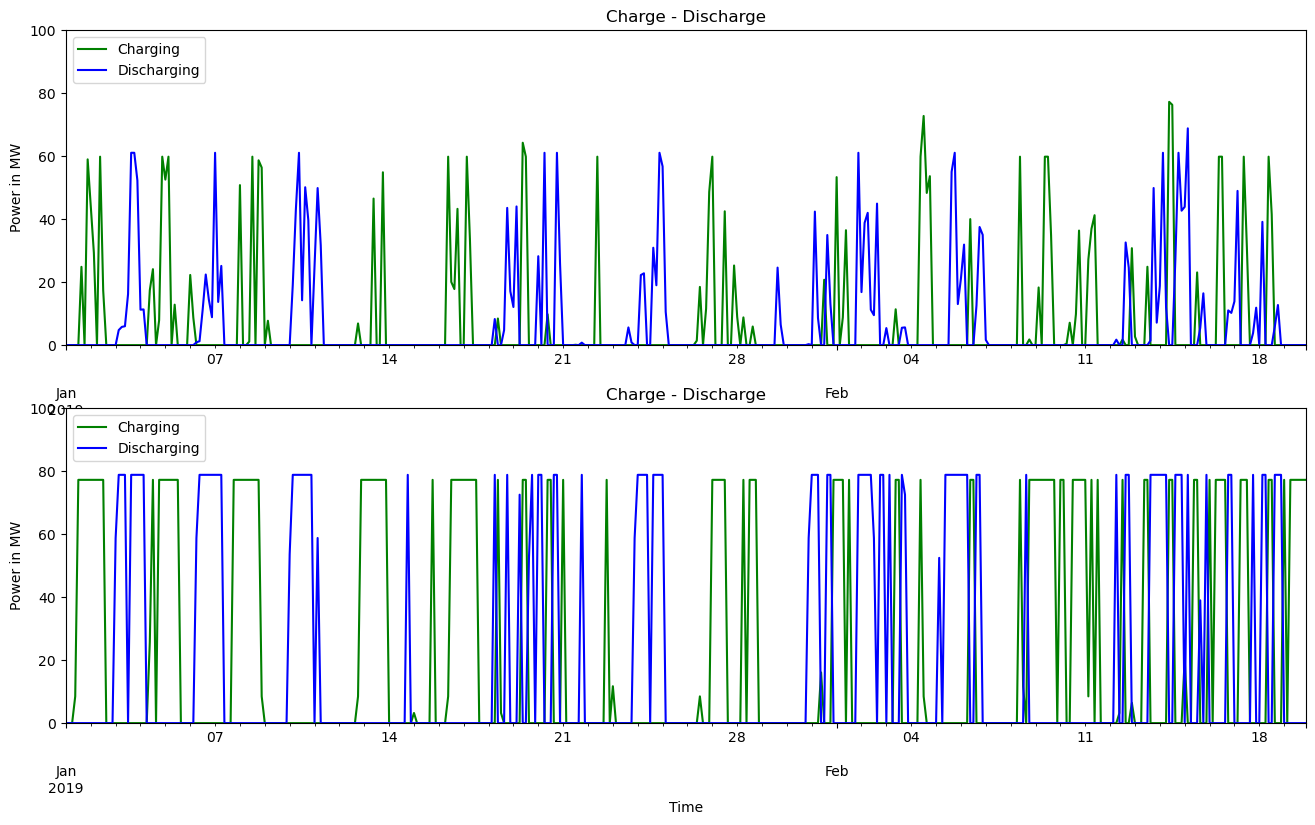

In [42]:
fig = plt.figure(figsize=(16,9))
plt.subplot(2,1,1)
plot_power_flow(n, np.arange(0,400))
plt.subplot(2,1,2)
plot_power_flow(m, np.arange(0,400))

<Axes: xlabel='Time', ylabel='Power in MW'>

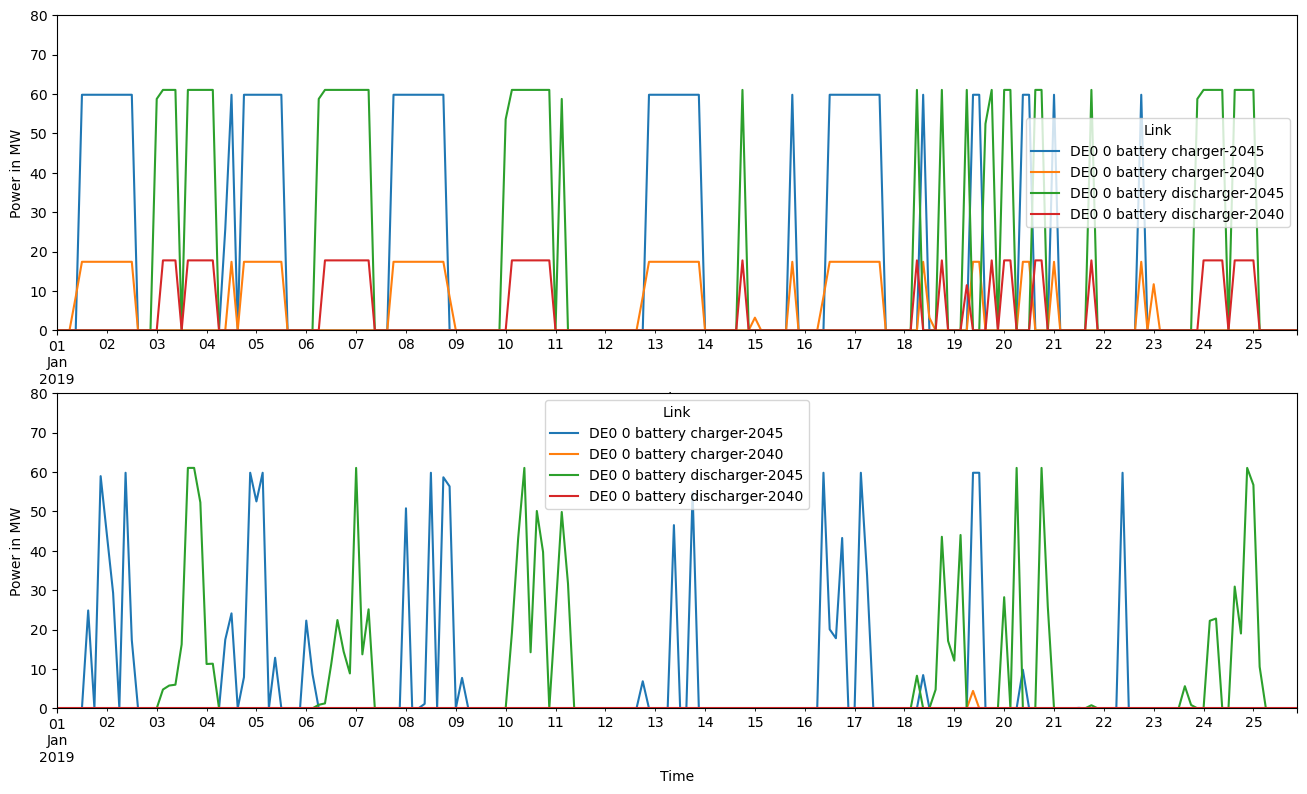

In [43]:

fig, ax = plt.subplots(2,1, figsize=(16, 9))

(m.links_t.p0[["DE0 0 battery charger-2045", "DE0 0 battery charger-2040", "DE0 0 battery discharger-2045", "DE0 0 battery discharger-2040"]][0:200]/1000).plot(
    ax= ax[0],
    ylim=(0,80),
    ylabel="Power in MW",
    xlabel="Time"
)

(n.links_t.p0[["DE0 0 battery charger-2045", "DE0 0 battery charger-2040", "DE0 0 battery discharger-2045", "DE0 0 battery discharger-2040"]][0:200]/1000).plot(
    ax= ax[1],
    ylim=(0, 80),
    ylabel="Power in MW",
    xlabel="Time"
)

In [44]:
# Beispiel: Charger-2045
def get_aktive_auslastung(n, link_name):

    aktive_leistung = n.links_t.p0[link_name][n.links_t.p0[link_name]>0].mean()
    aktive_auslastung = aktive_leistung / n.links.loc[link_name, "p_nom"]

    return aktive_auslastung

## Auslastung der Batterie Links:

In [45]:
print("Auslastung Charger:")
print("Battery charger 2040 profit-optimized:", get_aktive_auslastung(m, "DE0 0 battery charger-2040").round(2)*100)
print("Battery charger 2040 welfare-optimized:", get_aktive_auslastung(n, "DE0 0 battery charger-2040").round(2)*100)
print()
print("Battery charger 2045 profit-optimized:", get_aktive_auslastung(m, "DE0 0 battery charger-2045").round(2)*100)
print("Battery charger 2045 welfare-optimized:", get_aktive_auslastung(n, "DE0 0 battery charger-2045").round(2)*100)
print()
print("Discharger:")
print("Battery discharger 2040 profit-optimized:", get_aktive_auslastung(m, "DE0 0 battery discharger-2040").round(2)*100)
print("Battery discharger 2040 welfare-optimized:", get_aktive_auslastung(n, "DE0 0 battery discharger-2040").round(2)*100)
print()
print("Battery discharger 2045 profit-optimized:", get_aktive_auslastung(m, "DE0 0 battery discharger-2045").round(2)*100)
print("Battery discharger 2045 welfare-optimized:", get_aktive_auslastung(n, "DE0 0 battery discharger-2045").round(1)*100)



Auslastung Charger:
Battery charger 2040 profit-optimized: 97.0
Battery charger 2040 welfare-optimized: 91.0

Battery charger 2045 profit-optimized: 99.0
Battery charger 2045 welfare-optimized: 61.0

Discharger:
Battery discharger 2040 profit-optimized: 98.0
Battery discharger 2040 welfare-optimized: 47.0

Battery discharger 2045 profit-optimized: 99.0
Battery discharger 2045 welfare-optimized: 50.0


## Profitvergleich

In [46]:
def get_profit(n, price, start = 0, stop=1):

    # starting with the 2nd week
    start = start * 24
    stop = stop * 24
    discharge_2045 = n.links_t.p0["DE0 0 battery discharger-2045"]
    charge_2045 = n.links_t.p0["DE0 0 battery charger-2045"]
    discharge_2040 = n.links_t.p0["DE0 0 battery discharger-2040"]
    charge_2040 = n.links_t.p0["DE0 0 battery charger-2040"]


    expected_profit_45 = (-charge_2045[start:-stop] * price[start:-stop] * 1/n.links.efficiency["DE0 0 battery charger-2045"]  + discharge_2045[start:-stop] * price[start:-stop]).sum()
    expected_profit_40 = (-charge_2040[start:-stop] * price[start:-stop] * 1/n.links.efficiency["DE0 0 battery charger-2045"]  + discharge_2040[start:-stop] * price[start:-stop]).sum()

    return (expected_profit_45 + expected_profit_40)

In [47]:
preis = n.buses_t.marginal_price["DE0 0"]
print("Durchschnittspreis:",preis.mean().round(2), "€ pro MWh")

Durchschnittspreis: 114.78 € pro MWh


Profit welfare modell:

In [48]:
print((get_profit(n, preis, 0, 1) / 1e9).round(2), "Mrd. €")

2.03 Mrd. €


Profit profitoptimiertes Modell:

In [49]:
print((get_profit(m, preis, 0, 1) / 1e9).round(2), "Mrd. €")

74.05 Mrd. €


## Windmultiplikatoren

Multipliers zwischen 0 und 42% abweichung nach 144h

In [27]:
def smart_edge_biased_multipliers(x, E_max=0.42, H=30, step_hours=3,
                                   alpha_min=0.5, alpha_max=20):
    """
    Für jeden Punkt:
      - dev = Abweichung
      - alpha = steuert U-Form vs. Mittelkugel
    """
    np.random.seed(42)
    # Basis dev
    time_points = np.arange(48) * step_hours
    base_deviations = E_max * (1 - np.exp(-time_points / H))
    base_deviations[0] = 0

    deviations = base_deviations[:x]

    # Für jeden dev: alpha zwischen alpha_max und alpha_min mappen
    alphas = alpha_max - (deviations / E_max) * (alpha_max - alpha_min)

    # Ziehe Beta(alpha, alpha)
    u = np.array([beta.rvs(a, a) for a in alphas])

    # Mappe Beta(0,1) auf [1 - dev, 1 + dev]
    multipliers = (1 - deviations) + u * 2 * deviations

    return multipliers

# Beispiel
#np.random.seed(42)
wind_multiplikatoren_bsp = smart_edge_biased_multipliers(144)
print("Multiplikatoren (Beta-basiert, adaptiv, Randfreundlich):")
print(wind_multiplikatoren_bsp)


Multiplikatoren (Beta-basiert, adaptiv, Randfreundlich):
[1.         0.99999992 1.00699347 0.98570975 1.04310209 0.96761271
 1.04497005 0.97748269 0.98742833 1.04825282 1.09830398 0.91327018
 1.03178328 1.01246542 0.90006588 1.05424278 0.89595191 1.00757848
 0.94411469 0.96821146 0.95177514 1.11600859 0.8415509  1.05104335
 0.92306686 0.94708032 1.07626448 0.88088083 0.92629122 1.00576835
 0.76795659 0.89550861 1.06562    0.62198375 0.7022125  0.88918371
 1.0687152  0.88977902 0.65919629 1.121009   0.62259502 1.40402407
 1.19594288 1.28751802 1.15491916 1.36190031 1.27388922 0.75020062]


Funktion die die constraints mit den multipliern multipliziert, bisher nur onwind

In [29]:
# Wrapper Funktion um cf übergeben zu können
def make_cf_scaler():
    # eigentliche funktion zum ändern der Constraints
    def change_cf(n, sns):
        rhs = n.model.constraints["Generator-fix-p-upper"].rhs
        years = [2045, 2040, 2035, 2030, 2025, 2020]

        for year in years:
            selector = {"Generator-fix": f"DE0 0 onwind-{year}"}
            rhs.loc[selector] = rhs.loc[selector] * smart_edge_biased_multipliers(len(sns))

    return change_cf

In [30]:
n_wind_noise = pypsa.Network('base_s_1__none_2045_lt.nc')
n_wind_noise.optimize.fix_optimal_capacities()
n_wind_noise.optimize.create_model()

#
#
#
#

n_wind_noise.optimize.optimize_with_rolling_horizon(
    solver_name = "gurobi",
    horizon = 48,
    overlap = 8,
    extra_functionality=make_cf_scaler(0.42)
)

INFO:pypsa.io:Imported network base_s_1__none_2045_lt.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores
{'EU', 'DE'}
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-01 00:00:00:2019-01-06 21:00:00] (1/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 253.89it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bd3ycsg8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bd3ycsg8.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe6034a43


INFO:gurobipy:Model fingerprint: 0xe6034a43


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4432 columns


INFO:gurobipy:Presolve removed 22641 rows and 4432 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1072 rows, 7280 columns, 14540 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7280 columns, 14540 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.03314795e+11 -1.47184182e+13  1.53e+06 6.86e+01  4.30e+09     0s


INFO:gurobipy:   0   2.03314795e+11 -1.47184182e+13  1.53e+06 6.86e+01  4.30e+09     0s


   1   2.79693868e+10 -1.01784593e+12  1.29e+05 4.66e-11  3.32e+08     0s


INFO:gurobipy:   1   2.79693868e+10 -1.01784593e+12  1.29e+05 4.66e-11  3.32e+08     0s


   2   7.81031032e+09 -2.30875148e+11  8.80e+03 1.68e-09  3.15e+07     0s


INFO:gurobipy:   2   7.81031032e+09 -2.30875148e+11  8.80e+03 1.68e-09  3.15e+07     0s


   3   2.38883753e+09 -5.19812200e+10  7.48e+02 7.59e-10  4.65e+06     0s


INFO:gurobipy:   3   2.38883753e+09 -5.19812200e+10  7.48e+02 7.59e-10  4.65e+06     0s


   4   1.09299991e+09 -9.80515500e+09  8.62e+01 1.45e-09  8.10e+05     0s


INFO:gurobipy:   4   1.09299991e+09 -9.80515500e+09  8.62e+01 1.45e-09  8.10e+05     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1709    2.6897618e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1709    2.6897618e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1709 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1709 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.689761796e+08


INFO:gurobipy:Optimal objective  2.689761796e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.69e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-06 00:00:00:2019-01-11 21:00:00] (2/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 253.36it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vmx00nq7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vmx00nq7.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfb2af521


INFO:gurobipy:Model fingerprint: 0xfb2af521


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4434 columns


INFO:gurobipy:Presolve removed 22641 rows and 4434 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7278 columns, 14541 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7278 columns, 14541 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.86457349e+11 -1.47409690e+13  2.20e+06 6.27e+01  5.73e+09     0s


INFO:gurobipy:   0   2.86457349e+11 -1.47409690e+13  2.20e+06 6.27e+01  5.73e+09     0s


   1   3.63253035e+10 -1.22963209e+12  1.87e+05 4.70e-11  4.68e+08     0s


INFO:gurobipy:   1   3.63253035e+10 -1.22963209e+12  1.87e+05 4.70e-11  4.68e+08     0s


   2   8.75026653e+09 -2.93207526e+11  1.12e+04 1.23e-09  4.07e+07     0s


INFO:gurobipy:   2   8.75026653e+09 -2.93207526e+11  1.12e+04 1.23e-09  4.07e+07     0s


   3   5.69397341e+09 -6.74408479e+10  1.56e+03 4.54e-10  7.14e+06     0s


INFO:gurobipy:   3   5.69397341e+09 -6.74408479e+10  1.56e+03 4.54e-10  7.14e+06     0s


   4   2.52215137e+09 -2.31269049e+10  5.05e+02 1.33e-09  2.24e+06     0s


INFO:gurobipy:   4   2.52215137e+09 -2.31269049e+10  5.05e+02 1.33e-09  2.24e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1728    3.5927576e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1728    3.5927576e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1728 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1728 iterations and 0.10 seconds (0.06 work units)


Optimal objective  3.592757610e+08


INFO:gurobipy:Optimal objective  3.592757610e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.59e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-11 00:00:00:2019-01-16 21:00:00] (3/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 71.77it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-00ytsfvj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-00ytsfvj.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3fa8aafb


INFO:gurobipy:Model fingerprint: 0x3fa8aafb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4434 columns


INFO:gurobipy:Presolve removed 22641 rows and 4434 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7278 columns, 14541 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7278 columns, 14541 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.69130336e+11 -1.47693794e+13  2.87e+06 7.31e+01  7.16e+09     0s


INFO:gurobipy:   0   3.69130336e+11 -1.47693794e+13  2.87e+06 7.31e+01  7.16e+09     0s


   1   4.45329508e+10 -1.30815793e+12  2.42e+05 4.94e-11  5.89e+08     0s


INFO:gurobipy:   1   4.45329508e+10 -1.30815793e+12  2.42e+05 4.94e-11  5.89e+08     0s


   2   7.86066512e+09 -3.50645463e+11  1.13e+04 2.41e-09  4.50e+07     0s


INFO:gurobipy:   2   7.86066512e+09 -3.50645463e+11  1.13e+04 2.41e-09  4.50e+07     0s


   3   2.32844152e+09 -7.96983566e+10  1.58e+03 3.81e-10  7.65e+06     0s


INFO:gurobipy:   3   2.32844152e+09 -7.96983566e+10  1.58e+03 3.81e-10  7.65e+06     0s


   4   9.38568302e+08 -1.17869725e+10  1.38e+02 1.43e-09  9.75e+05     0s


INFO:gurobipy:   4   9.38568302e+08 -1.17869725e+10  1.38e+02 1.43e-09  9.75e+05     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1846    2.1504108e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1846    2.1504108e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1846 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1846 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.150410837e+08


INFO:gurobipy:Optimal objective  2.150410837e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-16 00:00:00:2019-01-21 21:00:00] (4/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 252.56it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2mcn9z3c.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2mcn9z3c.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xaef0404f


INFO:gurobipy:Model fingerprint: 0xaef0404f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4521 columns


INFO:gurobipy:Presolve removed 22641 rows and 4521 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7191 columns, 14371 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7191 columns, 14371 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 3 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.34890449e+11 -1.47865760e+13  3.44e+06 6.76e+01  8.40e+09     0s


INFO:gurobipy:   0   4.34890449e+11 -1.47865760e+13  3.44e+06 6.76e+01  8.40e+09     0s


   1   5.25542555e+10 -1.42591917e+12  2.96e+05 5.04e-11  7.11e+08     0s


INFO:gurobipy:   1   5.25542555e+10 -1.42591917e+12  2.96e+05 5.04e-11  7.11e+08     0s


   2   1.05583641e+10 -3.69106674e+11  1.60e+04 1.27e-09  5.62e+07     0s


INFO:gurobipy:   2   1.05583641e+10 -3.69106674e+11  1.60e+04 1.27e-09  5.62e+07     0s


   3   1.20119226e+10 -8.48425101e+10  3.70e+03 1.39e-09  1.23e+07     0s


INFO:gurobipy:   3   1.20119226e+10 -8.48425101e+10  3.70e+03 1.39e-09  1.23e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Extra simplex iterations after uncrush: 7


INFO:gurobipy:Extra simplex iterations after uncrush: 7


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1778    3.2512182e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1778    3.2512182e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1778 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1778 iterations and 0.10 seconds (0.06 work units)


Optimal objective  3.251218152e+09


INFO:gurobipy:Optimal objective  3.251218152e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.25e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-21 00:00:00:2019-01-26 21:00:00] (5/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 205.52it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uhkce402.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-uhkce402.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x9cb7645c


INFO:gurobipy:Model fingerprint: 0x9cb7645c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4639 columns


INFO:gurobipy:Presolve removed 22642 rows and 4639 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7073 columns, 14180 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7073 columns, 14180 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 3 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.37595774e+11 -1.47857691e+13  4.31e+06 1.31e+02  1.03e+10     0s


INFO:gurobipy:   0   5.37595774e+11 -1.47857691e+13  4.31e+06 1.31e+02  1.03e+10     0s


   1   6.34004245e+10 -1.59685351e+12  3.67e+05 5.37e-11  8.74e+08     0s


INFO:gurobipy:   1   6.34004245e+10 -1.59685351e+12  3.67e+05 5.37e-11  8.74e+08     0s


   2   1.24558467e+10 -4.06051992e+11  2.07e+04 1.40e-09  6.87e+07     0s


INFO:gurobipy:   2   1.24558467e+10 -4.06051992e+11  2.07e+04 1.40e-09  6.87e+07     0s


   3   1.59886786e+10 -1.55958322e+11  5.65e+03 1.17e-09  2.19e+07     0s


INFO:gurobipy:   3   1.59886786e+10 -1.55958322e+11  5.65e+03 1.17e-09  2.19e+07     0s


   4   1.83068233e+10 -4.80083557e+10  2.12e+03 9.01e-10  7.78e+06     0s


INFO:gurobipy:   4   1.83068233e+10 -4.80083557e+10  2.12e+03 9.01e-10  7.78e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1733    1.5775672e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1733    1.5775672e+10   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1733 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1733 iterations and 0.12 seconds (0.06 work units)


Optimal objective  1.577567249e+10


INFO:gurobipy:Optimal objective  1.577567249e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.58e+10
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-26 00:00:00:2019-01-31 21:00:00] (6/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 251.36it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ctsag2vl.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ctsag2vl.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x277a4473


INFO:gurobipy:Model fingerprint: 0x277a4473


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4424 columns


INFO:gurobipy:Presolve removed 22641 rows and 4424 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7288 columns, 14536 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7288 columns, 14536 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.54920283e+11 -1.47883218e+13  5.19e+06 6.86e+01  1.21e+10     0s


INFO:gurobipy:   0   6.54920283e+11 -1.47883218e+13  5.19e+06 6.86e+01  1.21e+10     0s


   1   7.46844113e+10 -1.75955324e+12  4.42e+05 5.40e-11  1.04e+09     0s


INFO:gurobipy:   1   7.46844113e+10 -1.75955324e+12  4.42e+05 5.40e-11  1.04e+09     0s


   2   1.02464186e+10 -4.68977894e+11  1.64e+04 4.18e-09  6.41e+07     0s


INFO:gurobipy:   2   1.02464186e+10 -4.68977894e+11  1.64e+04 4.18e-09  6.41e+07     0s


   3   7.36079410e+09 -8.72999324e+10  2.36e+03 5.78e-10  9.97e+06     0s


INFO:gurobipy:   3   7.36079410e+09 -8.72999324e+10  2.36e+03 5.78e-10  9.97e+06     0s


   4   2.22795929e+09 -3.30642683e+10  6.31e+02 3.55e-10  3.11e+06     0s


INFO:gurobipy:   4   2.22795929e+09 -3.30642683e+10  6.31e+02 3.55e-10  3.11e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1823    4.4406344e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1823    4.4406344e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1823 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1823 iterations and 0.10 seconds (0.05 work units)


Optimal objective  4.440634428e+08


INFO:gurobipy:Optimal objective  4.440634428e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.44e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-01-31 00:00:00:2019-02-05 21:00:00] (7/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 252.03it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0qljc9f2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0qljc9f2.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xb8a4501b


INFO:gurobipy:Model fingerprint: 0xb8a4501b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4412 columns


INFO:gurobipy:Presolve removed 22641 rows and 4412 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7300 columns, 14554 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7300 columns, 14554 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.77337282e+11 -1.48064264e+13  6.18e+06 6.50e+01  1.43e+10     0s


INFO:gurobipy:   0   7.77337282e+11 -1.48064264e+13  6.18e+06 6.50e+01  1.43e+10     0s


   1   8.76187051e+10 -1.92699184e+12  5.34e+05 4.66e-11  1.25e+09     0s


INFO:gurobipy:   1   8.76187051e+10 -1.92699184e+12  5.34e+05 4.66e-11  1.25e+09     0s


   2   1.11422189e+10 -5.02060731e+11  1.92e+04 2.26e-09  7.21e+07     0s


INFO:gurobipy:   2   1.11422189e+10 -5.02060731e+11  1.92e+04 2.26e-09  7.21e+07     0s


   3   1.11939724e+10 -1.24988097e+11  2.85e+03 9.34e-10  1.39e+07     0s


INFO:gurobipy:   3   1.11939724e+10 -1.24988097e+11  2.85e+03 9.34e-10  1.39e+07     0s


   4   7.36215967e+09 -2.69465212e+10  3.28e+02 1.17e-09  2.74e+06     0s


INFO:gurobipy:   4   7.36215967e+09 -2.69465212e+10  3.28e+02 1.17e-09  2.74e+06     0s


   5   3.88324364e+09 -7.30643054e+09  8.50e+01 3.80e-10  8.45e+05     0s


INFO:gurobipy:   5   3.88324364e+09 -7.30643054e+09  8.50e+01 3.80e-10  8.45e+05     0s


   6   2.76083622e+09 -1.57063477e+09  3.44e+01 2.64e-10  3.27e+05     0s


INFO:gurobipy:   6   2.76083622e+09 -1.57063477e+09  3.44e+01 2.64e-10  3.27e+05     0s


   7   2.26294344e+09  1.32040615e+08  1.77e+01 2.06e-10  1.61e+05     0s


INFO:gurobipy:   7   2.26294344e+09  1.32040615e+08  1.77e+01 2.06e-10  1.61e+05     0s


   8   1.74094693e+09  7.78668253e+08  3.24e+00 2.06e-10  6.88e+04     0s


INFO:gurobipy:   8   1.74094693e+09  7.78668253e+08  3.24e+00 2.06e-10  6.88e+04     0s


   9   1.65153379e+09  1.12764550e+09  1.48e+00 1.47e-10  3.73e+04     0s


INFO:gurobipy:   9   1.65153379e+09  1.12764550e+09  1.48e+00 1.47e-10  3.73e+04     0s


INFO:gurobipy:


Barrier performed 9 iterations in 0.09 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 9 iterations in 0.09 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2219    1.5548078e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2219    1.5548078e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2219 iterations and 0.11 seconds (0.07 work units)


INFO:gurobipy:Solved in 2219 iterations and 0.11 seconds (0.07 work units)


Optimal objective  1.554807806e+09


INFO:gurobipy:Optimal objective  1.554807806e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 1.55e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-05 00:00:00:2019-02-10 21:00:00] (8/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 253.37it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-01p3bz3a.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-01p3bz3a.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4d52b2fa


INFO:gurobipy:Model fingerprint: 0x4d52b2fa


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4391 columns


INFO:gurobipy:Presolve removed 22641 rows and 4391 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7321 columns, 14584 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7321 columns, 14584 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.97871035e+11 -1.48371149e+13  7.13e+06 6.38e+01  1.63e+10     0s


INFO:gurobipy:   0   8.97871035e+11 -1.48371149e+13  7.13e+06 6.38e+01  1.63e+10     0s


   1   1.00986464e+11 -2.09050863e+12  6.15e+05 5.08e-11  1.43e+09     0s


INFO:gurobipy:   1   1.00986464e+11 -2.09050863e+12  6.15e+05 5.08e-11  1.43e+09     0s


   2   1.02778492e+10 -5.43466725e+11  2.01e+04 2.26e-09  7.67e+07     0s


INFO:gurobipy:   2   1.02778492e+10 -5.43466725e+11  2.01e+04 2.26e-09  7.67e+07     0s


   3   4.66491261e+09 -1.15492832e+11  2.64e+03 1.05e-09  1.19e+07     0s


INFO:gurobipy:   3   4.66491261e+09 -1.15492832e+11  2.64e+03 1.05e-09  1.19e+07     0s


   4   1.74608273e+09 -5.23553810e+10  8.92e+02 4.10e-10  4.66e+06     0s


INFO:gurobipy:   4   1.74608273e+09 -5.23553810e+10  8.92e+02 4.10e-10  4.66e+06     0s


   5   9.15357348e+08 -1.20734437e+10  9.58e+01 9.25e-11  9.53e+05     0s


INFO:gurobipy:   5   9.15357348e+08 -1.20734437e+10  9.58e+01 9.25e-11  9.53e+05     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.08 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.08 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2010    2.1688400e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2010    2.1688400e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2010 iterations and 0.16 seconds (0.06 work units)


INFO:gurobipy:Solved in 2010 iterations and 0.16 seconds (0.06 work units)


Optimal objective  2.168840012e+08


INFO:gurobipy:Optimal objective  2.168840012e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.17e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-10 00:00:00:2019-02-15 21:00:00] (9/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 256.07it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ncenlcch.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ncenlcch.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7a0c7f39


INFO:gurobipy:Model fingerprint: 0x7a0c7f39


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4383 columns


INFO:gurobipy:Presolve removed 22641 rows and 4383 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 1072 rows, 7329 columns, 14592 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7329 columns, 14592 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.87211727e+12 -1.60782881e+13  3.11e+07 6.31e+01  6.77e+10     0s


INFO:gurobipy:   0   3.87211727e+12 -1.60782881e+13  3.11e+07 6.31e+01  6.77e+10     0s


   1   1.03480786e+12 -4.61786520e+12  7.76e+06 4.67e-11  1.69e+10     0s


INFO:gurobipy:   1   1.03480786e+12 -4.61786520e+12  7.76e+06 4.67e-11  1.69e+10     0s


   2   4.56896432e+10 -2.08646911e+12  2.79e+05 5.39e-11  7.34e+08     0s


INFO:gurobipy:   2   4.56896432e+10 -2.08646911e+12  2.79e+05 5.39e-11  7.34e+08     0s


   3   8.06233869e+09 -5.04065747e+11  1.54e+04 2.12e-10  6.43e+07     0s


INFO:gurobipy:   3   8.06233869e+09 -5.04065747e+11  1.54e+04 2.12e-10  6.43e+07     0s


   4   4.26476730e+09 -1.35642586e+11  3.08e+03 2.41e-10  1.40e+07     0s


INFO:gurobipy:   4   4.26476730e+09 -1.35642586e+11  3.08e+03 2.41e-10  1.40e+07     0s


   5   1.20924842e+09 -5.93024774e+10  9.21e+02 8.13e-11  5.15e+06     0s


INFO:gurobipy:   5   1.20924842e+09 -5.93024774e+10  9.21e+02 8.13e-11  5.15e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.16 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.16 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1940    2.1551006e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1940    2.1551006e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1940 iterations and 0.18 seconds (0.06 work units)


INFO:gurobipy:Solved in 1940 iterations and 0.18 seconds (0.06 work units)


Optimal objective  2.155100623e+08


INFO:gurobipy:Optimal objective  2.155100623e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.16e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-15 00:00:00:2019-02-20 21:00:00] (10/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.07it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n0tcrgio.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-n0tcrgio.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x69fc0b1a


INFO:gurobipy:Model fingerprint: 0x69fc0b1a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4370 columns


INFO:gurobipy:Presolve removed 22641 rows and 4370 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7342 columns, 14605 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7342 columns, 14605 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24595149e+12 -1.83280989e+13  3.41e+07 6.28e+01  7.41e+10     0s


INFO:gurobipy:   0   4.24595149e+12 -1.83280989e+13  3.41e+07 6.28e+01  7.41e+10     0s


   1   8.34362473e+11 -5.23318270e+12  6.03e+06 2.69e+02  1.31e+10     0s


INFO:gurobipy:   1   8.34362473e+11 -5.23318270e+12  6.03e+06 2.69e+02  1.31e+10     0s


   2   8.15544682e+10 -1.74544384e+12  5.28e+05 1.91e-09  1.22e+09     0s


INFO:gurobipy:   2   8.15544682e+10 -1.74544384e+12  5.28e+05 1.91e-09  1.22e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1722    2.1457315e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1722    2.1457315e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1722 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1722 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.145731534e+08


INFO:gurobipy:Optimal objective  2.145731534e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-20 00:00:00:2019-02-25 21:00:00] (11/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 240.10it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oqsidi7_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oqsidi7_.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x23b36e0e


INFO:gurobipy:Model fingerprint: 0x23b36e0e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4375 columns


INFO:gurobipy:Presolve removed 22641 rows and 4375 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7337 columns, 14600 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7337 columns, 14600 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27264069e+12 -1.83165943e+13  3.43e+07 6.97e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27264069e+12 -1.83165943e+13  3.43e+07 6.97e+01  7.46e+10     0s


   1   8.03050217e+11 -5.31469505e+12  5.78e+06 4.70e+02  1.26e+10     0s


INFO:gurobipy:   1   8.03050217e+11 -5.31469505e+12  5.78e+06 4.70e+02  1.26e+10     0s


   2   7.94497813e+10 -1.73683243e+12  5.08e+05 8.13e-11  1.18e+09     0s


INFO:gurobipy:   2   7.94497813e+10 -1.73683243e+12  5.08e+05 8.13e-11  1.18e+09     0s


   3   1.06746010e+10 -4.29482250e+11  1.64e+04 4.01e-10  6.15e+07     0s


INFO:gurobipy:   3   1.06746010e+10 -4.29482250e+11  1.64e+04 4.01e-10  6.15e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1801    3.5822032e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1801    3.5822032e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1801 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1801 iterations and 0.10 seconds (0.06 work units)


Optimal objective  3.582203175e+08


INFO:gurobipy:Optimal objective  3.582203175e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.58e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-02-25 00:00:00:2019-03-02 21:00:00] (12/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 248.04it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0mq3em3m.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0mq3em3m.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x562558b5


INFO:gurobipy:Model fingerprint: 0x562558b5


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4384 columns


INFO:gurobipy:Presolve removed 22642 rows and 4384 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1071 rows, 7328 columns, 14590 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7328 columns, 14590 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27472169e+12 -1.82622708e+13  3.43e+07 8.05e+01  7.47e+10     0s


INFO:gurobipy:   0   4.27472169e+12 -1.82622708e+13  3.43e+07 8.05e+01  7.47e+10     0s


   1   8.02185961e+11 -5.26724351e+12  5.74e+06 3.69e+02  1.25e+10     0s


INFO:gurobipy:   1   8.02185961e+11 -5.26724351e+12  5.74e+06 3.69e+02  1.25e+10     0s


   2   7.88067658e+10 -1.73769296e+12  5.02e+05 5.15e-09  1.17e+09     0s


INFO:gurobipy:   2   7.88067658e+10 -1.73769296e+12  5.02e+05 5.15e-09  1.17e+09     0s


   3   1.01133112e+10 -4.21291572e+11  1.28e+04 4.49e-09  5.40e+07     0s


INFO:gurobipy:   3   1.01133112e+10 -4.21291572e+11  1.28e+04 4.49e-09  5.40e+07     0s


   4   9.19556314e+09 -1.34908697e+11  2.95e+03 1.06e-09  1.44e+07     0s


INFO:gurobipy:   4   9.19556314e+09 -1.34908697e+11  2.95e+03 1.06e-09  1.44e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1666    3.7116141e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1666    3.7116141e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1666 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1666 iterations and 0.10 seconds (0.06 work units)


Optimal objective  3.711614137e+08


INFO:gurobipy:Optimal objective  3.711614137e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.71e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-02 00:00:00:2019-03-07 21:00:00] (13/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.31it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_6w454rn.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_6w454rn.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7de4263d


INFO:gurobipy:Model fingerprint: 0x7de4263d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4374 columns


INFO:gurobipy:Presolve removed 22641 rows and 4374 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7338 columns, 14601 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7338 columns, 14601 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.02082814e+12 -1.86683870e+13  3.23e+07 6.61e+01  7.03e+10     0s


INFO:gurobipy:   0   4.02082814e+12 -1.86683870e+13  3.23e+07 6.61e+01  7.03e+10     0s


   1   6.89536421e+11 -5.26164723e+12  4.92e+06 7.05e+02  1.07e+10     0s


INFO:gurobipy:   1   6.89536421e+11 -5.26164723e+12  4.92e+06 7.05e+02  1.07e+10     0s


   2   6.53736468e+10 -1.71757853e+12  4.12e+05 7.58e-11  9.75e+08     0s


INFO:gurobipy:   2   6.53736468e+10 -1.71757853e+12  4.12e+05 7.58e-11  9.75e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1817    2.1425717e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1817    2.1425717e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1817 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1817 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.142571669e+08


INFO:gurobipy:Optimal objective  2.142571669e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-07 00:00:00:2019-03-12 21:00:00] (14/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 253.45it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c9zdq2d8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c9zdq2d8.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa91897e9


INFO:gurobipy:Model fingerprint: 0xa91897e9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 4e+02]


INFO:gurobipy:  Bounds range     [4e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4371 columns


INFO:gurobipy:Presolve removed 22641 rows and 4371 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1072 rows, 7341 columns, 14604 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7341 columns, 14604 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.01442631e+12 -1.80236683e+13  3.22e+07 6.31e+01  7.01e+10     0s


INFO:gurobipy:   0   4.01442631e+12 -1.80236683e+13  3.22e+07 6.31e+01  7.01e+10     0s


   1   6.91736256e+11 -5.11530871e+12  4.93e+06 5.89e+02  1.08e+10     0s


INFO:gurobipy:   1   6.91736256e+11 -5.11530871e+12  4.93e+06 5.89e+02  1.08e+10     0s


   2   5.85395743e+10 -1.77525050e+12  3.63e+05 5.32e-10  8.76e+08     0s


INFO:gurobipy:   2   5.85395743e+10 -1.77525050e+12  3.63e+05 5.32e-10  8.76e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1751    2.1437177e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1751    2.1437177e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1751 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1751 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.143717739e+08


INFO:gurobipy:Optimal objective  2.143717739e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-12 00:00:00:2019-03-17 21:00:00] (15/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 253.14it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ojvzdg9q.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ojvzdg9q.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xb45b9652


INFO:gurobipy:Model fingerprint: 0xb45b9652


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 6e+02]


INFO:gurobipy:  Bounds range     [4e+02, 6e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4372 columns


INFO:gurobipy:Presolve removed 22641 rows and 4372 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1072 rows, 7340 columns, 14603 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7340 columns, 14603 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27316558e+12 -1.80327016e+13  3.43e+07 6.34e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27316558e+12 -1.80327016e+13  3.43e+07 6.34e+01  7.46e+10     0s


   1   4.85744804e+11 -5.59639873e+12  3.18e+06 1.52e+03  7.12e+09     0s


INFO:gurobipy:   1   4.85744804e+11 -5.59639873e+12  3.18e+06 1.52e+03  7.12e+09     0s


   2   5.14448258e+10 -1.59953627e+12  2.93e+05 4.94e+01  7.21e+08     0s


INFO:gurobipy:   2   5.14448258e+10 -1.59953627e+12  2.93e+05 4.94e+01  7.21e+08     0s


   3   6.60305937e+09 -3.55754406e+11  6.43e+03 1.78e-09  3.65e+07     0s


INFO:gurobipy:   3   6.60305937e+09 -3.55754406e+11  6.43e+03 1.78e-09  3.65e+07     0s


   4   8.94349325e+08 -1.14621381e+11  4.50e+02 4.34e-10  8.42e+06     0s


INFO:gurobipy:   4   8.94349325e+08 -1.14621381e+11  4.50e+02 4.34e-10  8.42e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1905    2.1450719e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1905    2.1450719e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1905 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1905 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.145071945e+08


INFO:gurobipy:Optimal objective  2.145071945e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-17 00:00:00:2019-03-22 21:00:00] (16/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 250.62it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-erh2nj45.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-erh2nj45.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc9e50833


INFO:gurobipy:Model fingerprint: 0xc9e50833


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [6e+02, 7e+02]


INFO:gurobipy:  Bounds range     [6e+02, 7e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4382 columns


INFO:gurobipy:Presolve removed 22641 rows and 4382 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7330 columns, 14593 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7330 columns, 14593 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.00968766e+12 -1.85964280e+13  3.22e+07 6.73e+01  7.01e+10     0s


INFO:gurobipy:   0   4.00968766e+12 -1.85964280e+13  3.22e+07 6.73e+01  7.01e+10     0s


   1   6.81224335e+11 -5.19356353e+12  4.86e+06 5.43e+02  1.06e+10     0s


INFO:gurobipy:   1   6.81224335e+11 -5.19356353e+12  4.86e+06 5.43e+02  1.06e+10     0s


   2   5.66422295e+10 -1.72501182e+12  3.46e+05 3.84e-09  8.38e+08     0s


INFO:gurobipy:   2   5.66422295e+10 -1.72501182e+12  3.46e+05 3.84e-09  8.38e+08     0s


   3   9.04475654e+09 -3.69478491e+11  1.35e+04 2.92e-10  5.10e+07     0s


INFO:gurobipy:   3   9.04475654e+09 -3.69478491e+11  1.35e+04 2.92e-10  5.10e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1717    2.1514876e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1717    2.1514876e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1717 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1717 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.151487554e+08


INFO:gurobipy:Optimal objective  2.151487554e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-22 00:00:00:2019-03-27 21:00:00] (17/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 250.20it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-v10kjuq9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-v10kjuq9.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xee5918ed


INFO:gurobipy:Model fingerprint: 0xee5918ed


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 7e+02]


INFO:gurobipy:  Bounds range     [5e+02, 7e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4386 columns


INFO:gurobipy:Presolve removed 22641 rows and 4386 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7326 columns, 14589 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7326 columns, 14589 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24638637e+12 -1.83280636e+13  3.41e+07 8.56e+01  7.42e+10     0s


INFO:gurobipy:   0   4.24638637e+12 -1.83280636e+13  3.41e+07 8.56e+01  7.42e+10     0s


   1   6.97124065e+11 -5.22881043e+12  4.91e+06 2.67e+02  1.07e+10     0s


INFO:gurobipy:   1   6.97124065e+11 -5.22881043e+12  4.91e+06 2.67e+02  1.07e+10     0s


   2   5.33586478e+10 -1.72877460e+12  3.18e+05 6.68e-11  7.79e+08     0s


INFO:gurobipy:   2   5.33586478e+10 -1.72877460e+12  3.18e+05 6.68e-11  7.79e+08     0s


   3   9.39717313e+09 -3.45011148e+11  1.38e+04 2.49e-10  4.97e+07     0s


INFO:gurobipy:   3   9.39717313e+09 -3.45011148e+11  1.38e+04 2.49e-10  4.97e+07     0s


   4   4.76950708e+09 -9.19838720e+10  1.06e+03 9.23e-10  8.10e+06     0s


INFO:gurobipy:   4   4.76950708e+09 -9.19838720e+10  1.06e+03 9.23e-10  8.10e+06     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1698    2.1438911e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1698    2.1438911e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1698 iterations and 0.12 seconds (0.06 work units)


INFO:gurobipy:Solved in 1698 iterations and 0.12 seconds (0.06 work units)


Optimal objective  2.143891109e+08


INFO:gurobipy:Optimal objective  2.143891109e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-03-27 00:00:00:2019-04-01 21:00:00] (18/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 250.30it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4nfg_p23.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4nfg_p23.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x00b84042


INFO:gurobipy:Model fingerprint: 0x00b84042


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22639 rows and 4373 columns


INFO:gurobipy:Presolve removed 22639 rows and 4373 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1074 rows, 7339 columns, 14604 nonzeros


INFO:gurobipy:Presolved: 1074 rows, 7339 columns, 14604 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.801e+03


INFO:gurobipy: AA' NZ     : 2.801e+03


 Factor NZ  : 2.104e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.104e+04 (roughly 4 MB of memory)


 Factor Ops : 5.867e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.867e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24723174e+12 -1.83207089e+13  3.41e+07 6.75e+01  7.41e+10     0s


INFO:gurobipy:   0   4.24723174e+12 -1.83207089e+13  3.41e+07 6.75e+01  7.41e+10     0s


   1   6.74591428e+11 -5.20622608e+12  4.71e+06 2.03e+02  1.03e+10     0s


INFO:gurobipy:   1   6.74591428e+11 -5.20622608e+12  4.71e+06 2.03e+02  1.03e+10     0s


   2   5.01647984e+10 -1.69324116e+12  2.94e+05 1.22e-09  7.25e+08     0s


INFO:gurobipy:   2   5.01647984e+10 -1.69324116e+12  2.94e+05 1.22e-09  7.25e+08     0s


   3   9.28757963e+09 -3.25134264e+11  1.37e+04 1.28e-09  4.80e+07     0s


INFO:gurobipy:   3   9.28757963e+09 -3.25134264e+11  1.37e+04 1.28e-09  4.80e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1656    2.1475171e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1656    2.1475171e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1656 iterations and 0.10 seconds (0.06 work units)


INFO:gurobipy:Solved in 1656 iterations and 0.10 seconds (0.06 work units)


Optimal objective  2.147517133e+08


INFO:gurobipy:Optimal objective  2.147517133e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-01 00:00:00:2019-04-06 21:00:00] (19/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 249.52it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bpnp_y93.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bpnp_y93.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xe5469dc9


INFO:gurobipy:Model fingerprint: 0xe5469dc9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4363 columns


INFO:gurobipy:Presolve removed 22638 rows and 4363 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7349 columns, 14615 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7349 columns, 14615 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27559125e+12 -1.83483414e+13  3.43e+07 6.59e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27559125e+12 -1.83483414e+13  3.43e+07 6.59e+01  7.46e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1290    3.1508903e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1290    3.1508903e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1290 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1290 iterations and 0.10 seconds (0.05 work units)


Optimal objective  3.150890331e+08


INFO:gurobipy:Optimal objective  3.150890331e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-06 00:00:00:2019-04-11 21:00:00] (20/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 261.10it/s]
INFO:linopy.io: Writing time: 0.22s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wcz6p0vp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wcz6p0vp.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0ac48844


INFO:gurobipy:Model fingerprint: 0x0ac48844


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [5e+02, 5e+02]


INFO:gurobipy:  Bounds range     [5e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4349 columns


INFO:gurobipy:Presolve removed 22636 rows and 4349 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7363 columns, 14631 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7363 columns, 14631 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27353878e+12 -1.81369893e+13  3.43e+07 6.30e+01  7.45e+10     0s


INFO:gurobipy:   0   4.27353878e+12 -1.81369893e+13  3.43e+07 6.30e+01  7.45e+10     0s


   1   4.53782267e+11 -5.27070847e+12  2.96e+06 3.75e+02  6.61e+09     0s


INFO:gurobipy:   1   4.53782267e+11 -5.27070847e+12  2.96e+06 3.75e+02  6.61e+09     0s


   2   3.28273829e+10 -1.44965422e+12  1.65e+05 1.99e+00  4.40e+08     0s


INFO:gurobipy:   2   3.28273829e+10 -1.44965422e+12  1.65e+05 1.99e+00  4.40e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1514    2.1422457e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1514    2.1422457e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1514 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1514 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.142245706e+08


INFO:gurobipy:Optimal objective  2.142245706e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-11 00:00:00:2019-04-16 21:00:00] (21/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 247.80it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7zo79aql.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-7zo79aql.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa2bbe7d0


INFO:gurobipy:Model fingerprint: 0xa2bbe7d0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4345 columns


INFO:gurobipy:Presolve removed 22637 rows and 4345 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7367 columns, 14634 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7367 columns, 14634 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24320004e+12 -1.84131820e+13  3.41e+07 6.21e+01  7.41e+10     0s


INFO:gurobipy:   0   4.24320004e+12 -1.84131820e+13  3.41e+07 6.21e+01  7.41e+10     0s


   1   5.01006317e+11 -5.24117999e+12  3.37e+06 2.14e+02  7.47e+09     0s


INFO:gurobipy:   1   5.01006317e+11 -5.24117999e+12  3.37e+06 2.14e+02  7.47e+09     0s


   2   3.09061187e+10 -1.51808791e+12  1.55e+05 2.50e-10  4.24e+08     0s


INFO:gurobipy:   2   3.09061187e+10 -1.51808791e+12  1.55e+05 2.50e-10  4.24e+08     0s


   3   7.74277839e+09 -2.46028709e+11  8.10e+03 1.09e-09  3.15e+07     0s


INFO:gurobipy:   3   7.74277839e+09 -2.46028709e+11  8.10e+03 1.09e-09  3.15e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1501    2.2963412e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1501    2.2963412e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1501 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1501 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.296341156e+08


INFO:gurobipy:Optimal objective  2.296341156e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.30e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-16 00:00:00:2019-04-21 21:00:00] (22/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 254.88it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x0joqp_3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-x0joqp_3.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0dd51c85


INFO:gurobipy:Model fingerprint: 0x0dd51c85


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 4e+02]


INFO:gurobipy:  Bounds range     [4e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4447 columns


INFO:gurobipy:Presolve removed 22637 rows and 4447 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1076 rows, 7265 columns, 14435 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7265 columns, 14435 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24867487e+12 -1.86599087e+13  3.41e+07 3.49e+02  7.37e+10     0s


INFO:gurobipy:   0   4.24867487e+12 -1.86599087e+13  3.41e+07 3.49e+02  7.37e+10     0s


   1   4.96868545e+11 -5.35036672e+12  3.18e+06 3.62e+02  7.06e+09     0s


INFO:gurobipy:   1   4.96868545e+11 -5.35036672e+12  3.18e+06 3.62e+02  7.06e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1712    2.1403146e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1712    2.1403146e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1712 iterations and 0.08 seconds (0.05 work units)


INFO:gurobipy:Solved in 1712 iterations and 0.08 seconds (0.05 work units)


Optimal objective  2.140314628e+08


INFO:gurobipy:Optimal objective  2.140314628e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-21 00:00:00:2019-04-26 21:00:00] (23/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 245.84it/s]
INFO:linopy.io: Writing time: 0.24s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-10_jt0nq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-10_jt0nq.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xf92a28a1


INFO:gurobipy:Model fingerprint: 0xf92a28a1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4535 columns


INFO:gurobipy:Presolve removed 22636 rows and 4535 columns


Presolve time: 0.03s


INFO:gurobipy:Presolve time: 0.03s


Presolved: 1077 rows, 7177 columns, 14257 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7177 columns, 14257 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.29109071e+12 -1.83820580e+13  3.45e+07 3.36e+02  7.42e+10     0s


INFO:gurobipy:   0   4.29109071e+12 -1.83820580e+13  3.45e+07 3.36e+02  7.42e+10     0s


   1   5.24963985e+11 -5.29947626e+12  3.29e+06 2.93e+02  7.27e+09     0s


INFO:gurobipy:   1   5.24963985e+11 -5.29947626e+12  3.29e+06 2.93e+02  7.27e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.06 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1761    2.1446384e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1761    2.1446384e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1761 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1761 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.144638413e+08


INFO:gurobipy:Optimal objective  2.144638413e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-04-26 00:00:00:2019-05-01 21:00:00] (24/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 252.03it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gmlofhxm.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gmlofhxm.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x897e9f5c


INFO:gurobipy:Model fingerprint: 0x897e9f5c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4356 columns


INFO:gurobipy:Presolve removed 22637 rows and 4356 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7356 columns, 14623 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7356 columns, 14623 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.17935644e+12 -1.82483511e+13  3.36e+07 6.60e+01  7.29e+10     0s


INFO:gurobipy:   0   4.17935644e+12 -1.82483511e+13  3.36e+07 6.60e+01  7.29e+10     0s


   1   4.43888409e+11 -5.15674308e+12  2.89e+06 3.13e+02  6.45e+09     0s


INFO:gurobipy:   1   4.43888409e+11 -5.15674308e+12  2.89e+06 3.13e+02  6.45e+09     0s


   2   2.29896933e+10 -1.33285301e+12  1.01e+05 1.20e+00  2.98e+08     0s


INFO:gurobipy:   2   2.29896933e+10 -1.33285301e+12  1.01e+05 1.20e+00  2.98e+08     0s


   3   7.30091277e+09 -2.43945529e+11  6.29e+03 7.22e-10  2.80e+07     0s


INFO:gurobipy:   3   7.30091277e+09 -2.43945529e+11  6.29e+03 7.22e-10  2.80e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1581    2.1402451e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1581    2.1402451e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1581 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1581 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.140245104e+08


INFO:gurobipy:Optimal objective  2.140245104e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-01 00:00:00:2019-05-06 21:00:00] (25/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 239.84it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e7xvhdre.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e7xvhdre.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x13ea3bfe


INFO:gurobipy:Model fingerprint: 0x13ea3bfe


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4327 columns


INFO:gurobipy:Presolve removed 22637 rows and 4327 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7385 columns, 14652 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7385 columns, 14652 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 4 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27320124e+12 -1.81264426e+13  3.43e+07 6.25e+01  7.45e+10     0s


INFO:gurobipy:   0   4.27320124e+12 -1.81264426e+13  3.43e+07 6.25e+01  7.45e+10     0s


   1   4.59912012e+11 -5.26088511e+12  2.97e+06 3.76e+02  6.63e+09     0s


INFO:gurobipy:   1   4.59912012e+11 -5.26088511e+12  2.97e+06 3.76e+02  6.63e+09     0s


   2   2.05808244e+10 -1.31182932e+12  8.66e+04 2.23e+00  2.67e+08     0s


INFO:gurobipy:   2   2.05808244e+10 -1.31182932e+12  8.66e+04 2.23e+00  2.67e+08     0s


   3   6.13276251e+09 -2.36130574e+11  5.12e+03 7.94e-10  2.51e+07     0s


INFO:gurobipy:   3   6.13276251e+09 -2.36130574e+11  5.12e+03 7.94e-10  2.51e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1670    2.1417929e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1670    2.1417929e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1670 iterations and 0.11 seconds (0.06 work units)


INFO:gurobipy:Solved in 1670 iterations and 0.11 seconds (0.06 work units)


Optimal objective  2.141792934e+08


INFO:gurobipy:Optimal objective  2.141792934e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-06 00:00:00:2019-05-11 21:00:00] (26/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 250.92it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nknhwdmx.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-nknhwdmx.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x90225dc9


INFO:gurobipy:Model fingerprint: 0x90225dc9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4324 columns


INFO:gurobipy:Presolve removed 22638 rows and 4324 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7388 columns, 14654 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7388 columns, 14654 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 4 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27474436e+12 -1.83726306e+13  3.43e+07 6.80e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27474436e+12 -1.83726306e+13  3.43e+07 6.80e+01  7.46e+10     0s


   1   4.49487035e+11 -5.32965097e+12  2.92e+06 4.75e+02  6.53e+09     0s


INFO:gurobipy:   1   4.49487035e+11 -5.32965097e+12  2.92e+06 4.75e+02  6.53e+09     0s


   2   1.79807410e+10 -1.29253281e+12  7.00e+04 6.79e+00  2.32e+08     0s


INFO:gurobipy:   2   1.79807410e+10 -1.29253281e+12  7.00e+04 6.79e+00  2.32e+08     0s


   3   6.85288731e+09 -2.44540482e+11  5.27e+03 2.34e-09  2.59e+07     0s


INFO:gurobipy:   3   6.85288731e+09 -2.44540482e+11  5.27e+03 2.34e-09  2.59e+07     0s


   4   2.04442331e+09 -9.75875262e+10  7.45e+02 8.81e-10  7.71e+06     0s


INFO:gurobipy:   4   2.04442331e+09 -9.75875262e+10  7.45e+02 8.81e-10  7.71e+06     0s


   5   1.27565926e+09 -1.43734791e+10  4.18e+02 2.12e-10  1.36e+06     0s


INFO:gurobipy:   5   1.27565926e+09 -1.43734791e+10  4.18e+02 2.12e-10  1.36e+06     0s


   6   5.95027905e+08 -8.36093122e+09  4.70e+01 1.39e-10  6.36e+05     0s


INFO:gurobipy:   6   5.95027905e+08 -8.36093122e+09  4.70e+01 1.39e-10  6.36e+05     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.08 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.08 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1857    2.1888363e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1857    2.1888363e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1857 iterations and 0.11 seconds (0.07 work units)


INFO:gurobipy:Solved in 1857 iterations and 0.11 seconds (0.07 work units)


Optimal objective  2.188836267e+08


INFO:gurobipy:Optimal objective  2.188836267e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.19e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-11 00:00:00:2019-05-16 21:00:00] (27/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 243.41it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-z9uo_i_2.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-z9uo_i_2.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x67cd0540


INFO:gurobipy:Model fingerprint: 0x67cd0540


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4309 columns


INFO:gurobipy:Presolve removed 22636 rows and 4309 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7403 columns, 14671 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7403 columns, 14671 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 4 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27355945e+12 -1.81337978e+13  3.43e+07 5.97e+01  7.46e+10     0s


INFO:gurobipy:   0   4.27355945e+12 -1.81337978e+13  3.43e+07 5.97e+01  7.46e+10     0s


   1   4.52503983e+11 -5.27718791e+12  2.96e+06 4.40e+02  6.62e+09     0s


INFO:gurobipy:   1   4.52503983e+11 -5.27718791e+12  2.96e+06 4.40e+02  6.62e+09     0s


   2   1.65014176e+10 -1.24998611e+12  5.86e+04 3.95e+00  2.05e+08     0s


INFO:gurobipy:   2   1.65014176e+10 -1.24998611e+12  5.86e+04 3.95e+00  2.05e+08     0s


   3   6.28894863e+09 -1.92794330e+11  3.80e+03 1.32e-09  1.96e+07     0s


INFO:gurobipy:   3   6.28894863e+09 -1.92794330e+11  3.80e+03 1.32e-09  1.96e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1626    2.1430035e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1626    2.1430035e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1626 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1626 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.143003470e+08


INFO:gurobipy:Optimal objective  2.143003470e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-16 00:00:00:2019-05-21 21:00:00] (28/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 249.76it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-d4m1lp09.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-d4m1lp09.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xb7887fa9


INFO:gurobipy:Model fingerprint: 0xb7887fa9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 5e+02]


INFO:gurobipy:  Bounds range     [2e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4445 columns


INFO:gurobipy:Presolve removed 22637 rows and 4445 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7267 columns, 14395 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7267 columns, 14395 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24552117e+12 -1.83329021e+13  3.41e+07 2.87e+02  7.36e+10     0s


INFO:gurobipy:   0   4.24552117e+12 -1.83329021e+13  3.41e+07 2.87e+02  7.36e+10     0s


   1   5.23081020e+11 -5.22816684e+12  3.37e+06 2.62e+02  7.44e+09     0s


INFO:gurobipy:   1   5.23081020e+11 -5.22816684e+12  3.37e+06 2.62e+02  7.44e+09     0s


   2   2.11105953e+10 -1.30764607e+12  8.39e+04 1.34e-10  2.63e+08     0s


INFO:gurobipy:   2   2.11105953e+10 -1.30764607e+12  8.39e+04 1.34e-10  2.63e+08     0s


   3   6.78871578e+09 -2.75710440e+11  6.61e+03 3.07e-10  3.08e+07     0s


INFO:gurobipy:   3   6.78871578e+09 -2.75710440e+11  6.61e+03 3.07e-10  3.08e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1841    2.1379060e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1841    2.1379060e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1841 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1841 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.137906026e+08


INFO:gurobipy:Optimal objective  2.137906026e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-21 00:00:00:2019-05-26 21:00:00] (29/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 247.18it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-497d7fmd.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-497d7fmd.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x1ff243f7


INFO:gurobipy:Model fingerprint: 0x1ff243f7


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [4e+02, 5e+02]


INFO:gurobipy:  Bounds range     [4e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4467 columns


INFO:gurobipy:Presolve removed 22637 rows and 4467 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7245 columns, 14348 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7245 columns, 14348 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.26085355e+12 -1.85043600e+13  3.42e+07 2.86e+02  7.37e+10     0s


INFO:gurobipy:   0   4.26085355e+12 -1.85043600e+13  3.42e+07 2.86e+02  7.37e+10     0s


   1   4.94519232e+11 -5.26780901e+12  3.12e+06 2.71e+02  6.91e+09     0s


INFO:gurobipy:   1   4.94519232e+11 -5.26780901e+12  3.12e+06 2.71e+02  6.91e+09     0s


   2   2.35072524e+10 -1.23400881e+12  9.68e+04 1.61e+00  2.83e+08     0s


INFO:gurobipy:   2   2.35072524e+10 -1.23400881e+12  9.68e+04 1.61e+00  2.83e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1701    2.1410520e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1701    2.1410520e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1701 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1701 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.141051998e+08


INFO:gurobipy:Optimal objective  2.141051998e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-26 00:00:00:2019-05-31 21:00:00] (30/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 254.48it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bzlk3eay.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bzlk3eay.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x8813aa1b


INFO:gurobipy:Model fingerprint: 0x8813aa1b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 5e+02]


INFO:gurobipy:  Bounds range     [3e+02, 5e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4481 columns


INFO:gurobipy:Presolve removed 22636 rows and 4481 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7231 columns, 14319 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7231 columns, 14319 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 4 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.42624543e+12 -1.82413593e+13  3.56e+07 3.01e+02  7.66e+10     0s


INFO:gurobipy:   0   4.42624543e+12 -1.82413593e+13  3.56e+07 3.01e+02  7.66e+10     0s


   1   5.15305224e+11 -5.33045362e+12  3.22e+06 2.16e+02  7.13e+09     0s


INFO:gurobipy:   1   5.15305224e+11 -5.33045362e+12  3.22e+06 2.16e+02  7.13e+09     0s


   2   1.85252364e+10 -1.20052196e+12  6.54e+04 1.05e-09  2.17e+08     0s


INFO:gurobipy:   2   1.85252364e+10 -1.20052196e+12  6.54e+04 1.05e-09  2.17e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1700    2.1400009e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1700    2.1400009e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1700 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1700 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.140000926e+08


INFO:gurobipy:Optimal objective  2.140000926e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-05-31 00:00:00:2019-06-05 21:00:00] (31/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 248.17it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rwwxvbac.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-rwwxvbac.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x1e601f25


INFO:gurobipy:Model fingerprint: 0x1e601f25


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 4e+02]


INFO:gurobipy:  Bounds range     [3e+02, 4e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4597 columns


INFO:gurobipy:Presolve removed 22637 rows and 4597 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7115 columns, 14094 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7115 columns, 14094 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.29376107e+12 -1.82306259e+13  3.45e+07 3.86e+02  7.41e+10     0s


INFO:gurobipy:   0   4.29376107e+12 -1.82306259e+13  3.45e+07 3.86e+02  7.41e+10     0s


   1   4.90275964e+11 -5.25316198e+12  3.05e+06 2.97e+02  6.75e+09     0s


INFO:gurobipy:   1   4.90275964e+11 -5.25316198e+12  3.05e+06 2.97e+02  6.75e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1615    2.1402459e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1615    2.1402459e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1615 iterations and 0.09 seconds (0.05 work units)


INFO:gurobipy:Solved in 1615 iterations and 0.09 seconds (0.05 work units)


Optimal objective  2.140245913e+08


INFO:gurobipy:Optimal objective  2.140245913e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-05 00:00:00:2019-06-10 21:00:00] (32/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 247.57it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-95oazwi3.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-95oazwi3.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd75edf4c


INFO:gurobipy:Model fingerprint: 0xd75edf4c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4595 columns


INFO:gurobipy:Presolve removed 22637 rows and 4595 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7117 columns, 14096 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7117 columns, 14096 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.27315087e+12 -1.80981508e+13  3.43e+07 3.86e+02  7.37e+10     0s


INFO:gurobipy:   0   4.27315087e+12 -1.80981508e+13  3.43e+07 3.86e+02  7.37e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1606    2.1434480e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1606    2.1434480e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1606 iterations and 0.09 seconds (0.04 work units)


INFO:gurobipy:Solved in 1606 iterations and 0.09 seconds (0.04 work units)


Optimal objective  2.143447979e+08


INFO:gurobipy:Optimal objective  2.143447979e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-10 00:00:00:2019-06-15 21:00:00] (33/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 238.79it/s]
INFO:linopy.io: Writing time: 0.23s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c7qnahgg.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-c7qnahgg.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbd40d4a2


INFO:gurobipy:Model fingerprint: 0xbd40d4a2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [3e+02, 3e+02]


INFO:gurobipy:  Bounds range     [3e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4587 columns


INFO:gurobipy:Presolve removed 22638 rows and 4587 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7125 columns, 14103 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7125 columns, 14103 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.28088899e+12 -1.83518178e+13  3.44e+07 3.62e+02  7.38e+10     0s


INFO:gurobipy:   0   4.28088899e+12 -1.83518178e+13  3.44e+07 3.62e+02  7.38e+10     0s


   1   5.71106870e+11 -5.33218184e+12  3.74e+06 5.11e+02  8.18e+09     0s


INFO:gurobipy:   1   5.71106870e+11 -5.33218184e+12  3.74e+06 5.11e+02  8.18e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1589    2.1480336e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1589    2.1480336e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1589 iterations and 0.11 seconds (0.05 work units)


INFO:gurobipy:Solved in 1589 iterations and 0.11 seconds (0.05 work units)


Optimal objective  2.148033583e+08


INFO:gurobipy:Optimal objective  2.148033583e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-15 00:00:00:2019-06-20 21:00:00] (34/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 215.96it/s]
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e3cwol5y.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-e3cwol5y.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2afe0fb0


INFO:gurobipy:Model fingerprint: 0x2afe0fb0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4592 columns


INFO:gurobipy:Presolve removed 22636 rows and 4592 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7120 columns, 14100 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7120 columns, 14100 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.34512269e+12 -1.80982641e+13  3.49e+07 3.80e+02  7.47e+10     0s


INFO:gurobipy:   0   4.34512269e+12 -1.80982641e+13  3.49e+07 3.80e+02  7.47e+10     0s


   1   6.68545374e+11 -5.31111571e+12  4.57e+06 4.30e+02  9.88e+09     0s


INFO:gurobipy:   1   6.68545374e+11 -5.31111571e+12  4.57e+06 4.30e+02  9.88e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.07 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1741    2.1439754e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1741    2.1439754e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1741 iterations and 0.10 seconds (0.05 work units)


INFO:gurobipy:Solved in 1741 iterations and 0.10 seconds (0.05 work units)


Optimal objective  2.143975418e+08


INFO:gurobipy:Optimal objective  2.143975418e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-20 00:00:00:2019-06-25 21:00:00] (35/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 228.66it/s]
INFO:linopy.io: Writing time: 0.25s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jiwkdlu1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jiwkdlu1.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd4a7b0dd


INFO:gurobipy:Model fingerprint: 0xd4a7b0dd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 3e+02]


INFO:gurobipy:  Bounds range     [2e+02, 3e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4589 columns


INFO:gurobipy:Presolve removed 22637 rows and 4589 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7123 columns, 14102 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7123 columns, 14102 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.24317721e+12 -1.82488193e+13  3.41e+07 3.88e+02  7.30e+10     0s


INFO:gurobipy:   0   4.24317721e+12 -1.82488193e+13  3.41e+07 3.88e+02  7.30e+10     0s


   1   4.77284140e+11 -5.23665760e+12  3.01e+06 3.48e+02  6.64e+09     0s


INFO:gurobipy:   1   4.77284140e+11 -5.23665760e+12  3.01e+06 3.48e+02  6.64e+09     0s


   2   1.69390289e+10 -1.32455450e+12  5.67e+04 1.09e+01  2.08e+08     0s


INFO:gurobipy:   2   1.69390289e+10 -1.32455450e+12  5.67e+04 1.09e+01  2.08e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.08 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1697    2.1399095e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1697    2.1399095e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1697 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1697 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.139909528e+08


INFO:gurobipy:Optimal objective  2.139909528e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-25 00:00:00:2019-06-30 21:00:00] (36/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 194.62it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m1b417hj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-m1b417hj.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xcfa709a1


INFO:gurobipy:Model fingerprint: 0xcfa709a1


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4585 columns


INFO:gurobipy:Presolve removed 22637 rows and 4585 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7127 columns, 14106 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7127 columns, 14106 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.45818859e+12 -1.86534140e+13  3.58e+07 3.62e+02  7.68e+10     0s


INFO:gurobipy:   0   4.45818859e+12 -1.86534140e+13  3.58e+07 3.62e+02  7.68e+10     0s


   1   7.34662774e+11 -5.36889495e+12  5.13e+06 5.95e-11  1.11e+10     0s


INFO:gurobipy:   1   7.34662774e+11 -5.36889495e+12  5.13e+06 5.95e-11  1.11e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1720    2.1445201e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1720    2.1445201e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1720 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1720 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.144520126e+08


INFO:gurobipy:Optimal objective  2.144520126e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-06-30 00:00:00:2019-07-05 21:00:00] (37/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 147.34it/s]
INFO:linopy.io: Writing time: 0.46s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bwaz0olq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-bwaz0olq.lp


Reading time = 0.15 seconds


INFO:gurobipy:Reading time = 0.15 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x8a341449


INFO:gurobipy:Model fingerprint: 0x8a341449


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4578 columns


INFO:gurobipy:Presolve removed 22636 rows and 4578 columns


Presolve time: 0.14s


INFO:gurobipy:Presolve time: 0.14s


Presolved: 1077 rows, 7134 columns, 14114 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7134 columns, 14114 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.52364550e+12 -1.83659431e+13  3.63e+07 3.57e+02  7.78e+10     0s


INFO:gurobipy:   0   4.52364550e+12 -1.83659431e+13  3.63e+07 3.57e+02  7.78e+10     0s


   1   7.27479568e+11 -5.34310911e+12  4.98e+06 5.22e-11  1.07e+10     0s


INFO:gurobipy:   1   7.27479568e+11 -5.34310911e+12  4.98e+06 5.22e-11  1.07e+10     0s


   2   1.95635318e+10 -1.65429215e+12  8.22e+04 9.76e-11  2.84e+08     0s


INFO:gurobipy:   2   1.95635318e+10 -1.65429215e+12  8.22e+04 9.76e-11  2.84e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.20 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.20 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1639    2.1418959e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1639    2.1418959e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1639 iterations and 0.23 seconds (0.05 work units)


INFO:gurobipy:Solved in 1639 iterations and 0.23 seconds (0.05 work units)


Optimal objective  2.141895870e+08


INFO:gurobipy:Optimal objective  2.141895870e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-05 00:00:00:2019-07-10 21:00:00] (38/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 159.09it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p3qj2avb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-p3qj2avb.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xdb2b8e72


INFO:gurobipy:Model fingerprint: 0xdb2b8e72


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4538 columns


INFO:gurobipy:Presolve removed 22637 rows and 4538 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 1076 rows, 7174 columns, 14197 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7174 columns, 14197 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.40248233e+12 -1.82342317e+13  3.54e+07 3.34e+02  7.59e+10     0s


INFO:gurobipy:   0   4.40248233e+12 -1.82342317e+13  3.54e+07 3.34e+02  7.59e+10     0s


   1   4.95802897e+11 -5.53205709e+12  3.10e+06 9.07e+02  6.87e+09     0s


INFO:gurobipy:   1   4.95802897e+11 -5.53205709e+12  3.10e+06 9.07e+02  6.87e+09     0s


   2   2.70287602e+10 -1.41371160e+12  1.22e+05 3.19e+01  3.48e+08     0s


INFO:gurobipy:   2   2.70287602e+10 -1.41371160e+12  1.22e+05 3.19e+01  3.48e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1773    2.1360733e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1773    2.1360733e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1773 iterations and 0.15 seconds (0.05 work units)


INFO:gurobipy:Solved in 1773 iterations and 0.15 seconds (0.05 work units)


Optimal objective  2.136073254e+08


INFO:gurobipy:Optimal objective  2.136073254e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-10 00:00:00:2019-07-15 21:00:00] (39/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 177.55it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kp6p7qk5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-kp6p7qk5.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x6d4a3fef


INFO:gurobipy:Model fingerprint: 0x6d4a3fef


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4607 columns


INFO:gurobipy:Presolve removed 22637 rows and 4607 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 1076 rows, 7105 columns, 14084 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7105 columns, 14084 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.36963618e+12 -1.79602930e+13  4.32e+07 2.86e+02  9.21e+10     0s


INFO:gurobipy:   0   5.36963618e+12 -1.79602930e+13  4.32e+07 2.86e+02  9.21e+10     0s


   1   6.04707781e+11 -5.91601319e+12  3.78e+06 6.00e-11  8.29e+09     0s


INFO:gurobipy:   1   6.04707781e+11 -5.91601319e+12  3.78e+06 6.00e-11  8.29e+09     0s


   2   2.10890092e+10 -1.47983854e+12  8.35e+04 2.42e-09  2.74e+08     0s


INFO:gurobipy:   2   2.10890092e+10 -1.47983854e+12  8.35e+04 2.42e-09  2.74e+08     0s


   3   7.51230075e+09 -2.14716755e+11  8.18e+03 3.23e-10  2.96e+07     0s


INFO:gurobipy:   3   7.51230075e+09 -2.14716755e+11  8.18e+03 3.23e-10  2.96e+07     0s


   4   4.21541933e+09 -1.13568359e+11  1.55e+03 1.78e-10  1.06e+07     0s


INFO:gurobipy:   4   4.21541933e+09 -1.13568359e+11  1.55e+03 1.78e-10  1.06e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.14 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.14 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1590    2.5049569e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1590    2.5049569e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1590 iterations and 0.18 seconds (0.06 work units)


INFO:gurobipy:Solved in 1590 iterations and 0.18 seconds (0.06 work units)


Optimal objective  2.504956944e+08


INFO:gurobipy:Optimal objective  2.504956944e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.50e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-15 00:00:00:2019-07-20 21:00:00] (40/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 177.54it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4f8wslvs.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-4f8wslvs.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x01c662e0


INFO:gurobipy:Model fingerprint: 0x01c662e0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4643 columns


INFO:gurobipy:Presolve removed 22638 rows and 4643 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1075 rows, 7069 columns, 14047 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7069 columns, 14047 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.70078816e+12 -1.82327038e+13  3.78e+07 3.85e+02  8.08e+10     0s


INFO:gurobipy:   0   4.70078816e+12 -1.82327038e+13  3.78e+07 3.85e+02  8.08e+10     0s


   1   5.24093413e+11 -5.65945815e+12  3.30e+06 6.01e+02  7.28e+09     0s


INFO:gurobipy:   1   5.24093413e+11 -5.65945815e+12  3.30e+06 6.01e+02  7.28e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1708    2.1440891e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1708    2.1440891e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1708 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1708 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.144089099e+08


INFO:gurobipy:Optimal objective  2.144089099e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-20 00:00:00:2019-07-25 21:00:00] (41/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 165.42it/s]
INFO:linopy.io: Writing time: 0.37s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-304uusto.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-304uusto.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd822ba88


INFO:gurobipy:Model fingerprint: 0xd822ba88


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4598 columns


INFO:gurobipy:Presolve removed 22636 rows and 4598 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 1077 rows, 7114 columns, 14094 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7114 columns, 14094 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.66623360e+12 -1.79637213e+13  4.56e+07 3.86e+02  9.71e+10     0s


INFO:gurobipy:   0   5.66623360e+12 -1.79637213e+13  4.56e+07 3.86e+02  9.71e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.14 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.14 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1563    2.1435888e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1563    2.1435888e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1563 iterations and 0.18 seconds (0.05 work units)


INFO:gurobipy:Solved in 1563 iterations and 0.18 seconds (0.05 work units)


Optimal objective  2.143588789e+08


INFO:gurobipy:Optimal objective  2.143588789e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-25 00:00:00:2019-07-30 21:00:00] (42/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 181.15it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-sgde3lcf.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-sgde3lcf.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0568a09c


INFO:gurobipy:Model fingerprint: 0x0568a09c


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4593 columns


INFO:gurobipy:Presolve removed 22637 rows and 4593 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 1076 rows, 7119 columns, 14098 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7119 columns, 14098 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.65255858e+12 -1.82234423e+13  3.74e+07 3.63e+02  8.00e+10     0s


INFO:gurobipy:   0   4.65255858e+12 -1.82234423e+13  3.74e+07 3.63e+02  8.00e+10     0s


   1   5.36602435e+11 -5.41611559e+12  3.42e+06 5.07e-11  7.51e+09     0s


INFO:gurobipy:   1   5.36602435e+11 -5.41611559e+12  3.42e+06 5.07e-11  7.51e+09     0s


   2   3.09501839e+10 -1.61002155e+12  1.50e+05 7.89e-10  4.20e+08     0s


INFO:gurobipy:   2   3.09501839e+10 -1.61002155e+12  1.50e+05 7.89e-10  4.20e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.12 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.12 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1732    2.1442393e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1732    2.1442393e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1732 iterations and 0.15 seconds (0.05 work units)


INFO:gurobipy:Solved in 1732 iterations and 0.15 seconds (0.05 work units)


Optimal objective  2.144239270e+08


INFO:gurobipy:Optimal objective  2.144239270e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-07-30 00:00:00:2019-08-04 21:00:00] (43/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 180.82it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oyh8b282.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-oyh8b282.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x71f0d817


INFO:gurobipy:Model fingerprint: 0x71f0d817


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4641 columns


INFO:gurobipy:Presolve removed 22637 rows and 4641 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1076 rows, 7071 columns, 14050 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7071 columns, 14050 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.76337265e+12 -1.84958292e+13  3.83e+07 3.63e+02  8.19e+10     0s


INFO:gurobipy:   0   4.76337265e+12 -1.84958292e+13  3.83e+07 3.63e+02  8.19e+10     0s


   1   5.96081913e+11 -5.92874838e+12  3.92e+06 1.09e+03  8.60e+09     0s


INFO:gurobipy:   1   5.96081913e+11 -5.92874838e+12  3.92e+06 1.09e+03  8.60e+09     0s


   2   4.26255697e+10 -1.66621705e+12  2.30e+05 5.10e+01  5.89e+08     0s


INFO:gurobipy:   2   4.26255697e+10 -1.66621705e+12  2.30e+05 5.10e+01  5.89e+08     0s


   3   8.80822476e+09 -2.96479766e+11  1.21e+04 9.03e-11  4.37e+07     0s


INFO:gurobipy:   3   8.80822476e+09 -2.96479766e+11  1.21e+04 9.03e-11  4.37e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1622    2.4005196e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1622    2.4005196e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1622 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1622 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.400519617e+08


INFO:gurobipy:Optimal objective  2.400519617e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.40e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-04 00:00:00:2019-08-09 21:00:00] (44/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 159.93it/s]
INFO:linopy.io: Writing time: 0.42s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5mwcavfs.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5mwcavfs.lp


Reading time = 0.08 seconds


INFO:gurobipy:Reading time = 0.08 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x12ece9d3


INFO:gurobipy:Model fingerprint: 0x12ece9d3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4626 columns


INFO:gurobipy:Presolve removed 22636 rows and 4626 columns


Presolve time: 0.08s


INFO:gurobipy:Presolve time: 0.08s


Presolved: 1077 rows, 7086 columns, 14066 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7086 columns, 14066 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.99217841e+12 -1.81933841e+13  4.01e+07 3.62e+02  8.57e+10     0s


INFO:gurobipy:   0   4.99217841e+12 -1.81933841e+13  4.01e+07 3.62e+02  8.57e+10     0s


   1   5.97053227e+11 -5.64913130e+12  3.81e+06 5.28e-11  8.33e+09     0s


INFO:gurobipy:   1   5.97053227e+11 -5.64913130e+12  3.81e+06 5.28e-11  8.33e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.15 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.15 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1705    2.1442681e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1705    2.1442681e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1705 iterations and 0.20 seconds (0.05 work units)


INFO:gurobipy:Solved in 1705 iterations and 0.20 seconds (0.05 work units)


Optimal objective  2.144268074e+08


INFO:gurobipy:Optimal objective  2.144268074e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-09 00:00:00:2019-08-14 21:00:00] (45/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 181.92it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-98cqrq6q.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-98cqrq6q.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x7b29d550


INFO:gurobipy:Model fingerprint: 0x7b29d550


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4627 columns


INFO:gurobipy:Presolve removed 22637 rows and 4627 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1076 rows, 7085 columns, 14064 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7085 columns, 14064 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 3 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.91673492e+12 -1.82000251e+13  3.95e+07 3.63e+02  8.44e+10     0s


INFO:gurobipy:   0   4.91673492e+12 -1.82000251e+13  3.95e+07 3.63e+02  8.44e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1738    2.1388828e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1738    2.1388828e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1738 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1738 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.138882778e+08


INFO:gurobipy:Optimal objective  2.138882778e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-14 00:00:00:2019-08-19 21:00:00] (46/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 179.88it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-074ubalj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-074ubalj.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x362f2ace


INFO:gurobipy:Model fingerprint: 0x362f2ace


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4633 columns


INFO:gurobipy:Presolve removed 22637 rows and 4633 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1076 rows, 7079 columns, 14058 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7079 columns, 14058 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.021e+04 (roughly 3 MB of memory)


 Factor Ops : 5.152e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.152e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.39294127e+12 -1.79224857e+13  5.14e+07 3.31e+02  1.09e+11     0s


INFO:gurobipy:   0   6.39294127e+12 -1.79224857e+13  5.14e+07 3.31e+02  1.09e+11     0s


   1   7.71430794e+11 -6.63673713e+12  4.98e+06 5.40e-11  1.08e+10     0s


INFO:gurobipy:   1   7.71430794e+11 -6.63673713e+12  4.98e+06 5.40e-11  1.08e+10     0s


   2   5.02273927e+10 -1.80235110e+12  2.79e+05 3.38e-10  6.98e+08     0s


INFO:gurobipy:   2   5.02273927e+10 -1.80235110e+12  2.79e+05 3.38e-10  6.98e+08     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1665    2.1381300e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1665    2.1381300e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1665 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1665 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.138130005e+08


INFO:gurobipy:Optimal objective  2.138130005e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-19 00:00:00:2019-08-24 21:00:00] (47/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 186.26it/s]
INFO:linopy.io: Writing time: 0.33s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tvor_ypk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-tvor_ypk.lp


Reading time = 0.07 seconds


INFO:gurobipy:Reading time = 0.07 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xdd492c0e


INFO:gurobipy:Model fingerprint: 0xdd492c0e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4640 columns


INFO:gurobipy:Presolve removed 22638 rows and 4640 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1075 rows, 7072 columns, 14050 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7072 columns, 14050 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.15394413e+12 -1.82020481e+13  4.14e+07 3.72e+02  8.84e+10     0s


INFO:gurobipy:   0   5.15394413e+12 -1.82020481e+13  4.14e+07 3.72e+02  8.84e+10     0s


INFO:gurobipy:


Barrier performed 0 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 0 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1597    2.1457637e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1597    2.1457637e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1597 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1597 iterations and 0.12 seconds (0.05 work units)


Optimal objective  2.145763672e+08


INFO:gurobipy:Optimal objective  2.145763672e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-24 00:00:00:2019-08-29 21:00:00] (48/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 186.56it/s]
INFO:linopy.io: Writing time: 0.32s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zkemqedz.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-zkemqedz.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xcdd1c33a


INFO:gurobipy:Model fingerprint: 0xcdd1c33a


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4635 columns


INFO:gurobipy:Presolve removed 22636 rows and 4635 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 1077 rows, 7077 columns, 14057 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7077 columns, 14057 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.68463270e+12 -1.79804756e+13  5.38e+07 3.79e+02  1.14e+11     0s


INFO:gurobipy:   0   6.68463270e+12 -1.79804756e+13  5.38e+07 3.79e+02  1.14e+11     0s


   1   8.02582348e+11 -6.86153831e+12  5.26e+06 5.40e-11  1.14e+10     0s


INFO:gurobipy:   1   8.02582348e+11 -6.86153831e+12  5.26e+06 5.40e-11  1.14e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1642    2.1430824e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1642    2.1430824e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1642 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1642 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.143082435e+08


INFO:gurobipy:Optimal objective  2.143082435e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-08-29 00:00:00:2019-09-03 21:00:00] (49/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 187.91it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2rytdd7q.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2rytdd7q.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbbbdd360


INFO:gurobipy:Model fingerprint: 0xbbbdd360


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 5e+00]


INFO:gurobipy:  Matrix range     [8e-03, 5e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [8e+01, 1e+02]


INFO:gurobipy:  Bounds range     [8e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4658 columns


INFO:gurobipy:Presolve removed 22637 rows and 4658 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7054 columns, 14037 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7054 columns, 14037 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 3 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.60077314e+12 -1.82369330e+13  3.70e+07 3.65e+02  7.91e+10     0s


INFO:gurobipy:   0   4.60077314e+12 -1.82369330e+13  3.70e+07 3.65e+02  7.91e+10     0s


   1   6.02565622e+11 -6.80077896e+12  4.00e+06 6.40e+02  8.79e+09     0s


INFO:gurobipy:   1   6.02565622e+11 -6.80077896e+12  4.00e+06 6.40e+02  8.79e+09     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1682    2.1404416e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1682    2.1404416e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1682 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1682 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.140441557e+08


INFO:gurobipy:Optimal objective  2.140441557e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-03 00:00:00:2019-09-08 21:00:00] (50/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 197.34it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pfa2cwj0.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-pfa2cwj0.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xc42bf5b9


INFO:gurobipy:Model fingerprint: 0xc42bf5b9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4571 columns


INFO:gurobipy:Presolve removed 22637 rows and 4571 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7141 columns, 14233 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7141 columns, 14233 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 3 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.71891188e+12 -1.84928171e+13  3.79e+07 3.18e+02  8.14e+10     0s


INFO:gurobipy:   0   4.71891188e+12 -1.84928171e+13  3.79e+07 3.18e+02  8.14e+10     0s


   1   6.92243904e+11 -6.33050192e+12  4.61e+06 2.48e+03  1.01e+10     0s


INFO:gurobipy:   1   6.92243904e+11 -6.33050192e+12  4.61e+06 2.48e+03  1.01e+10     0s


   2   8.25052124e+10 -1.97198552e+12  5.10e+05 2.19e+02  1.20e+09     0s


INFO:gurobipy:   2   8.25052124e+10 -1.97198552e+12  5.10e+05 2.19e+02  1.20e+09     0s


   3   9.59678612e+09 -4.50752646e+11  2.01e+04 1.34e-10  7.09e+07     0s


INFO:gurobipy:   3   9.59678612e+09 -4.50752646e+11  2.01e+04 1.34e-10  7.09e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1748    2.1382920e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1748    2.1382920e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1748 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1748 iterations and 0.13 seconds (0.05 work units)


Optimal objective  2.138291983e+08


INFO:gurobipy:Optimal objective  2.138291983e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-08 00:00:00:2019-09-13 21:00:00] (51/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 196.65it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-415v6b_9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-415v6b_9.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xdaf82b18


INFO:gurobipy:Model fingerprint: 0xdaf82b18


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4554 columns


INFO:gurobipy:Presolve removed 22636 rows and 4554 columns


Presolve time: 0.06s


INFO:gurobipy:Presolve time: 0.06s


Presolved: 1077 rows, 7158 columns, 14259 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7158 columns, 14259 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.72513675e+12 -1.82356287e+13  4.60e+07 2.89e+02  9.86e+10     0s


INFO:gurobipy:   0   5.72513675e+12 -1.82356287e+13  4.60e+07 2.89e+02  9.86e+10     0s


   1   7.68379411e+11 -6.21331559e+12  5.10e+06 4.67e-11  1.11e+10     0s


INFO:gurobipy:   1   7.68379411e+11 -6.21331559e+12  5.10e+06 4.67e-11  1.11e+10     0s


   2   7.19694993e+10 -1.86361313e+12  4.35e+05 1.19e-10  1.03e+09     0s


INFO:gurobipy:   2   7.19694993e+10 -1.86361313e+12  4.35e+05 1.19e-10  1.03e+09     0s


   3   8.95608894e+09 -3.84194336e+11  1.33e+04 1.21e-10  5.26e+07     0s


INFO:gurobipy:   3   8.95608894e+09 -3.84194336e+11  1.33e+04 1.21e-10  5.26e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1642    2.3416663e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1642    2.3416663e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1642 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1642 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.341666325e+08


INFO:gurobipy:Optimal objective  2.341666325e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.34e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-13 00:00:00:2019-09-18 21:00:00] (52/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 182.42it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jiu0f97h.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-jiu0f97h.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11709 columns, 45164 nonzeros


INFO:gurobipy:obj: 23713 rows, 11709 columns, 45164 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11709 columns and 45164 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11709 columns and 45164 nonzeros


Model fingerprint: 0x214346d3


INFO:gurobipy:Model fingerprint: 0x214346d3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 1e+02]


INFO:gurobipy:  Bounds range     [2e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22639 rows and 4526 columns


INFO:gurobipy:Presolve removed 22639 rows and 4526 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1074 rows, 7183 columns, 14290 nonzeros


INFO:gurobipy:Presolved: 1074 rows, 7183 columns, 14290 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.801e+03


INFO:gurobipy: AA' NZ     : 2.801e+03


 Factor NZ  : 2.135e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.135e+04 (roughly 3 MB of memory)


 Factor Ops : 6.266e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.266e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.76470284e+12 -1.83803668e+13  6.25e+07 3.13e+02  1.33e+11     0s


INFO:gurobipy:   0   7.76470284e+12 -1.83803668e+13  6.25e+07 3.13e+02  1.33e+11     0s


   1   9.23833981e+11 -7.70387061e+12  6.03e+06 4.73e-11  1.32e+10     0s


INFO:gurobipy:   1   9.23833981e+11 -7.70387061e+12  6.03e+06 4.73e-11  1.32e+10     0s


   2   8.52194784e+10 -2.02828543e+12  5.16e+05 4.54e-10  1.21e+09     0s


INFO:gurobipy:   2   8.52194784e+10 -2.02828543e+12  5.16e+05 4.54e-10  1.21e+09     0s


   3   9.10287505e+09 -4.37889255e+11  1.37e+04 3.09e-10  5.71e+07     0s


INFO:gurobipy:   3   9.10287505e+09 -4.37889255e+11  1.37e+04 3.09e-10  5.71e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.12 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.12 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1656    2.1371247e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1656    2.1371247e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1656 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1656 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.137124733e+08


INFO:gurobipy:Optimal objective  2.137124733e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11709 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-18 00:00:00:2019-09-23 21:00:00] (53/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 194.86it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-baox68zv.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-baox68zv.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11702 columns, 45157 nonzeros


INFO:gurobipy:obj: 23713 rows, 11702 columns, 45157 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11702 columns and 45157 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11702 columns and 45157 nonzeros


Model fingerprint: 0x0744c193


INFO:gurobipy:Model fingerprint: 0x0744c193


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+01, 8e+01]


INFO:gurobipy:  Bounds range     [2e+01, 8e+01]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22646 rows and 4498 columns


INFO:gurobipy:Presolve removed 22646 rows and 4498 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1067 rows, 7204 columns, 14351 nonzeros


INFO:gurobipy:Presolved: 1067 rows, 7204 columns, 14351 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.794e+03


INFO:gurobipy: AA' NZ     : 2.794e+03


 Factor NZ  : 2.128e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.128e+04 (roughly 3 MB of memory)


 Factor Ops : 6.278e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.278e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.81113637e+12 -1.83997315e+13  6.28e+07 3.08e+02  1.35e+11     0s


INFO:gurobipy:   0   7.81113637e+12 -1.83997315e+13  6.28e+07 3.08e+02  1.35e+11     0s


   1   9.19161433e+11 -7.76063155e+12  6.05e+06 6.86e-11  1.33e+10     0s


INFO:gurobipy:   1   9.19161433e+11 -7.76063155e+12  6.05e+06 6.86e-11  1.33e+10     0s


   2   1.00023304e+11 -2.08690276e+12  6.18e+05 3.23e-10  1.43e+09     0s


INFO:gurobipy:   2   1.00023304e+11 -2.08690276e+12  6.18e+05 3.23e-10  1.43e+09     0s


   3   1.06843986e+10 -4.71838488e+11  2.03e+04 1.78e-10  7.25e+07     0s


INFO:gurobipy:   3   1.06843986e+10 -4.71838488e+11  2.03e+04 1.78e-10  7.25e+07     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1856    2.1397312e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1856    2.1397312e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1856 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1856 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.139731214e+08


INFO:gurobipy:Optimal objective  2.139731214e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11702 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-23 00:00:00:2019-09-28 21:00:00] (54/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 196.18it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_ebh_moh.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-_ebh_moh.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4d965bcc


INFO:gurobipy:Model fingerprint: 0x4d965bcc


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [7e+01, 1e+02]


INFO:gurobipy:  Bounds range     [7e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22638 rows and 4616 columns


INFO:gurobipy:Presolve removed 22638 rows and 4616 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1075 rows, 7096 columns, 14121 nonzeros


INFO:gurobipy:Presolved: 1075 rows, 7096 columns, 14121 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.802e+03


INFO:gurobipy: AA' NZ     : 2.802e+03


 Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.053e+04 (roughly 3 MB of memory)


 Factor Ops : 5.659e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.659e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.82424581e+12 -1.82151473e+13  3.88e+07 2.78e+02  8.29e+10     0s


INFO:gurobipy:   0   4.82424581e+12 -1.82151473e+13  3.88e+07 2.78e+02  8.29e+10     0s


   1   8.32983519e+11 -6.36296532e+12  5.70e+06 2.56e+03  1.23e+10     0s


INFO:gurobipy:   1   8.32983519e+11 -6.36296532e+12  5.70e+06 2.56e+03  1.23e+10     0s


   2   1.14404050e+11 -2.19716614e+12  7.42e+05 2.31e+02  1.70e+09     0s


INFO:gurobipy:   2   1.14404050e+11 -2.19716614e+12  7.42e+05 2.31e+02  1.70e+09     0s


   3   1.18148353e+10 -5.01388401e+11  2.97e+04 7.58e-11  9.41e+07     0s


INFO:gurobipy:   3   1.18148353e+10 -5.01388401e+11  2.97e+04 7.58e-11  9.41e+07     0s


   4   5.34416308e+09 -1.13947451e+11  2.40e+03 8.86e-11  1.21e+07     0s


INFO:gurobipy:   4   5.34416308e+09 -1.13947451e+11  2.40e+03 8.86e-11  1.21e+07     0s


   5   1.41778148e+09 -4.97362031e+10  6.97e+02 5.55e-10  4.44e+06     0s


INFO:gurobipy:   5   1.41778148e+09 -4.97362031e+10  6.97e+02 5.55e-10  4.44e+06     0s


   6   1.05042507e+09 -8.83303929e+09  1.56e+02 1.48e-10  8.10e+05     0s


INFO:gurobipy:   6   1.05042507e+09 -8.83303929e+09  1.56e+02 1.48e-10  8.10e+05     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.12 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.12 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1999    2.1451732e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1999    2.1451732e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1999 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1999 iterations and 0.14 seconds (0.06 work units)


Optimal objective  2.145173152e+08


INFO:gurobipy:Optimal objective  2.145173152e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-09-28 00:00:00:2019-10-03 21:00:00] (55/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 198.31it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-321siipr.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-321siipr.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x0fc26d78


INFO:gurobipy:Model fingerprint: 0x0fc26d78


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [9e+01, 1e+02]


INFO:gurobipy:  Bounds range     [9e+01, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4510 columns


INFO:gurobipy:Presolve removed 22636 rows and 4510 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1077 rows, 7202 columns, 14329 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7202 columns, 14329 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.107e+04 (roughly 3 MB of memory)


 Factor Ops : 6.102e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.102e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.91458688e+12 -1.81227352e+13  6.37e+07 2.73e+02  1.36e+11     0s


INFO:gurobipy:   0   7.91458688e+12 -1.81227352e+13  6.37e+07 2.73e+02  1.36e+11     0s


   1   9.34921001e+11 -7.72198301e+12  6.12e+06 5.89e-11  1.34e+10     0s


INFO:gurobipy:   1   9.34921001e+11 -7.72198301e+12  6.12e+06 5.89e-11  1.34e+10     0s


   2   9.44707488e+10 -1.99596214e+12  5.81e+05 3.23e-10  1.35e+09     0s


INFO:gurobipy:   2   9.44707488e+10 -1.99596214e+12  5.81e+05 3.23e-10  1.35e+09     0s


   3   9.67765420e+09 -4.68245019e+11  1.78e+04 2.07e-10  6.73e+07     0s


INFO:gurobipy:   3   9.67765420e+09 -4.68245019e+11  1.78e+04 2.07e-10  6.73e+07     0s


   4   3.62837909e+09 -1.46852939e+11  2.12e+03 1.35e-10  1.36e+07     0s


INFO:gurobipy:   4   3.62837909e+09 -1.46852939e+11  2.12e+03 1.35e-10  1.36e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.15 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.15 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1948    2.1389326e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1948    2.1389326e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1948 iterations and 0.18 seconds (0.05 work units)


INFO:gurobipy:Solved in 1948 iterations and 0.18 seconds (0.05 work units)


Optimal objective  2.138932590e+08


INFO:gurobipy:Optimal objective  2.138932590e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-03 00:00:00:2019-10-08 21:00:00] (56/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 202.47it/s]
INFO:linopy.io: Writing time: 0.31s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f7k8_z6j.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-f7k8_z6j.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xa1def93d


INFO:gurobipy:Model fingerprint: 0xa1def93d


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4377 columns


INFO:gurobipy:Presolve removed 22637 rows and 4377 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1076 rows, 7335 columns, 14601 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7335 columns, 14601 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.138e+04 (roughly 4 MB of memory)


 Factor Ops : 6.317e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.317e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.42864922e+12 -1.82626506e+13  5.17e+07 1.40e+02  1.12e+11     0s


INFO:gurobipy:   0   6.42864922e+12 -1.82626506e+13  5.17e+07 1.40e+02  1.12e+11     0s


   1   1.04802436e+12 -6.73763161e+12  7.40e+06 5.29e-11  1.61e+10     0s


INFO:gurobipy:   1   1.04802436e+12 -6.73763161e+12  7.40e+06 5.29e-11  1.61e+10     0s


   2   1.15736011e+11 -2.16303691e+12  7.73e+05 1.12e-10  1.77e+09     0s


INFO:gurobipy:   2   1.15736011e+11 -2.16303691e+12  7.73e+05 1.12e-10  1.77e+09     0s


   3   1.20785913e+10 -5.33769436e+11  2.92e+04 8.29e-11  9.44e+07     0s


INFO:gurobipy:   3   1.20785913e+10 -5.33769436e+11  2.92e+04 8.29e-11  9.44e+07     0s


   4   6.49990974e+09 -1.43567098e+11  2.88e+03 1.29e-10  1.47e+07     0s


INFO:gurobipy:   4   6.49990974e+09 -1.43567098e+11  2.88e+03 1.29e-10  1.47e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1775    2.4140004e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1775    2.4140004e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1775 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1775 iterations and 0.14 seconds (0.06 work units)


Optimal objective  2.414000399e+08


INFO:gurobipy:Optimal objective  2.414000399e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.41e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-08 00:00:00:2019-10-13 21:00:00] (57/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 193.42it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k2o6yfma.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-k2o6yfma.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3a39c1c3


INFO:gurobipy:Model fingerprint: 0x3a39c1c3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4466 columns


INFO:gurobipy:Presolve removed 22637 rows and 4466 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7246 columns, 14418 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7246 columns, 14418 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.150e+04 (roughly 4 MB of memory)


 Factor Ops : 6.344e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.344e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.21568573e+12 -1.85253784e+13  4.19e+07 2.95e+02  9.03e+10     0s


INFO:gurobipy:   0   5.21568573e+12 -1.85253784e+13  4.19e+07 2.95e+02  9.03e+10     0s


   1   9.11661017e+11 -7.19150021e+12  6.43e+06 2.10e+03  1.40e+10     0s


INFO:gurobipy:   1   9.11661017e+11 -7.19150021e+12  6.43e+06 2.10e+03  1.40e+10     0s


   2   1.34297023e+11 -2.47622885e+12  9.11e+05 2.13e+02  2.09e+09     0s


INFO:gurobipy:   2   1.34297023e+11 -2.47622885e+12  9.11e+05 2.13e+02  2.09e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1794    2.1414742e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1794    2.1414742e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1794 iterations and 0.13 seconds (0.06 work units)


INFO:gurobipy:Solved in 1794 iterations and 0.13 seconds (0.06 work units)


Optimal objective  2.141474166e+08


INFO:gurobipy:Optimal objective  2.141474166e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-13 00:00:00:2019-10-18 21:00:00] (58/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 207.12it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gxrqnd3i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gxrqnd3i.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xbbacd6dd


INFO:gurobipy:Model fingerprint: 0xbbacd6dd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22636 rows and 4558 columns


INFO:gurobipy:Presolve removed 22636 rows and 4558 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1077 rows, 7154 columns, 14240 nonzeros


INFO:gurobipy:Presolved: 1077 rows, 7154 columns, 14240 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.804e+03


INFO:gurobipy: AA' NZ     : 2.804e+03


 Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 2.131e+04 (roughly 3 MB of memory)


 Factor Ops : 6.056e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.056e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.43700279e+12 -1.82248960e+13  5.18e+07 2.96e+02  1.11e+11     0s


INFO:gurobipy:   0   6.43700279e+12 -1.82248960e+13  5.18e+07 2.96e+02  1.11e+11     0s


   1   1.06212031e+12 -6.70133732e+12  7.33e+06 5.28e-11  1.58e+10     0s


INFO:gurobipy:   1   1.06212031e+12 -6.70133732e+12  7.33e+06 5.28e-11  1.58e+10     0s


   2   1.20164989e+11 -2.19317762e+12  7.88e+05 1.05e-10  1.79e+09     0s


INFO:gurobipy:   2   1.20164989e+11 -2.19317762e+12  7.88e+05 1.05e-10  1.79e+09     0s


   3   1.22630078e+10 -5.15962874e+11  3.41e+04 6.12e-11  1.03e+08     0s


INFO:gurobipy:   3   1.22630078e+10 -5.15962874e+11  3.41e+04 6.12e-11  1.03e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1820    2.1418422e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1820    2.1418422e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1820 iterations and 0.14 seconds (0.05 work units)


INFO:gurobipy:Solved in 1820 iterations and 0.14 seconds (0.05 work units)


Optimal objective  2.141842170e+08


INFO:gurobipy:Optimal objective  2.141842170e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-18 00:00:00:2019-10-23 21:00:00] (59/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 207.95it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vvmserbe.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-vvmserbe.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x5d9b2516


INFO:gurobipy:Model fingerprint: 0x5d9b2516


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22637 rows and 4438 columns


INFO:gurobipy:Presolve removed 22637 rows and 4438 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1076 rows, 7274 columns, 14483 nonzeros


INFO:gurobipy:Presolved: 1076 rows, 7274 columns, 14483 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.803e+03


INFO:gurobipy: AA' NZ     : 2.803e+03


 Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.162e+04 (roughly 4 MB of memory)


 Factor Ops : 6.377e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.377e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.19481711e+12 -1.82321120e+13  5.79e+07 2.62e+02  1.24e+11     0s


INFO:gurobipy:   0   7.19481711e+12 -1.82321120e+13  5.79e+07 2.62e+02  1.24e+11     0s


   1   1.19343768e+12 -7.21096483e+12  8.18e+06 5.26e-11  1.77e+10     0s


INFO:gurobipy:   1   1.19343768e+12 -7.21096483e+12  8.18e+06 5.26e-11  1.77e+10     0s


   2   1.31915067e+11 -2.36844851e+12  8.63e+05 7.70e-11  1.96e+09     0s


INFO:gurobipy:   2   1.31915067e+11 -2.36844851e+12  8.63e+05 7.70e-11  1.96e+09     0s


   3   1.12182376e+10 -5.54828857e+11  2.32e+04 9.03e-11  8.43e+07     0s


INFO:gurobipy:   3   1.12182376e+10 -5.54828857e+11  2.32e+04 9.03e-11  8.43e+07     0s


   4   7.12423984e+09 -1.37326535e+11  2.91e+03 5.91e-10  1.45e+07     0s


INFO:gurobipy:   4   7.12423984e+09 -1.37326535e+11  2.91e+03 5.91e-10  1.45e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1660    2.8273832e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1660    2.8273832e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1660 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1660 iterations and 0.14 seconds (0.06 work units)


Optimal objective  2.827383210e+08


INFO:gurobipy:Optimal objective  2.827383210e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.83e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-23 00:00:00:2019-10-28 21:00:00] (60/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 207.22it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mc_gffls.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-mc_gffls.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xfe965c70


INFO:gurobipy:Model fingerprint: 0xfe965c70


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22639 rows and 4447 columns


INFO:gurobipy:Presolve removed 22639 rows and 4447 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1074 rows, 7265 columns, 14471 nonzeros


INFO:gurobipy:Presolved: 1074 rows, 7265 columns, 14471 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.801e+03


INFO:gurobipy: AA' NZ     : 2.801e+03


 Factor NZ  : 2.105e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.105e+04 (roughly 4 MB of memory)


 Factor Ops : 6.058e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.058e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.43301037e+12 -1.79717443e+13  6.78e+07 2.50e+02  1.45e+11     0s


INFO:gurobipy:   0   8.43301037e+12 -1.79717443e+13  6.78e+07 2.50e+02  1.45e+11     0s


   1   9.98180181e+11 -7.93098798e+12  6.56e+06 5.32e-11  1.44e+10     0s


INFO:gurobipy:   1   9.98180181e+11 -7.93098798e+12  6.56e+06 5.32e-11  1.44e+10     0s


   2   1.23966934e+11 -2.26170523e+12  7.83e+05 1.22e-10  1.80e+09     0s


INFO:gurobipy:   2   1.23966934e+11 -2.26170523e+12  7.83e+05 1.22e-10  1.80e+09     0s


   3   1.27250002e+10 -5.43344515e+11  3.36e+04 1.63e-10  1.04e+08     0s


INFO:gurobipy:   3   1.27250002e+10 -5.43344515e+11  3.36e+04 1.63e-10  1.04e+08     0s


INFO:gurobipy:


Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 3 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1715    2.1441743e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1715    2.1441743e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1715 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1715 iterations and 0.14 seconds (0.06 work units)


Optimal objective  2.144174333e+08


INFO:gurobipy:Optimal objective  2.144174333e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.14e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-10-28 00:00:00:2019-11-02 21:00:00] (61/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 205.35it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fnwxhkip.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-fnwxhkip.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xec00db12


INFO:gurobipy:Model fingerprint: 0xec00db12


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4418 columns


INFO:gurobipy:Presolve removed 22642 rows and 4418 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1071 rows, 7294 columns, 14556 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7294 columns, 14556 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.34756709e+12 -1.82480311e+13  5.91e+07 6.71e+01  1.28e+11     0s


INFO:gurobipy:   0   7.34756709e+12 -1.82480311e+13  5.91e+07 6.71e+01  1.28e+11     0s


   1   1.23300006e+12 -7.32662136e+12  8.77e+06 4.67e-11  1.91e+10     0s


INFO:gurobipy:   1   1.23300006e+12 -7.32662136e+12  8.77e+06 4.67e-11  1.91e+10     0s


   2   1.54794543e+11 -2.48408234e+12  1.06e+06 6.85e-11  2.39e+09     0s


INFO:gurobipy:   2   1.54794543e+11 -2.48408234e+12  1.06e+06 6.85e-11  2.39e+09     0s


   3   1.10702049e+10 -6.11669967e+11  2.94e+04 7.58e-11  1.01e+08     0s


INFO:gurobipy:   3   1.10702049e+10 -6.11669967e+11  2.94e+04 7.58e-11  1.01e+08     0s


   4   8.36154004e+09 -1.55142836e+11  3.74e+03 7.88e-11  1.73e+07     0s


INFO:gurobipy:   4   8.36154004e+09 -1.55142836e+11  3.74e+03 7.88e-11  1.73e+07     0s


   5   5.18141435e+09 -6.90927141e+10  6.10e+02 1.07e-10  5.87e+06     0s


INFO:gurobipy:   5   5.18141435e+09 -6.90927141e+10  6.10e+02 1.07e-10  5.87e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.12 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.12 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1695    4.7700634e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1695    4.7700634e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1695 iterations and 0.15 seconds (0.06 work units)


INFO:gurobipy:Solved in 1695 iterations and 0.15 seconds (0.06 work units)


Optimal objective  4.770063422e+08


INFO:gurobipy:Optimal objective  4.770063422e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.77e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-02 00:00:00:2019-11-07 21:00:00] (62/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 196.49it/s]
INFO:linopy.io: Writing time: 0.4s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9j3g4wp5.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-9j3g4wp5.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3832de8b


INFO:gurobipy:Model fingerprint: 0x3832de8b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4437 columns


INFO:gurobipy:Presolve removed 22641 rows and 4437 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7275 columns, 14538 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7275 columns, 14538 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.03536409e+12 -1.85046333e+13  4.85e+07 6.82e+01  1.05e+11     0s


INFO:gurobipy:   0   6.03536409e+12 -1.85046333e+13  4.85e+07 6.82e+01  1.05e+11     0s


   1   1.05553357e+12 -6.48502111e+12  7.55e+06 5.39e-11  1.64e+10     0s


INFO:gurobipy:   1   1.05553357e+12 -6.48502111e+12  7.55e+06 5.39e-11  1.64e+10     0s


   2   1.41935549e+11 -2.42519480e+12  9.73e+05 6.11e-11  2.23e+09     0s


INFO:gurobipy:   2   1.41935549e+11 -2.42519480e+12  9.73e+05 6.11e-11  2.23e+09     0s


   3   1.32134619e+10 -5.68358399e+11  4.03e+04 7.16e-11  1.21e+08     0s


INFO:gurobipy:   3   1.32134619e+10 -5.68358399e+11  4.03e+04 7.16e-11  1.21e+08     0s


   4   7.77538149e+09 -1.32121121e+11  4.38e+03 5.62e-10  1.68e+07     0s


INFO:gurobipy:   4   7.77538149e+09 -1.32121121e+11  4.38e+03 5.62e-10  1.68e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.12 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.12 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1791    5.2465903e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1791    5.2465903e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1791 iterations and 0.15 seconds (0.06 work units)


INFO:gurobipy:Solved in 1791 iterations and 0.15 seconds (0.06 work units)


Optimal objective  5.246590291e+08


INFO:gurobipy:Optimal objective  5.246590291e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 5.25e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-07 00:00:00:2019-11-12 21:00:00] (63/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 207.70it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gga9ue7c.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-gga9ue7c.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3c16ff56


INFO:gurobipy:Model fingerprint: 0x3c16ff56


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4430 columns


INFO:gurobipy:Presolve removed 22641 rows and 4430 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7282 columns, 14545 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7282 columns, 14545 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.32292024e+12 -1.79779953e+13  5.08e+07 6.98e+01  1.10e+11     0s


INFO:gurobipy:   0   6.32292024e+12 -1.79779953e+13  5.08e+07 6.98e+01  1.10e+11     0s


   1   1.09747160e+12 -7.59324975e+12  7.91e+06 5.46e+02  1.73e+10     0s


INFO:gurobipy:   1   1.09747160e+12 -7.59324975e+12  7.91e+06 5.46e+02  1.73e+10     0s


   2   1.64650753e+11 -2.68719764e+12  1.14e+06 5.10e+01  2.62e+09     0s


INFO:gurobipy:   2   1.64650753e+11 -2.68719764e+12  1.14e+06 5.10e+01  2.62e+09     0s


   3   1.12737031e+10 -6.60890619e+11  2.78e+04 1.05e-10  1.03e+08     0s


INFO:gurobipy:   3   1.12737031e+10 -6.60890619e+11  2.78e+04 1.05e-10  1.03e+08     0s


   4   9.27113789e+09 -1.68978114e+11  3.63e+03 7.88e-11  1.83e+07     0s


INFO:gurobipy:   4   9.27113789e+09 -1.68978114e+11  3.63e+03 7.88e-11  1.83e+07     0s


   5   6.64017911e+09 -5.91984984e+10  4.57e+02 1.67e-10  5.10e+06     0s


INFO:gurobipy:   5   6.64017911e+09 -5.91984984e+10  4.57e+02 1.67e-10  5.10e+06     0s


   6   4.24818717e+09 -2.07745367e+10  2.36e+02 1.18e-10  1.95e+06     0s


INFO:gurobipy:   6   4.24818717e+09 -2.07745367e+10  2.36e+02 1.18e-10  1.95e+06     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.13 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.13 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Extra simplex iterations after uncrush: 122


INFO:gurobipy:Extra simplex iterations after uncrush: 122


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    2128    5.7938904e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    2128    5.7938904e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 2128 iterations and 0.16 seconds (0.08 work units)


INFO:gurobipy:Solved in 2128 iterations and 0.16 seconds (0.08 work units)


Optimal objective  5.793890373e+08


INFO:gurobipy:Optimal objective  5.793890373e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 5.79e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-12 00:00:00:2019-11-17 21:00:00] (64/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 195.87it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wpcvwu3s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-wpcvwu3s.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x501307f9


INFO:gurobipy:Model fingerprint: 0x501307f9


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4427 columns


INFO:gurobipy:Presolve removed 22641 rows and 4427 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7285 columns, 14548 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7285 columns, 14548 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.37229718e+12 -1.81056979e+13  6.74e+07 7.05e+01  1.45e+11     0s


INFO:gurobipy:   0   8.37229718e+12 -1.81056979e+13  6.74e+07 7.05e+01  1.45e+11     0s


   1   1.01527402e+12 -7.94558575e+12  6.94e+06 5.38e-11  1.53e+10     0s


INFO:gurobipy:   1   1.01527402e+12 -7.94558575e+12  6.94e+06 5.38e-11  1.53e+10     0s


   2   1.52852766e+11 -2.48535338e+12  1.01e+06 1.78e-10  2.32e+09     0s


INFO:gurobipy:   2   1.52852766e+11 -2.48535338e+12  1.01e+06 1.78e-10  2.32e+09     0s


   3   1.09885472e+10 -6.77147242e+11  2.78e+04 1.52e-10  1.03e+08     0s


INFO:gurobipy:   3   1.09885472e+10 -6.77147242e+11  2.78e+04 1.52e-10  1.03e+08     0s


   4   7.61692743e+09 -1.69486754e+11  3.29e+03 1.08e-10  1.75e+07     0s


INFO:gurobipy:   4   7.61692743e+09 -1.69486754e+11  3.29e+03 1.08e-10  1.75e+07     0s


   5   3.47998820e+09 -5.99429683e+10  3.63e+02 1.27e-10  4.79e+06     0s


INFO:gurobipy:   5   3.47998820e+09 -5.99429683e+10  3.63e+02 1.27e-10  4.79e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.13 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.13 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1943    4.0166887e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1943    4.0166887e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1943 iterations and 0.16 seconds (0.07 work units)


INFO:gurobipy:Solved in 1943 iterations and 0.16 seconds (0.07 work units)


Optimal objective  4.016688721e+08


INFO:gurobipy:Optimal objective  4.016688721e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 4.02e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-17 00:00:00:2019-11-22 21:00:00] (65/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 204.12it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0mg0skfb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-0mg0skfb.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x330e7bdb


INFO:gurobipy:Model fingerprint: 0x330e7bdb


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4456 columns


INFO:gurobipy:Presolve removed 22641 rows and 4456 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7256 columns, 14519 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7256 columns, 14519 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.88375102e+12 -1.85017719e+13  6.34e+07 6.84e+01  1.37e+11     0s


INFO:gurobipy:   0   7.88375102e+12 -1.85017719e+13  6.34e+07 6.84e+01  1.37e+11     0s


   1   1.37222007e+12 -7.73756518e+12  9.95e+06 5.46e-11  2.16e+10     0s


INFO:gurobipy:   1   1.37222007e+12 -7.73756518e+12  9.95e+06 5.46e-11  2.16e+10     0s


INFO:gurobipy:


Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 1 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1493    5.1559219e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1493    5.1559219e+09   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1493 iterations and 0.13 seconds (0.05 work units)


INFO:gurobipy:Solved in 1493 iterations and 0.13 seconds (0.05 work units)


Optimal objective  5.155921889e+09


INFO:gurobipy:Optimal objective  5.155921889e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 5.16e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-22 00:00:00:2019-11-27 21:00:00] (66/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 203.08it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-to3pkszk.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-to3pkszk.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x4e388ecd


INFO:gurobipy:Model fingerprint: 0x4e388ecd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4443 columns


INFO:gurobipy:Presolve removed 22641 rows and 4443 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7269 columns, 14532 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7269 columns, 14532 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.521e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.521e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.00148217e+12 -1.82221457e+13  6.44e+07 8.81e+01  1.39e+11     0s


INFO:gurobipy:   0   8.00148217e+12 -1.82221457e+13  6.44e+07 8.81e+01  1.39e+11     0s


   1   1.46117601e+12 -7.72564606e+12  1.06e+07 6.00e-11  2.30e+10     0s


INFO:gurobipy:   1   1.46117601e+12 -7.72564606e+12  1.06e+07 6.00e-11  2.30e+10     0s


   2   1.90000632e+11 -2.70284575e+12  1.33e+06 5.39e-11  3.00e+09     0s


INFO:gurobipy:   2   1.90000632e+11 -2.70284575e+12  1.33e+06 5.39e-11  3.00e+09     0s


   3   1.36338354e+10 -7.88689918e+11  3.61e+04 7.58e-11  1.29e+08     0s


INFO:gurobipy:   3   1.36338354e+10 -7.88689918e+11  3.61e+04 7.58e-11  1.29e+08     0s


   4   8.98185146e+09 -1.67204827e+11  5.31e+03 6.24e-11  2.08e+07     0s


INFO:gurobipy:   4   8.98185146e+09 -1.67204827e+11  5.31e+03 6.24e-11  2.08e+07     0s


   5   5.82625513e+09 -7.92156763e+10  6.33e+02 1.40e-10  6.68e+06     0s


INFO:gurobipy:   5   5.82625513e+09 -7.92156763e+10  6.33e+02 1.40e-10  6.68e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.13 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.13 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1794    5.7775441e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1794    5.7775441e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1794 iterations and 0.15 seconds (0.06 work units)


INFO:gurobipy:Solved in 1794 iterations and 0.15 seconds (0.06 work units)


Optimal objective  5.777544087e+08


INFO:gurobipy:Optimal objective  5.777544087e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 5.78e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-11-27 00:00:00:2019-12-02 21:00:00] (67/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 201.54it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5sczfxip.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-5sczfxip.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3851aba0


INFO:gurobipy:Model fingerprint: 0x3851aba0


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4434 columns


INFO:gurobipy:Presolve removed 22641 rows and 4434 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7278 columns, 14541 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7278 columns, 14541 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.140e+04 (roughly 4 MB of memory)


 Factor Ops : 6.384e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.384e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.16168042e+12 -1.82520428e+13  5.76e+07 8.13e+01  1.24e+11     0s


INFO:gurobipy:   0   7.16168042e+12 -1.82520428e+13  5.76e+07 8.13e+01  1.24e+11     0s


   1   9.39895032e+11 -8.16758969e+12  6.58e+06 5.38e-11  1.45e+10     0s


INFO:gurobipy:   1   9.39895032e+11 -8.16758969e+12  6.58e+06 5.38e-11  1.45e+10     0s


   2   1.74521513e+11 -2.63774526e+12  1.19e+06 1.03e-10  2.74e+09     0s


INFO:gurobipy:   2   1.74521513e+11 -2.63774526e+12  1.19e+06 1.03e-10  2.74e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.09 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1771    3.9407382e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1771    3.9407382e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1771 iterations and 0.12 seconds (0.05 work units)


INFO:gurobipy:Solved in 1771 iterations and 0.12 seconds (0.05 work units)


Optimal objective  3.940738199e+08


INFO:gurobipy:Optimal objective  3.940738199e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.94e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-02 00:00:00:2019-12-07 21:00:00] (68/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 208.69it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ewf20t46.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-ewf20t46.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xd43eb983


INFO:gurobipy:Model fingerprint: 0xd43eb983


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22642 rows and 4426 columns


INFO:gurobipy:Presolve removed 22642 rows and 4426 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1071 rows, 7286 columns, 14548 nonzeros


INFO:gurobipy:Presolved: 1071 rows, 7286 columns, 14548 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.798e+03


INFO:gurobipy: AA' NZ     : 2.798e+03


 Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.155e+04 (roughly 4 MB of memory)


 Factor Ops : 6.361e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.361e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.52669614e+12 -1.82508809e+13  6.87e+07 6.84e+01  1.48e+11     0s


INFO:gurobipy:   0   8.52669614e+12 -1.82508809e+13  6.87e+07 6.84e+01  1.48e+11     0s


   1   1.52181919e+12 -8.05755755e+12  1.10e+07 5.10e-11  2.38e+10     0s


INFO:gurobipy:   1   1.52181919e+12 -8.05755755e+12  1.10e+07 5.10e-11  2.38e+10     0s


   2   2.21140593e+11 -2.96412333e+12  1.55e+06 7.70e-11  3.49e+09     0s


INFO:gurobipy:   2   2.21140593e+11 -2.96412333e+12  1.55e+06 7.70e-11  3.49e+09     0s


   3   1.30312804e+10 -8.96944223e+11  3.33e+04 6.83e-11  1.31e+08     0s


INFO:gurobipy:   3   1.30312804e+10 -8.96944223e+11  3.33e+04 6.83e-11  1.31e+08     0s


   4   7.52013851e+09 -1.49084549e+11  3.99e+03 8.13e-11  1.70e+07     0s


INFO:gurobipy:   4   7.52013851e+09 -1.49084549e+11  3.99e+03 8.13e-11  1.70e+07     0s


   5   2.34776785e+09 -5.85005979e+10  9.34e+02 2.87e-10  5.28e+06     0s


INFO:gurobipy:   5   2.34776785e+09 -5.85005979e+10  9.34e+02 2.87e-10  5.28e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.11 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.11 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1807    3.1480329e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1807    3.1480329e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1807 iterations and 0.13 seconds (0.06 work units)


INFO:gurobipy:Solved in 1807 iterations and 0.13 seconds (0.06 work units)


Optimal objective  3.148032927e+08


INFO:gurobipy:Optimal objective  3.148032927e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 3.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-07 00:00:00:2019-12-12 21:00:00] (69/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 186.50it/s]
INFO:linopy.io: Writing time: 0.3s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j4t186l_.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-j4t186l_.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x49a96a43


INFO:gurobipy:Model fingerprint: 0x49a96a43


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 1e+02]


INFO:gurobipy:  Bounds range     [1e+02, 1e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4428 columns


INFO:gurobipy:Presolve removed 22641 rows and 4428 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7284 columns, 14547 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7284 columns, 14547 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.159e+04 (roughly 4 MB of memory)


 Factor Ops : 6.533e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.533e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.52332038e+12 -1.85052331e+13  6.86e+07 6.82e+01  1.48e+11     0s


INFO:gurobipy:   0   8.52332038e+12 -1.85052331e+13  6.86e+07 6.82e+01  1.48e+11     0s


   1   1.63164958e+12 -8.12828228e+12  1.19e+07 5.08e-11  2.58e+10     0s


INFO:gurobipy:   1   1.63164958e+12 -8.12828228e+12  1.19e+07 5.08e-11  2.58e+10     0s


   2   2.26621953e+11 -2.99172324e+12  1.61e+06 6.85e-11  3.63e+09     0s


INFO:gurobipy:   2   2.26621953e+11 -2.99172324e+12  1.61e+06 6.85e-11  3.63e+09     0s


   3   2.39342839e+10 -9.56625145e+11  1.19e+05 6.43e-11  3.12e+08     0s


INFO:gurobipy:   3   2.39342839e+10 -9.56625145e+11  1.19e+05 6.43e-11  3.12e+08     0s


   4   6.74719950e+09 -2.43567958e+11  7.92e+03 6.97e-11  3.12e+07     0s


INFO:gurobipy:   4   6.74719950e+09 -2.43567958e+11  7.92e+03 6.97e-11  3.12e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.11 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1941    2.1686332e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1941    2.1686332e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1941 iterations and 0.13 seconds (0.06 work units)


INFO:gurobipy:Solved in 1941 iterations and 0.13 seconds (0.06 work units)


Optimal objective  2.168633205e+08


INFO:gurobipy:Optimal objective  2.168633205e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.17e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-12 00:00:00:2019-12-17 21:00:00] (70/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 198.95it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qa0hco_t.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-qa0hco_t.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0xdefac09f


INFO:gurobipy:Model fingerprint: 0xdefac09f


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 4e+00]


INFO:gurobipy:  Matrix range     [8e-03, 4e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [1e+02, 2e+02]


INFO:gurobipy:  Bounds range     [1e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4426 columns


INFO:gurobipy:Presolve removed 22641 rows and 4426 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7286 columns, 14549 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7286 columns, 14549 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.157e+04 (roughly 4 MB of memory)


 Factor Ops : 6.343e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.343e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.65286677e+12 -1.79754761e+13  6.16e+07 6.81e+01  1.33e+11     0s


INFO:gurobipy:   0   7.65286677e+12 -1.79754761e+13  6.16e+07 6.81e+01  1.33e+11     0s


   1   1.36891835e+12 -7.43452369e+12  9.94e+06 5.39e-11  2.16e+10     0s


INFO:gurobipy:   1   1.36891835e+12 -7.43452369e+12  9.94e+06 5.39e-11  2.16e+10     0s


   2   2.01914845e+11 -2.81094265e+12  1.43e+06 6.70e-11  3.24e+09     0s


INFO:gurobipy:   2   2.01914845e+11 -2.81094265e+12  1.43e+06 6.70e-11  3.24e+09     0s


INFO:gurobipy:


Barrier performed 2 iterations in 0.12 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 2 iterations in 0.12 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1887    2.1491661e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1887    2.1491661e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1887 iterations and 0.15 seconds (0.06 work units)


INFO:gurobipy:Solved in 1887 iterations and 0.15 seconds (0.06 work units)


Optimal objective  2.149166132e+08


INFO:gurobipy:Optimal objective  2.149166132e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-17 00:00:00:2019-12-22 21:00:00] (71/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 208.83it/s]
INFO:linopy.io: Writing time: 0.28s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-z2ky5t57.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-z2ky5t57.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x3cd98d2b


INFO:gurobipy:Model fingerprint: 0x3cd98d2b


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4425 columns


INFO:gurobipy:Presolve removed 22641 rows and 4425 columns


Presolve time: 0.05s


INFO:gurobipy:Presolve time: 0.05s


Presolved: 1072 rows, 7287 columns, 14550 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7287 columns, 14550 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.167e+04 (roughly 4 MB of memory)


 Factor Ops : 6.540e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 6.540e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.01269359e+13 -1.79611122e+13  8.15e+07 6.85e+01  1.75e+11     0s


INFO:gurobipy:   0   1.01269359e+13 -1.79611122e+13  8.15e+07 6.85e+01  1.75e+11     0s


   1   1.12559076e+12 -8.82415143e+12  7.47e+06 5.22e-11  1.65e+10     0s


INFO:gurobipy:   1   1.12559076e+12 -8.82415143e+12  7.47e+06 5.22e-11  1.65e+10     0s


   2   1.94398069e+11 -2.67454054e+12  1.27e+06 6.72e-10  2.89e+09     0s


INFO:gurobipy:   2   1.94398069e+11 -2.67454054e+12  1.27e+06 6.72e-10  2.89e+09     0s


   3   2.01429703e+10 -8.20727508e+11  8.26e+04 2.34e-10  2.27e+08     0s


INFO:gurobipy:   3   2.01429703e+10 -8.20727508e+11  8.26e+04 2.34e-10  2.27e+08     0s


   4   6.63193364e+09 -1.88513308e+11  5.53e+03 1.49e-10  2.27e+07     0s


INFO:gurobipy:   4   6.63193364e+09 -1.88513308e+11  5.53e+03 1.49e-10  2.27e+07     0s


   5   1.25643782e+09 -1.21069820e+11  5.60e+02 1.63e-10  9.21e+06     0s


INFO:gurobipy:   5   1.25643782e+09 -1.21069820e+11  5.60e+02 1.63e-10  9.21e+06     0s


INFO:gurobipy:


Barrier performed 5 iterations in 0.14 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 5 iterations in 0.14 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1957    2.1481943e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1957    2.1481943e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1957 iterations and 0.16 seconds (0.06 work units)


INFO:gurobipy:Solved in 1957 iterations and 0.16 seconds (0.06 work units)


Optimal objective  2.148194317e+08


INFO:gurobipy:Optimal objective  2.148194317e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 2.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-22 00:00:00:2019-12-27 21:00:00] (72/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 201.41it/s]
INFO:linopy.io: Writing time: 0.29s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8skqdhjq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-8skqdhjq.lp


Reading time = 0.06 seconds


INFO:gurobipy:Reading time = 0.06 seconds


obj: 23713 rows, 11712 columns, 45167 nonzeros


INFO:gurobipy:obj: 23713 rows, 11712 columns, 45167 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


INFO:gurobipy:Optimize a model with 23713 rows, 11712 columns and 45167 nonzeros


Model fingerprint: 0x2c072943


INFO:gurobipy:Model fingerprint: 0x2c072943


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 22641 rows and 4438 columns


INFO:gurobipy:Presolve removed 22641 rows and 4438 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 1072 rows, 7274 columns, 14537 nonzeros


INFO:gurobipy:Presolved: 1072 rows, 7274 columns, 14537 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.799e+03


INFO:gurobipy: AA' NZ     : 2.799e+03


 Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


INFO:gurobipy: Factor NZ  : 2.060e+04 (roughly 4 MB of memory)


 Factor Ops : 5.448e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.448e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.34022938e+12 -1.84871707e+13  5.90e+07 6.68e+01  1.28e+11     0s


INFO:gurobipy:   0   7.34022938e+12 -1.84871707e+13  5.90e+07 6.68e+01  1.28e+11     0s


   1   1.18788734e+12 -8.41280179e+12  8.57e+06 9.99e+00  1.88e+10     0s


INFO:gurobipy:   1   1.18788734e+12 -8.41280179e+12  8.57e+06 9.99e+00  1.88e+10     0s


   2   2.37810973e+11 -2.93545925e+12  1.69e+06 2.78e+00  3.83e+09     0s


INFO:gurobipy:   2   2.37810973e+11 -2.93545925e+12  1.69e+06 2.78e+00  3.83e+09     0s


   3   3.10153898e+10 -9.46940499e+11  1.63e+05 6.97e-11  4.07e+08     0s


INFO:gurobipy:   3   3.10153898e+10 -9.46940499e+11  1.63e+05 6.97e-11  4.07e+08     0s


   4   8.87659512e+09 -2.28771111e+11  9.14e+03 1.05e-10  3.30e+07     0s


INFO:gurobipy:   4   8.87659512e+09 -2.28771111e+11  9.14e+03 1.05e-10  3.30e+07     0s


   5   8.13962819e+09 -8.45352578e+10  1.30e+03 1.39e-09  8.29e+06     0s


INFO:gurobipy:   5   8.13962819e+09 -8.45352578e+10  1.30e+03 1.39e-09  8.29e+06     0s


   6   4.78447363e+09 -2.77001196e+10  5.25e+02 4.86e-10  2.78e+06     0s


INFO:gurobipy:   6   4.78447363e+09 -2.77001196e+10  5.25e+02 4.86e-10  2.78e+06     0s


INFO:gurobipy:


Barrier performed 6 iterations in 0.13 seconds (0.04 work units)


INFO:gurobipy:Barrier performed 6 iterations in 0.13 seconds (0.04 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1959    5.4240123e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1959    5.4240123e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1959 iterations and 0.15 seconds (0.06 work units)


INFO:gurobipy:Solved in 1959 iterations and 0.15 seconds (0.06 work units)


Optimal objective  5.424012326e+08


INFO:gurobipy:Optimal objective  5.424012326e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 11712 primals, 23713 duals
Objective: 5.42e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.
INFO:pypsa.optimization.abstract:Optimizing network for snapshot horizon [2019-12-27 00:00:00:2019-12-31 21:00:00] (73/73).
{'EU', 'DE'}
{'EU', 'DE'}
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2637156


INFO:gurobipy:Set parameter LicenseID to value 2637156


Academic license - for non-commercial use only - expires 2026-03-16


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-16
INFO:linopy.io: Writing time: 0.27s


Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2lbt_hx1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/1l/8dfp16zs2w581ykzgwkyg8nw0000gn/T/linopy-problem-2lbt_hx1.lp


Reading time = 0.05 seconds


INFO:gurobipy:Reading time = 0.05 seconds


obj: 19761 rows, 9760 columns, 37639 nonzeros


INFO:gurobipy:obj: 19761 rows, 9760 columns, 37639 nonzeros


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 24.4.0 24E263)


INFO:gurobipy:


CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


INFO:gurobipy:CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


INFO:gurobipy:Optimize a model with 19761 rows, 9760 columns and 37639 nonzeros


Model fingerprint: 0x9306ddfd


INFO:gurobipy:Model fingerprint: 0x9306ddfd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [8e-03, 3e+00]


INFO:gurobipy:  Matrix range     [8e-03, 3e+00]


  Objective range  [3e-02, 6e+03]


INFO:gurobipy:  Objective range  [3e-02, 6e+03]


  Bounds range     [2e+02, 2e+02]


INFO:gurobipy:  Bounds range     [2e+02, 2e+02]


  RHS range        [1e-14, 2e+08]


INFO:gurobipy:  RHS range        [1e-14, 2e+08]


Presolve removed 18866 rows and 3693 columns


INFO:gurobipy:Presolve removed 18866 rows and 3693 columns


Presolve time: 0.04s


INFO:gurobipy:Presolve time: 0.04s


Presolved: 895 rows, 6067 columns, 12118 nonzeros


INFO:gurobipy:Presolved: 895 rows, 6067 columns, 12118 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: dual simplex and barrier


INFO:gurobipy:Concurrent LP optimizer: dual simplex and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.00s


INFO:gurobipy:Ordering time: 0.00s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 AA' NZ     : 2.334e+03


INFO:gurobipy: AA' NZ     : 2.334e+03


 Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


INFO:gurobipy: Factor NZ  : 1.794e+04 (roughly 3 MB of memory)


 Factor Ops : 5.187e+05 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 5.187e+05 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.80249132e+12 -1.49956898e+13  6.58e+07 6.84e+01  1.42e+11     0s


INFO:gurobipy:   0   6.80249132e+12 -1.49956898e+13  6.58e+07 6.84e+01  1.42e+11     0s


   1   1.24711155e+12 -6.44619631e+12  1.08e+07 5.31e-11  2.35e+10     0s


INFO:gurobipy:   1   1.24711155e+12 -6.44619631e+12  1.08e+07 5.31e-11  2.35e+10     0s


   2   1.97453447e+11 -2.41710541e+12  1.68e+06 6.11e-11  3.79e+09     0s


INFO:gurobipy:   2   1.97453447e+11 -2.41710541e+12  1.68e+06 6.11e-11  3.79e+09     0s


   3   2.85232449e+10 -6.65722536e+11  1.93e+05 7.56e-11  4.55e+08     0s


INFO:gurobipy:   3   2.85232449e+10 -6.65722536e+11  1.93e+05 7.56e-11  4.55e+08     0s


   4   7.41660957e+09 -2.53834586e+11  1.13e+04 6.85e-11  4.26e+07     0s


INFO:gurobipy:   4   7.41660957e+09 -2.53834586e+11  1.13e+04 6.85e-11  4.26e+07     0s


INFO:gurobipy:


Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


INFO:gurobipy:Barrier performed 4 iterations in 0.10 seconds (0.03 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Extra simplex iterations after uncrush: 27


INFO:gurobipy:Extra simplex iterations after uncrush: 27


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    1553    5.1491478e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:    1553    5.1491478e+08   0.000000e+00   0.000000e+00      0s


INFO:gurobipy:


Solved in 1553 iterations and 0.14 seconds (0.06 work units)


INFO:gurobipy:Solved in 1553 iterations and 0.14 seconds (0.06 work units)


Optimal objective  5.149147845e+08


INFO:gurobipy:Optimal objective  5.149147845e+08
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 9760 primals, 19761 duals
Objective: 5.15e+08
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


In [50]:
price_normal = n.buses_t.marginal_price["DE0 0"]
price_wind_noise = n_wind_noise.buses_t.marginal_price["DE0 0"]

In [51]:
print("Preis normal:", price_normal.mean().round(2))
print("Preis wind_noise:", price_wind_noise.mean().round(2))

Preis normal: 114.78
Preis wind_noise: 117.67


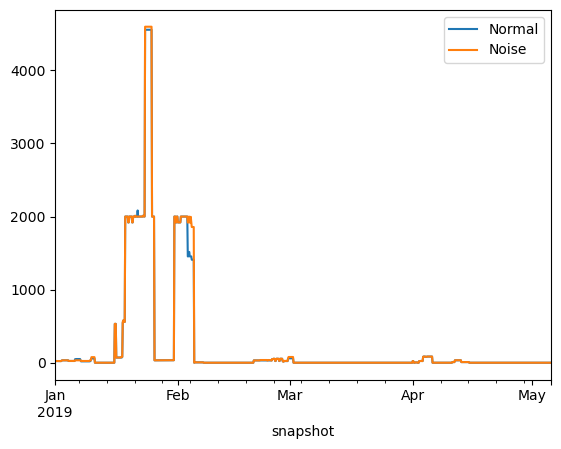

In [52]:
price_normal[0:1000].plot(
    label="Normal"
)
price_wind_noise[0:1000].plot(
    label="Noise"
)

plt.legend()